In [1]:
library(magick)
library(tidyverse)
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

tts <- 20
tts_small <- 16
theme_set(theme_classic(tts))

source("../color_df.R")

color_df <-
    color_df %>% 
    mutate(
        ssp_pop = pop,
        pop = str_remove_all(ssp_pop, "(LR_|Teo_|random1_|random2_)")
    ) %>% 
    dplyr::select(-ssp_pop) %>% 
    distinct()
color_df

Linking to ImageMagick 7.0.10.28
Enabled features: cairo, fontconfig, freetype, fftw, pango, rsvg, webp, x11
Disabled features: ghostscript, lcms

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



pop               color           
1 Los_Guajes        mediumaquamarine
2 Crucero_Lagunitas gold            
3 El_Rodeo          darkorange      
4 Amatlan_de_Canas  cornflowerblue  
5 San_Lorenzo       purple          
6 Palmar_Chico      violetred       
7 random            grey

In [2]:

integer_breaks <- function(n = 5, ...) {
  fxn <- function(x) {
    breaks <- floor(pretty(x, n, ...))
    names(breaks) <- attr(breaks, "labels")
    breaks
  }
  return(fxn)
}

plot_rdmc <- function(file, cle_low = -10, pos = NULL, title = "", subtitle = "", base_size = 15){
    
    
    FREQ_POPS = c(
        "LR.A.Ca.",
        "LR.C.La.",
        "LR.L.Gu.",
        "LR.P.Ch.",
        "LR.S.Lo.",
        "Teo.A.Ca.",
        "Teo.C.La.",
        "Teo.E.Ro.",
        "Teo.L.Gu.",
        "Teo.P.Ch.",
        "Teo.S.Lo."
    )

    id_df <- tibble(sources = 1:length(FREQ_POPS), pop_id = FREQ_POPS) 

    sweep_file <- vroom::vroom(file, delim = "\t")
    
    stopifnot(nrow(sweep_file) > 0)
    all_mods <- 
        sweep_file  %>%  
        filter(!is.na(cle), !is.na(neut_cle)) %>%  
        group_by(model) %>% 
        mutate(mcle = max(cle, na.rm = T) - neut_cle)
  
    best_mcle <- all_mods %>%
      group_by(model) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ungroup()  %>%
      arrange(desc(mcle))

    (best_mod <- best_mcle %>% slice(1) %>% pull(model))

    

    if (best_mod == "standing"){
        

    if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set1") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set1") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set1") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 


        #visualize likelihood surface wrt age
        a  <- all_mods %>%
          group_by(times, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(times), mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("log10 Age") +
          scale_color_brewer(palette = "Set1") +  
          theme_classic(base_size) +
          theme(legend.position = "n") +
          scale_x_log10() 


        #visualize likelihood surface wrt age
        b <- all_mods %>%
          group_by(gs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(gs, mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("Initial allele frequency") +
          scale_color_brewer(palette = "Set1") +      
          theme_classic(base_size) +
          scale_x_continuous(breaks= scales::breaks_pretty(2)) +
          theme(legend.position = "n")  
        

        plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + a + b + plot_layout(nrow = 4)

    } else if(best_mod == "migration"){
        
     if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set2") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set2") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set2") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 

        
         a  <- all_mods %>%
          group_by(migs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(migs), mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("log10 Migration rate") +
          scale_color_brewer(palette = "Set2") +
          theme_classic(base_size) +
          theme(legend.position = "n")

        b  <- all_mods %>%
          group_by(sources, model) %>%
          filter(model == best_mod) %>%  
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          filter(mcle > cle_low) %>%
          left_join(., id_df, by = "sources") %>% 
          ggplot() +
          geom_segment(aes(x = pop_id, xend = pop_id, y =0, yend = mcle, colour = model), lwd = 1.2) +
          ylab(expression(Delta[cle])) +
          xlab("Source") +
          scale_color_brewer(palette = "Set2") +
          theme_classic(base_size) +
          scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
          theme(legend.position = "n") 

        plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + a + b + plot_layout(nrow = 4)

    } else {
        
        
        if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set1") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set1") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set1") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 
        
        
    plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + plot_layout(nrow = 2)
        
    }
    
        return(plot_full)

}

All of this is broken cause the intervals have changed.

options(repr.plot.width = 25, repr.plot.height = 10, repr.plot.res = 200)

tb1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start272261071_end272472669_pops1-2-3-4-5.txt", 
    cle_low = -20, 
    title = "A", 
    subtitle = "tb1\n(branching architecture)\nMigration"
)

bt2 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start60951507_end61558027_pops1-2-3-4-5-10.txt", 
    cle_low = -20,
    title = "B", 
    subtitle = "bt2\n(startch synthesis)\nMigration"
)


ZmSh1_1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start230510870_end230574345_pops3-4-5.txt",  
    cle_low = -20,
    title = "C",
    subtitle = "ZmSh1-1\n(seed shattering)\nMigration"
)

su1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start43263146_end43615149_pops2-3-4.txt",
    cle_low = -20,
    title = "D",
    subtitle = "su1\n(starch biosynthesis)\nStanding"
)

sweet <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start130340943_end130464598_pops1-2-4-5.txt",
    cle_low = -20,
    title = "E",
    subtitle = "sweet4c\n(sugar transport, seed size)\nStanding"
)



(tb1 | bt2 | ZmSh1_1) |  su1 |  sweet + theme(plot.margin = unit(c(0.1,1,0.1,1), "cm")) 
ggsave("../figures/supplement_domestication_sweeps.pdf", height = 10, width = 25)


plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start60951507_end61558027_pops1-2-3-4-5-10.txt", 
    cle_low = -Inf,
    title = "B", 
    subtitle = "bt2\n(startch synthesis)\nMigration"
)


all_mods <- vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")

range(vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")$cle, na.rm = T)

all_mods %>%
    filter(is.na(cle))

In [3]:
make_rdmc_file <- function(file_name){
    
    if(file.exists(file_name)){
        read_csv(file_name)
    } else {    
        suppressWarnings(
        suppressMessages(
            
        top_models_df <- fs::dir_ls(path = "../data/rdmc/fitted/") %>% 
            map_df(~{
                    sweep_file <- vroom::vroom(.x, delim = "\t")
                    if(nrow(sweep_file) > 0){
                        sweep_file %>% 
                        #filter(!is.na(cle), !is.na(neut_cle), !neut_cle %in% c(-Inf, Inf), !cle %in% c(-Inf, Inf)) %>%  
                        group_by(model) %>%
                        filter(cle == max(cle, na.rm=T)) %>%
                        mutate(mcle = cle - neut_cle) %>%
                        ungroup() %>%
                        mutate(mcle_delta = mcle - max(mcle, na.rm=T)) %>%
                        arrange(desc(mcle)) %>%  
                        slice(1:2) %>%
                        mutate(mcle_nextbest_diff = -diff(mcle)) %>% 
                        slice(1) %>%
                        mutate(file_name = .x)
                    } else{
                        tibble()
                    }

            }) %>% 
            mutate(populations = sel_pop_ids) %>% 
            mutate(populations = str_remove_all(populations, "data/raisd/"),
                   populations = str_remove_all(populations, ".corrected_block_outliers_merged.txt"),
                   populations = str_replace_all(populations, "random1", "RANDOM1"),
                   populations = str_replace_all(populations, "random2", "RANDOM2"),
                   type = case_when(
                       grepl("LR", populations) & grepl("Teo", populations) ~ "both",
                       grepl("LR", populations) & !grepl("Teo", populations) ~ "Maize",
                       !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
                       TRUE ~ "nan"
                   ),
                pop_count = str_count(populations, ";")+1,
                Landraces_count = str_count(populations, "LR"),
                Teosinte_count =  str_count(populations, "Teo"),
                model2 = ifelse(mcle < 0, "neutral", model)
                ) 
        ))
        
            write_csv(x = top_models_df, file = file_name)
            top_models_df
    }
}


In [54]:
top_models_df <- make_rdmc_file("rdmc_topmodels.csv")
#top_models_df <- top_models_df %>% filter(mcle > 10)



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  locus = col_character(),
  sel_pops = col_character(),
  model = col_character(),
  sel_pop_ids = col_character(),
  file_name = col_character(),
  populations = col_character(),
  type = col_character(),
  model2 = col_character()
)
ℹ Use `spec()` for the full column specifications.




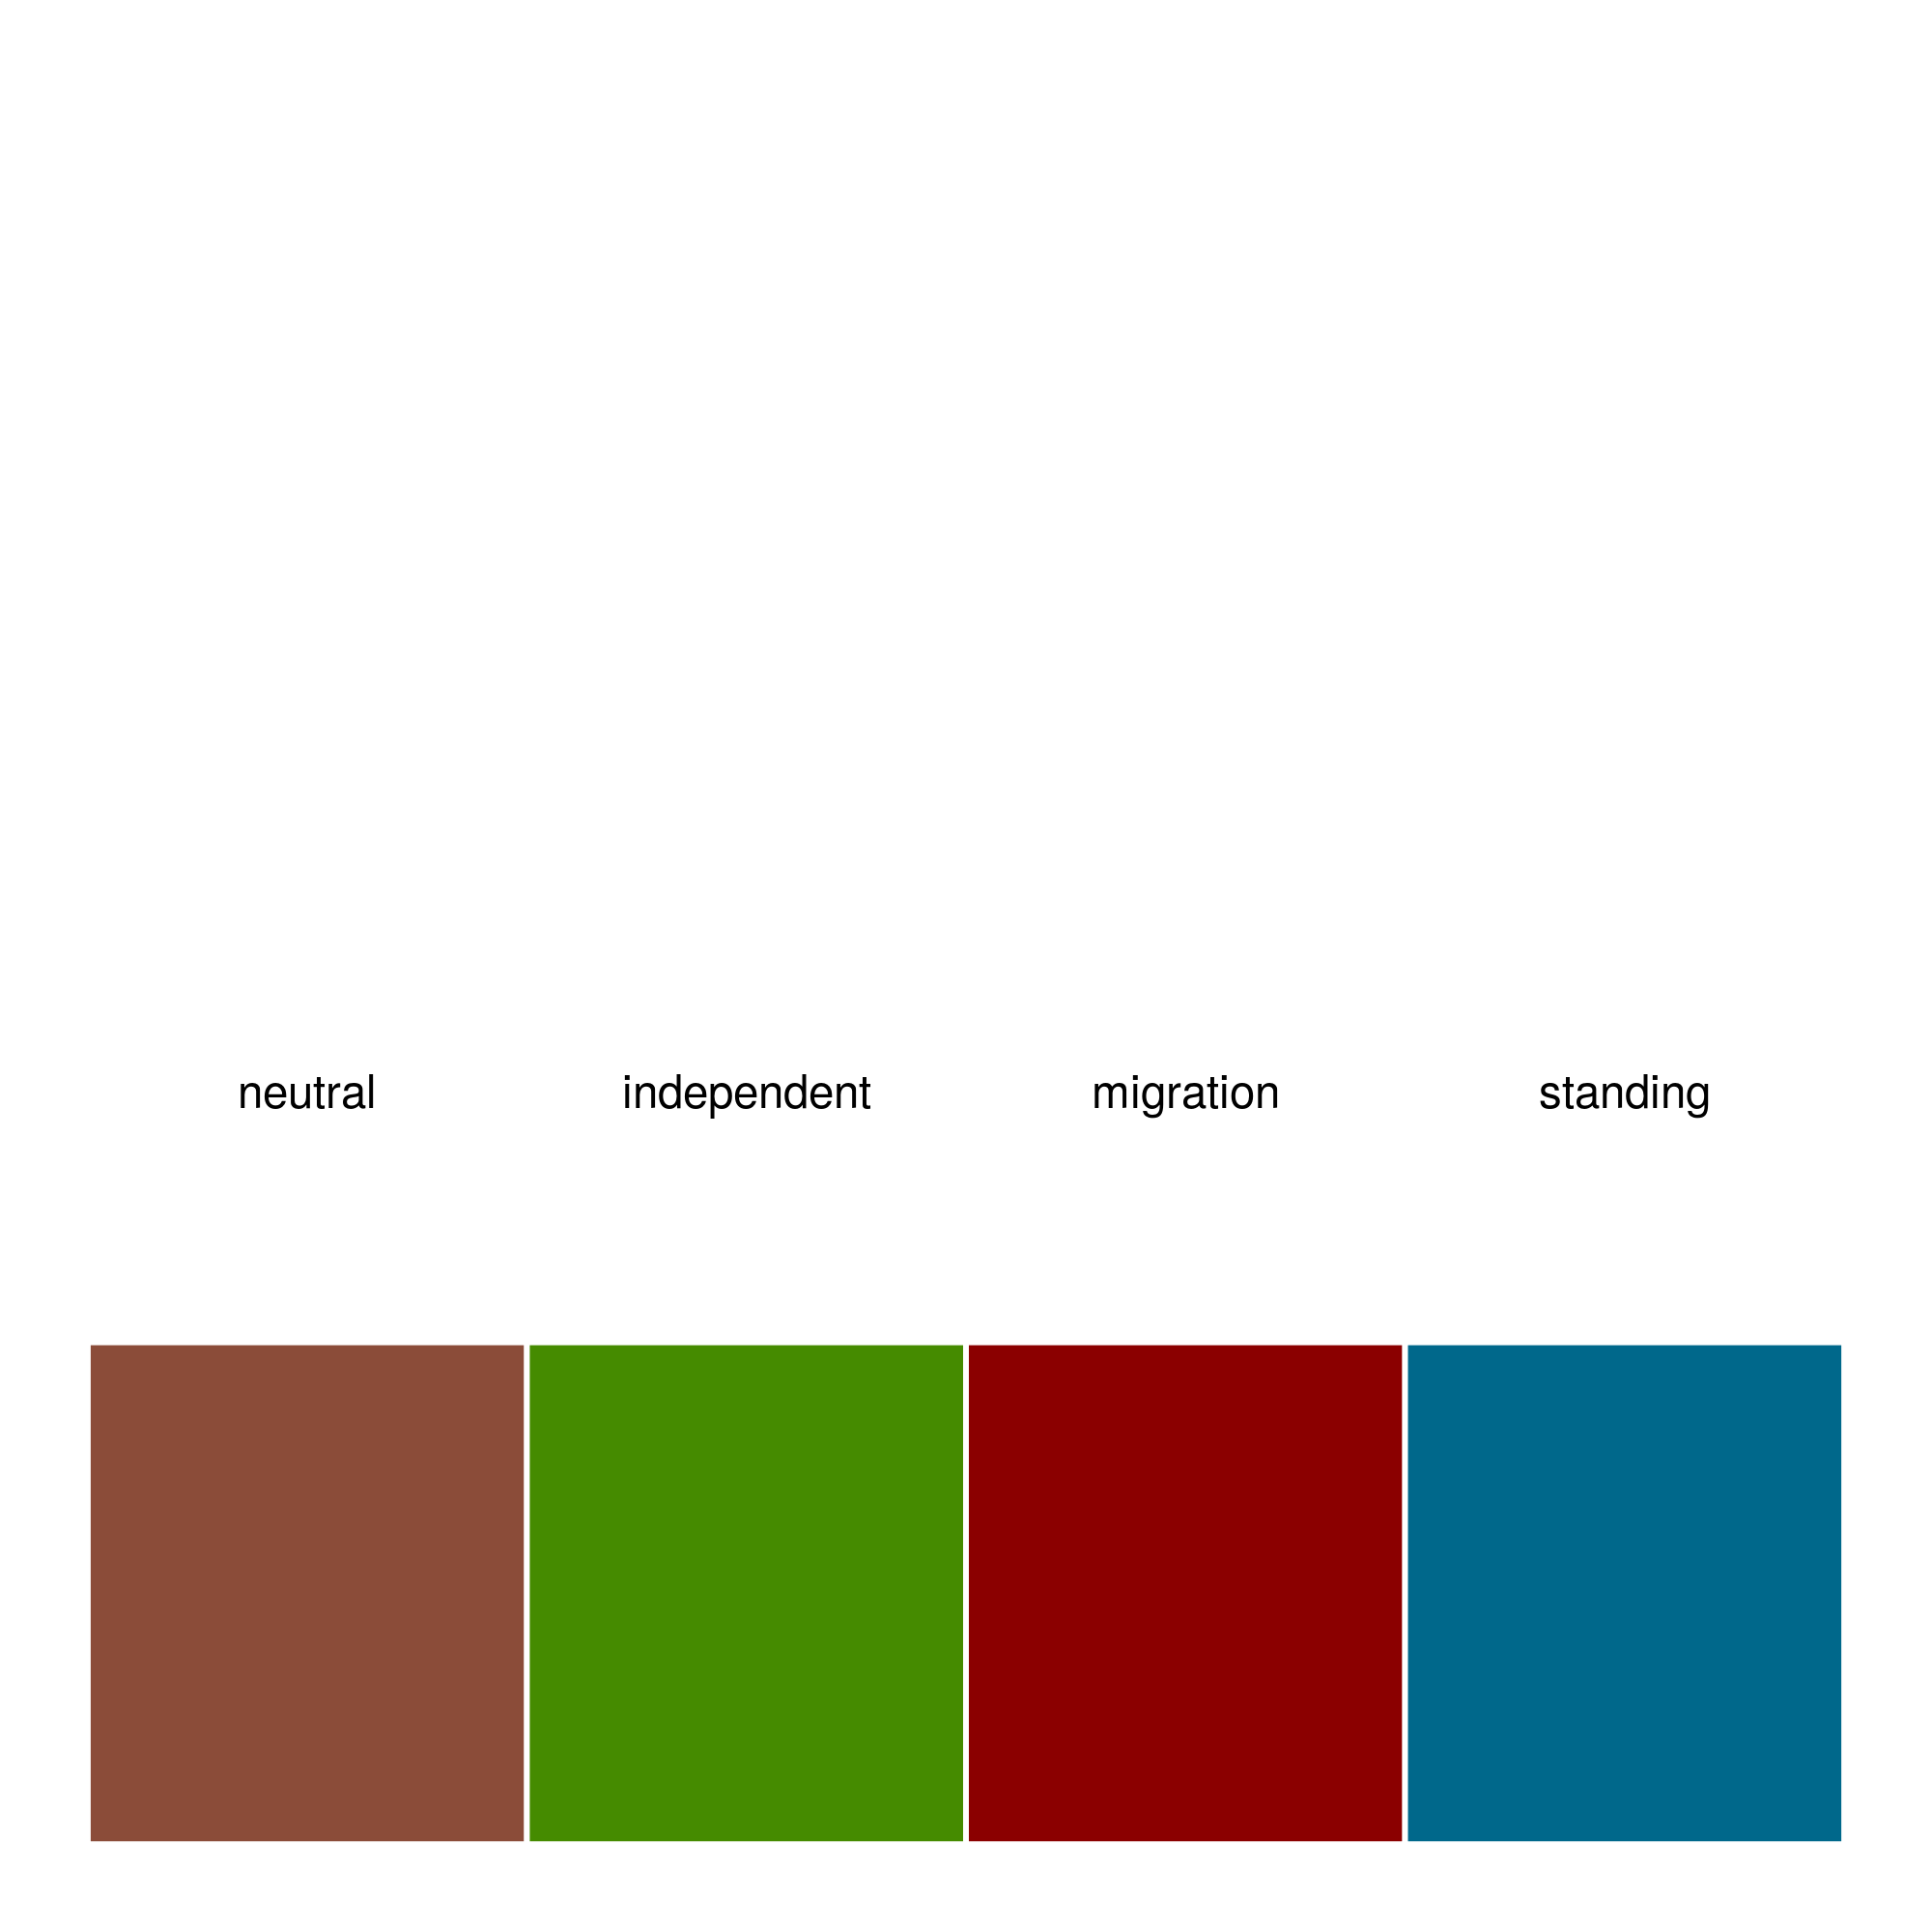

In [55]:
mode_leg <- function(size = 6, nud = 0.5){
tibble(mode = c("neutral", "independent", "migration", "standing"),
      color = c("salmon4", "chartreuse4", "darkred", "deepskyblue4"),
      position_x = 1:4,
      position_y = rep(0, 4),
      ) %>% 
ggplot(aes(position_x, position_y, fill = color)) +
    geom_tile(colour = "white", lwd = 1) +
    geom_text(aes(position_x, position_y + nud, label = mode), inherit.aes = F, size = size) +
    xlim(0.5, 4.5) +
    ylim(-0.5, 2+nud) +
    scale_fill_identity() +
    theme_void()
}

mode_leg(nud = 1)

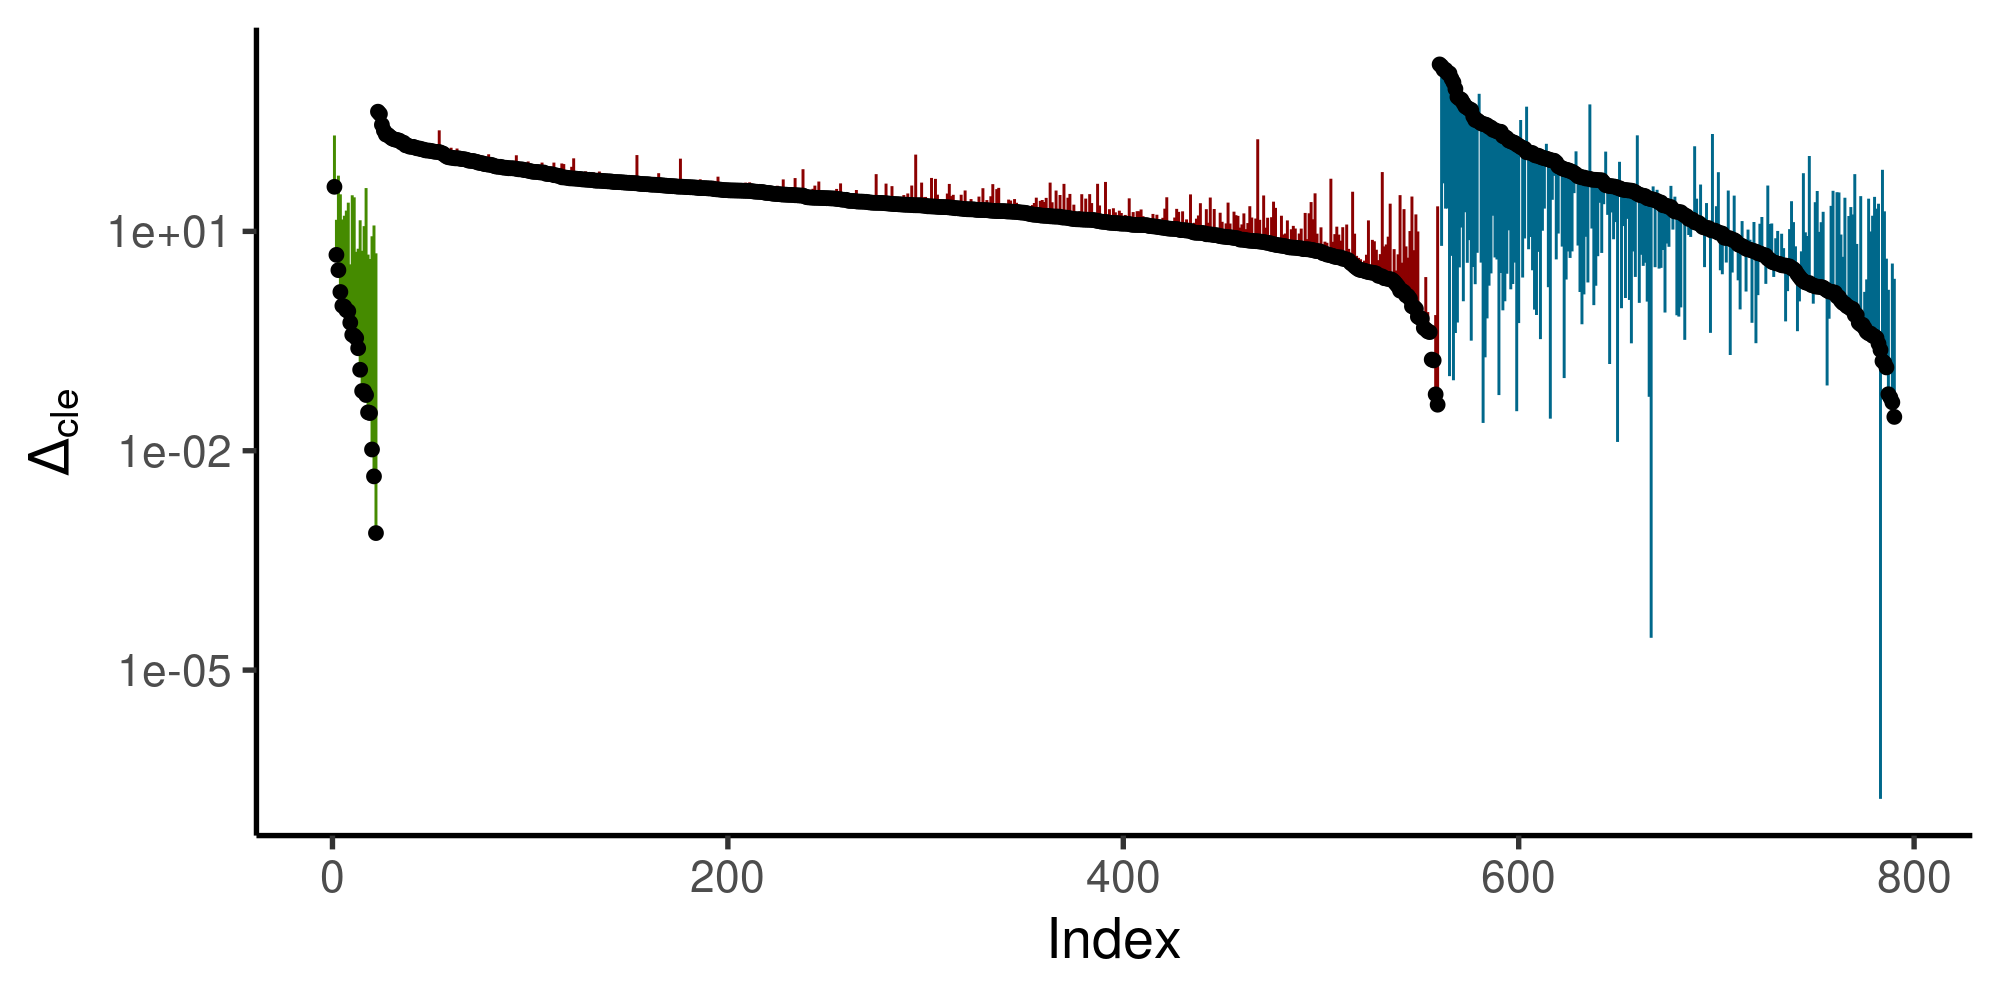

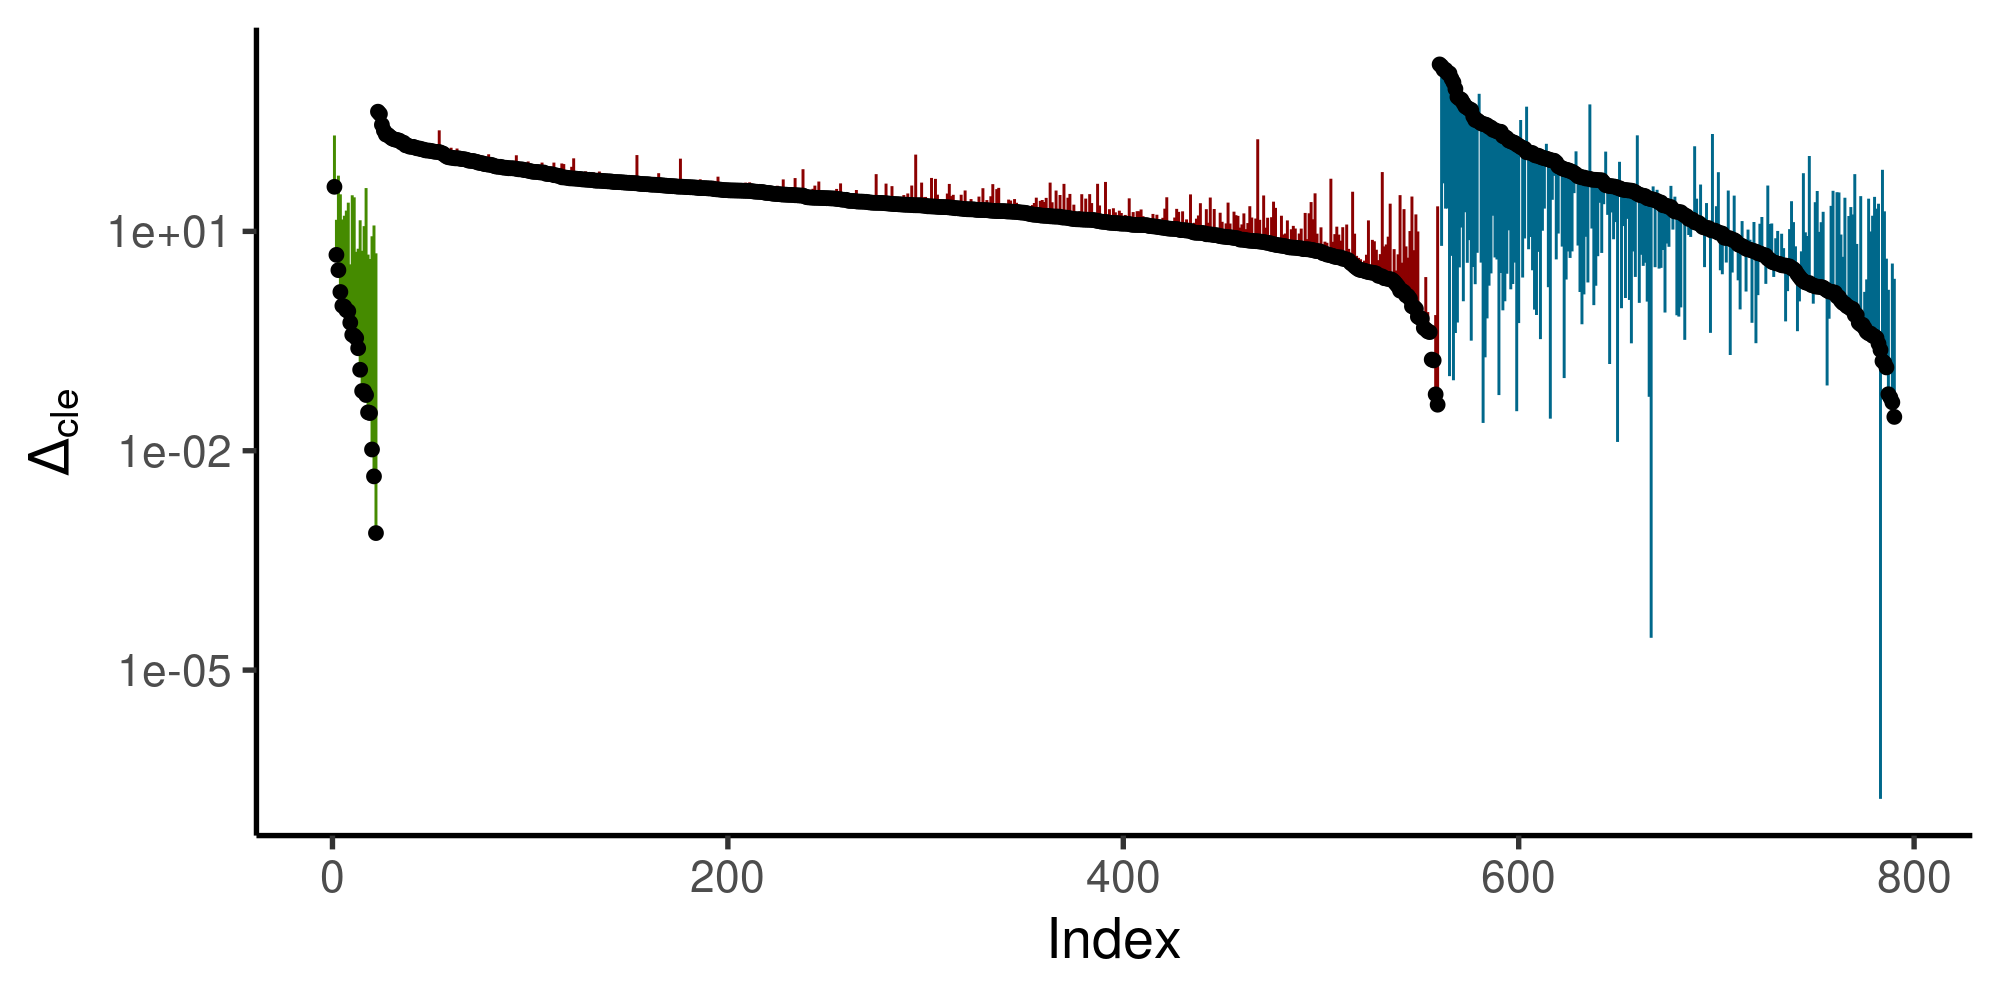

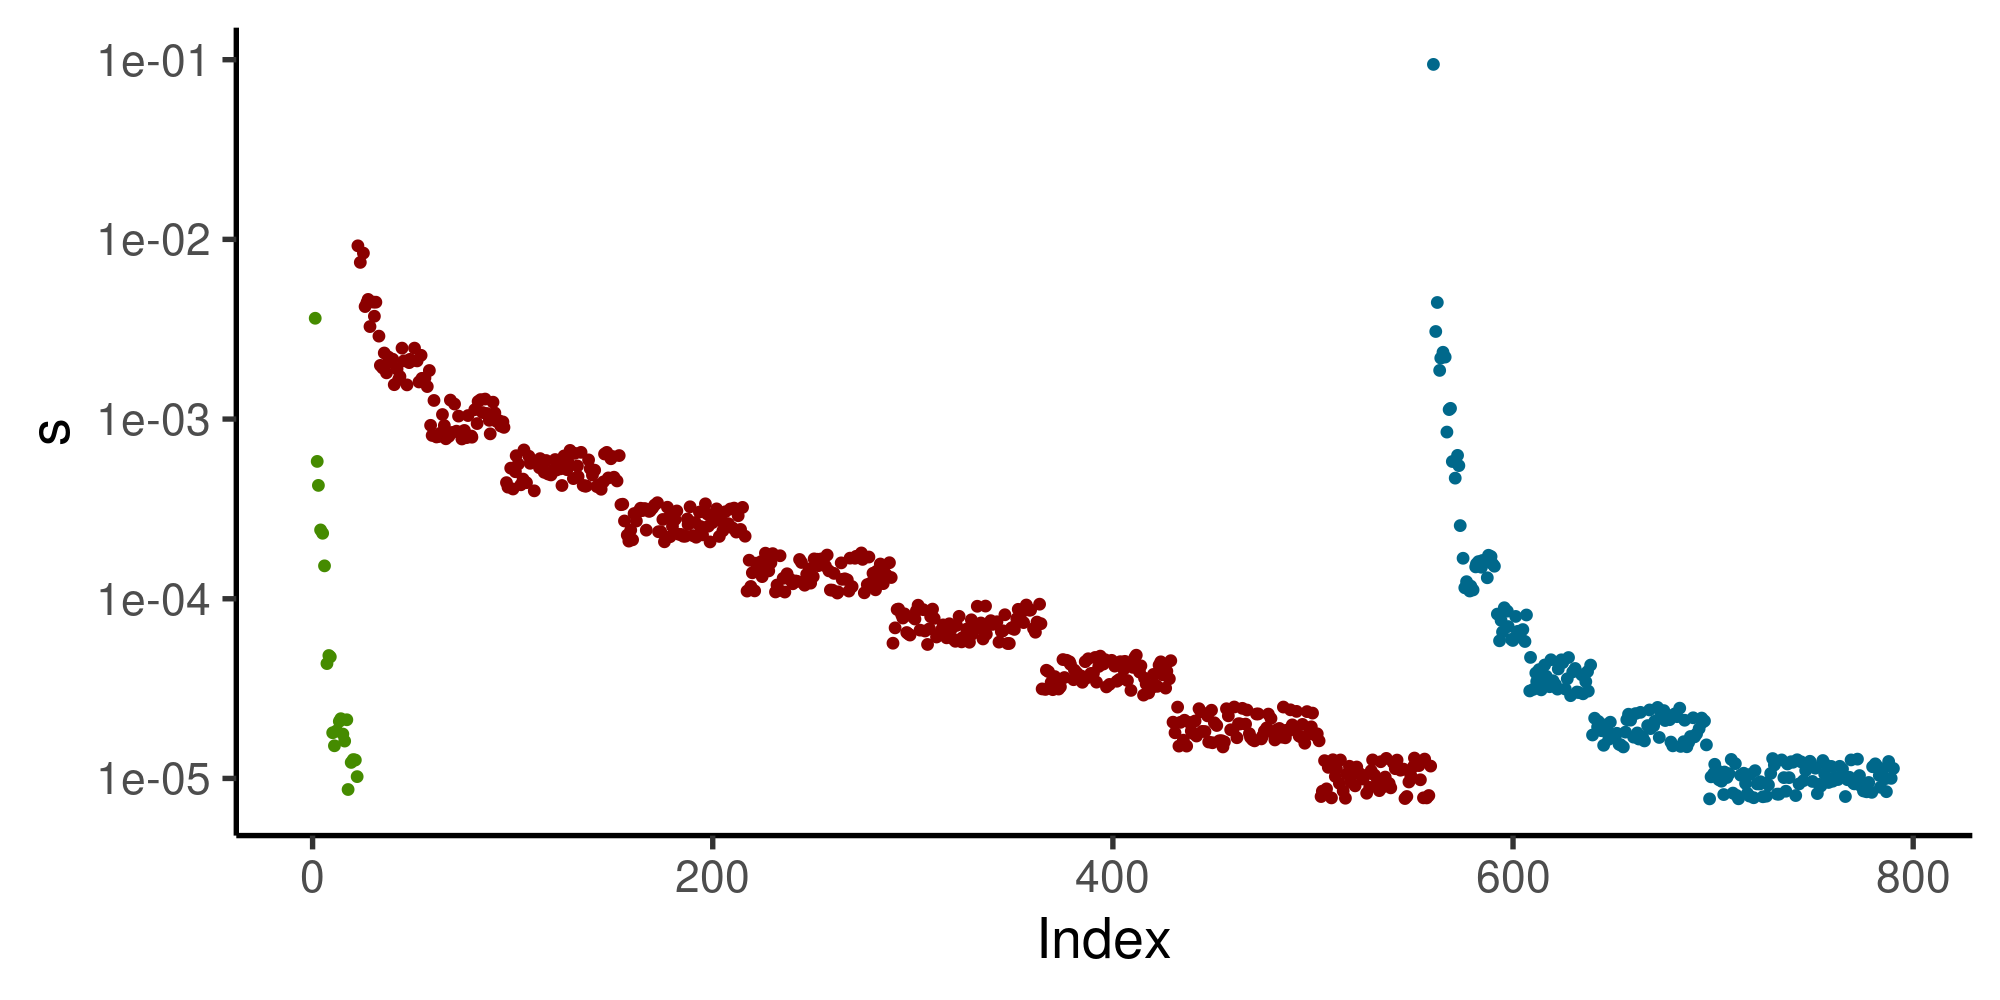

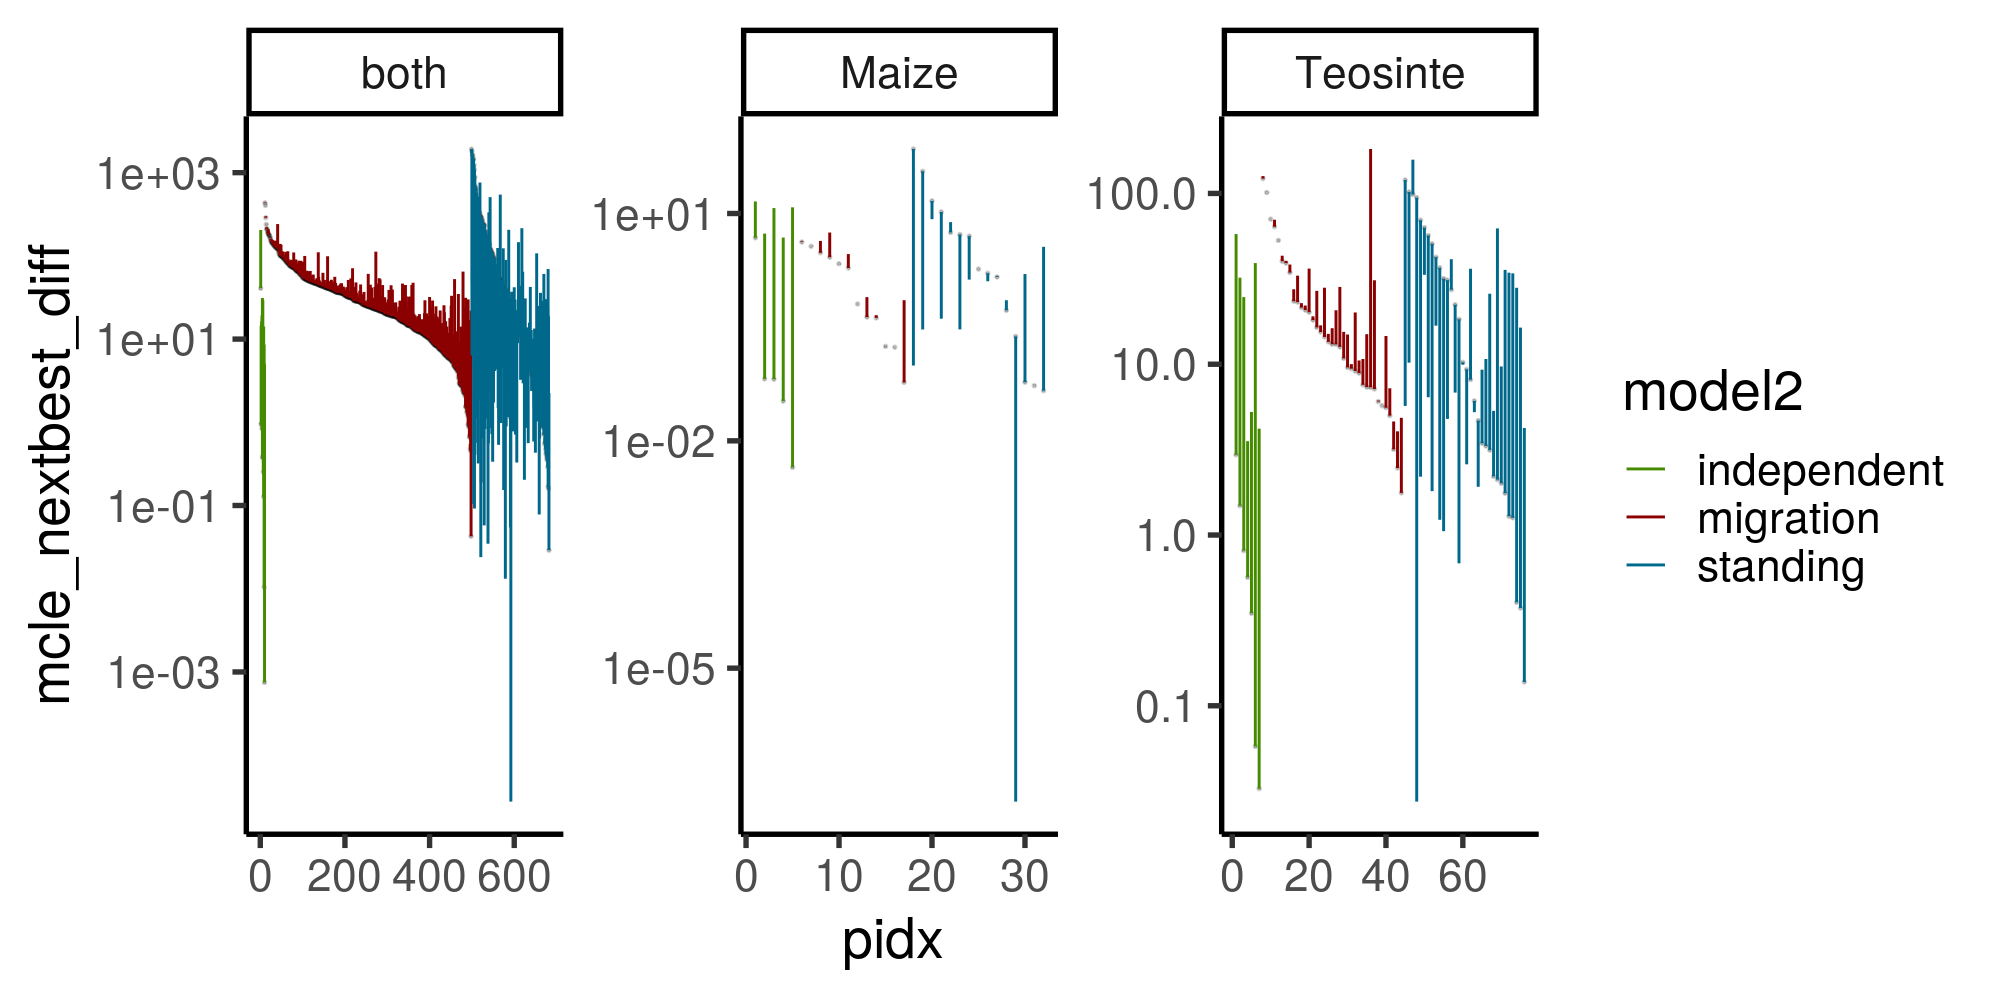

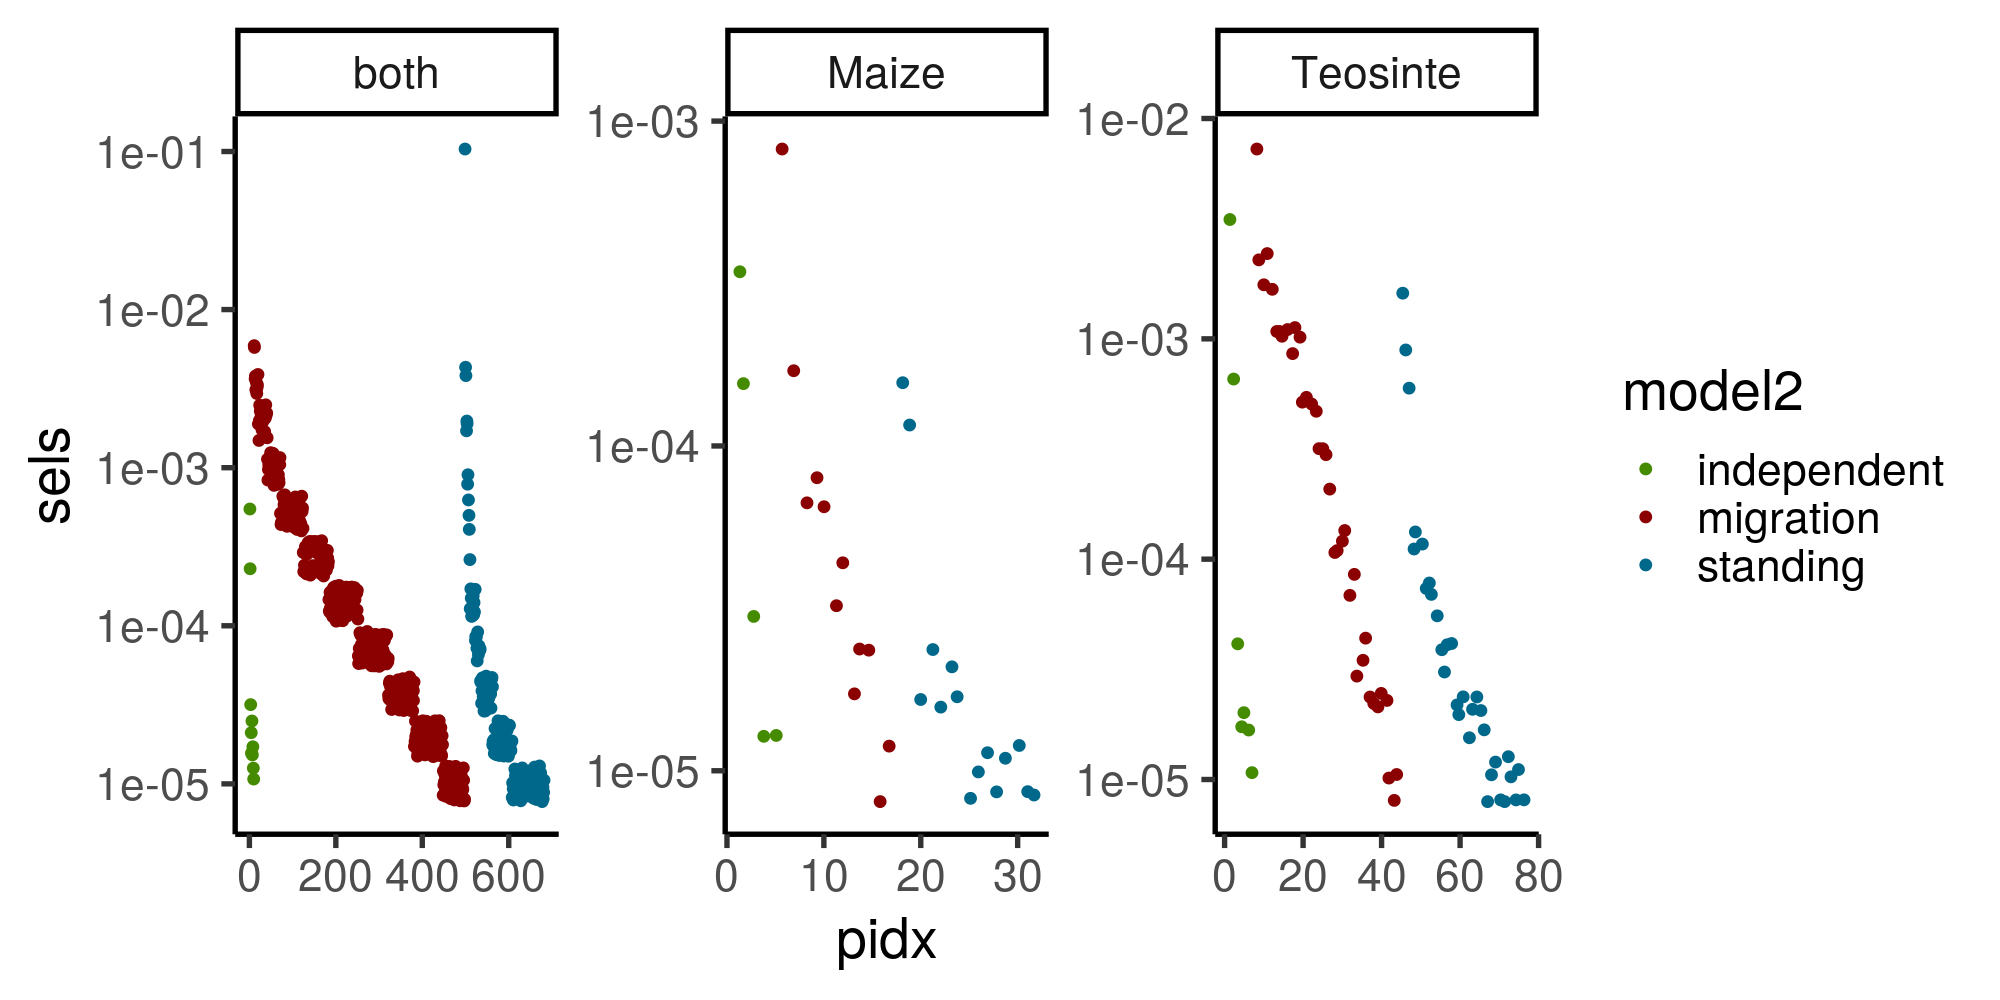

In [56]:

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)
#mode_cols <- c("independent" = "chartreuse4", "migration" = "dodgerblue", "standing" = "purple")
sel_cols <- c("neutral" = "salmon4", "independent" = "chartreuse4", "migration" = "darkred", "standing" = "deepskyblue4")


mode_mcle <- 
    top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    mutate(pidx = 1:n())  %>% 
    ggplot() +
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    geom_point(aes(pidx, mcle_nextbest_diff), size = 2, alpha = 1) +
    scale_y_log10() +
    scale_color_manual(values = sel_cols) +
    theme(legend.position = "n") +
    xlab("Index") +
    ylab(expression(Delta[cle]))
mode_mcle


mode_sels <- 
    top_models_df %>% 
    filter(model2 != "neutral")  %>%
    arrange(model2, desc(sels)) %>%
    mutate(pidx=1:n()) %>% 
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter()+
    scale_y_log10() +
    scale_color_manual(values = sel_cols) +
    xlab("Index") +
    ylab("s") +
    labs(color='Mode') +
    theme(legend.position = "n")


mode_mcle
mode_sels

top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    group_by(type) %>% 
    mutate(pidx = 1:n())  %>% 
    ggplot()+
    geom_point(aes(pidx, mcle_nextbest_diff), size = 0.25, alpha = 0.2) +
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = sel_cols)

top_models_df %>% 
    filter(model2 != "neutral")  %>%
    arrange(model2, desc(sels)) %>%
    group_by(type) %>% 
    mutate(pidx=1:n()) %>% 
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter()+
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = sel_cols)


model2      n()
1 independent  22
2 migration   537
3 neutral      89
4 standing    231

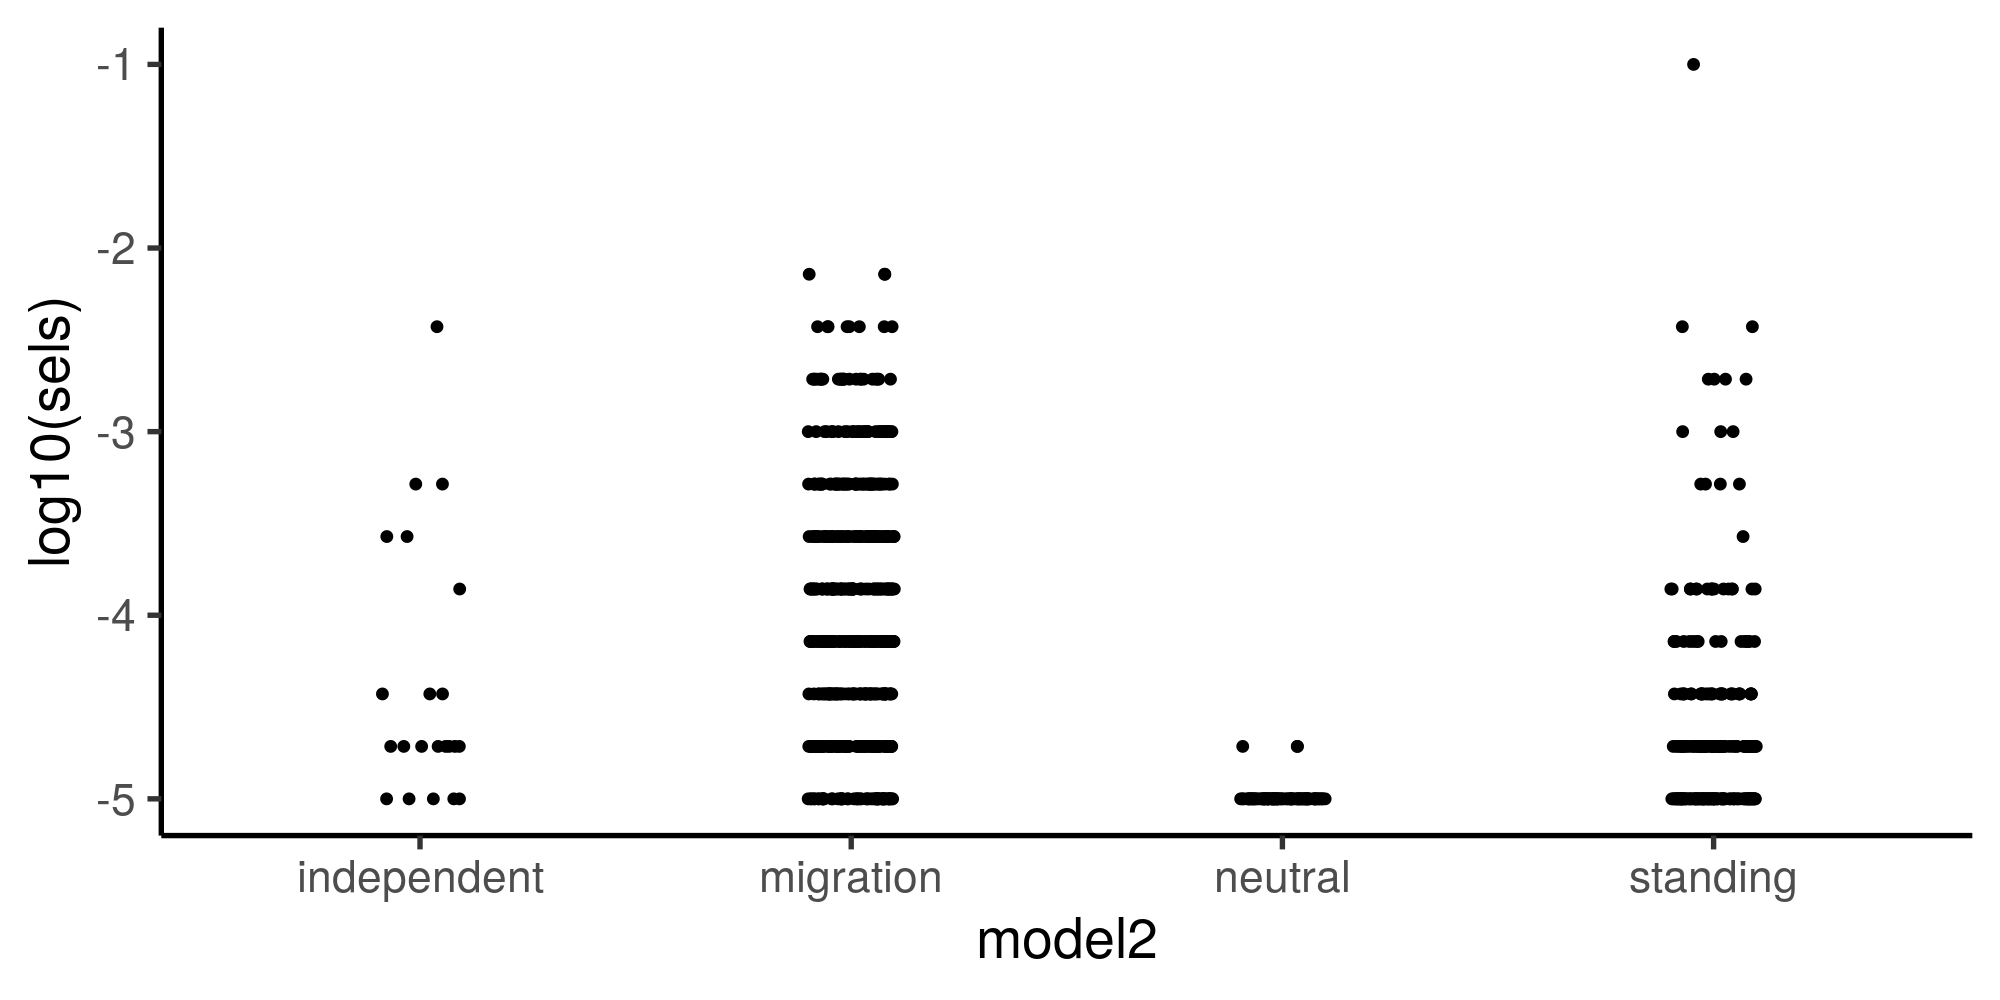

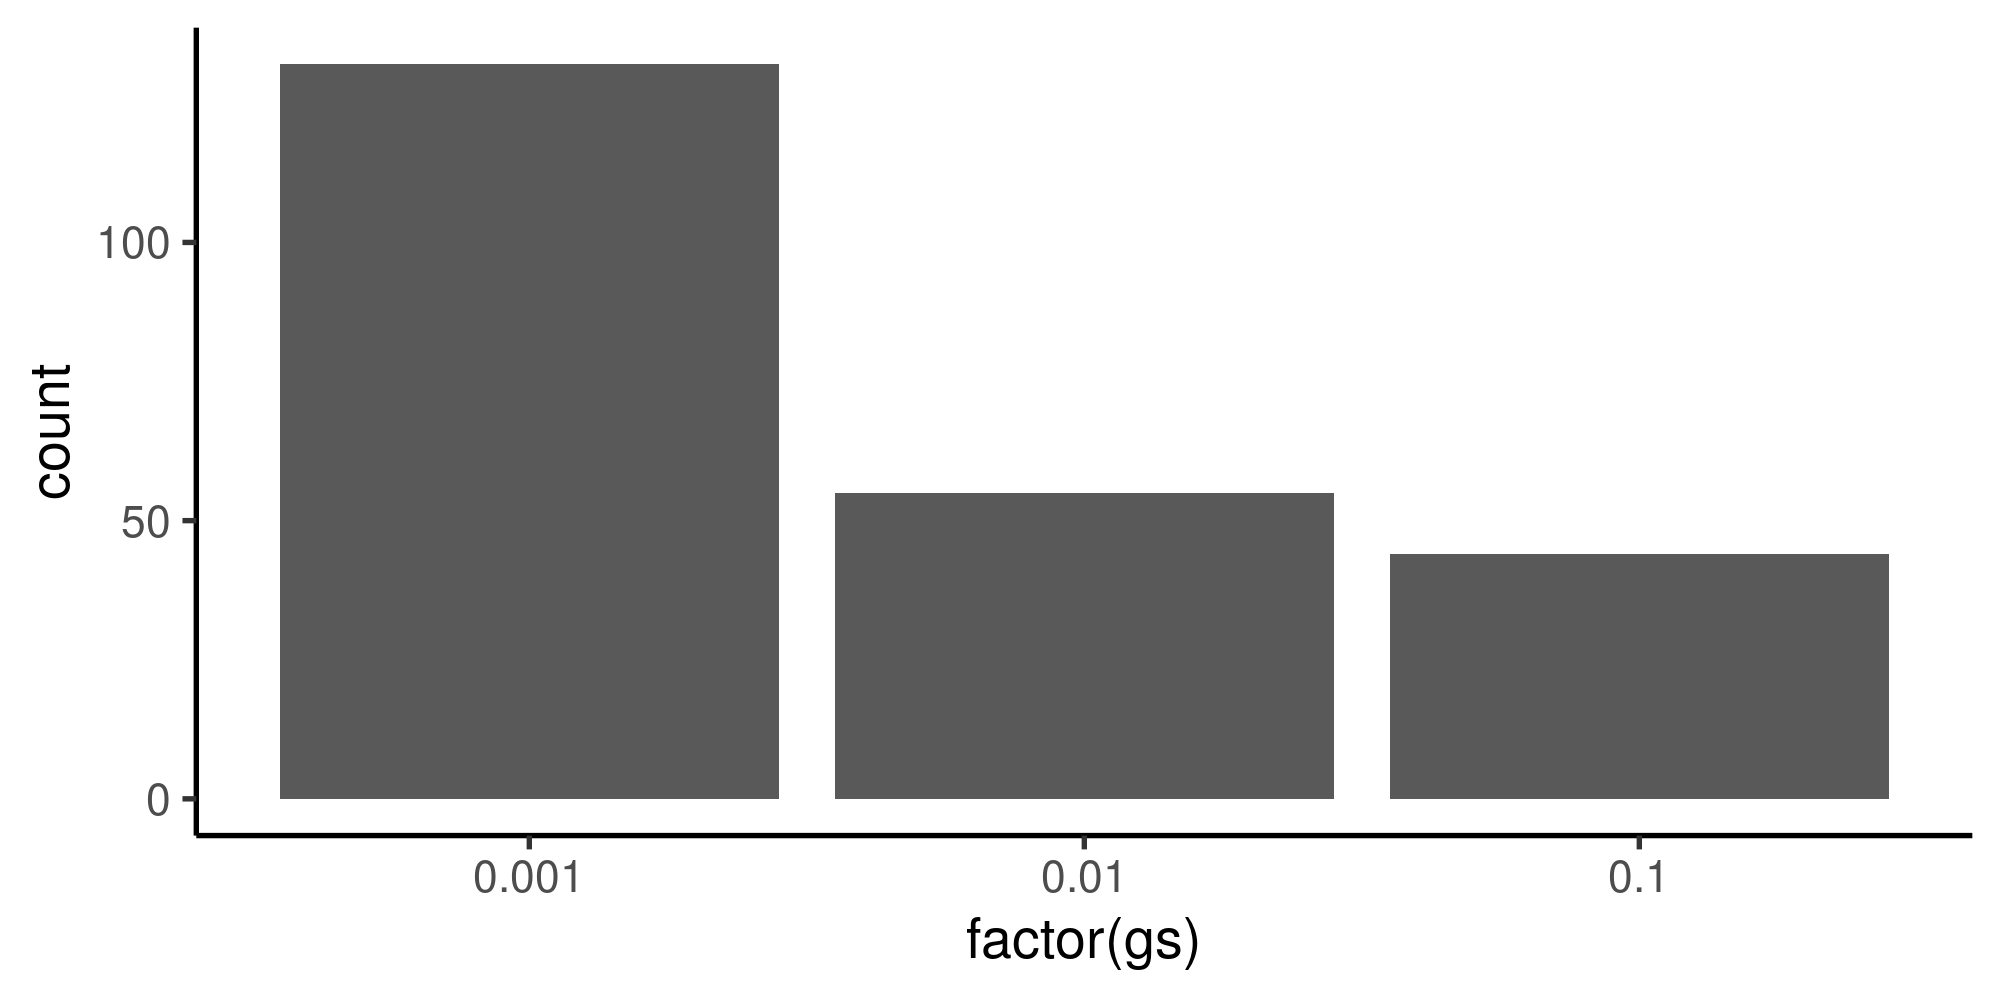

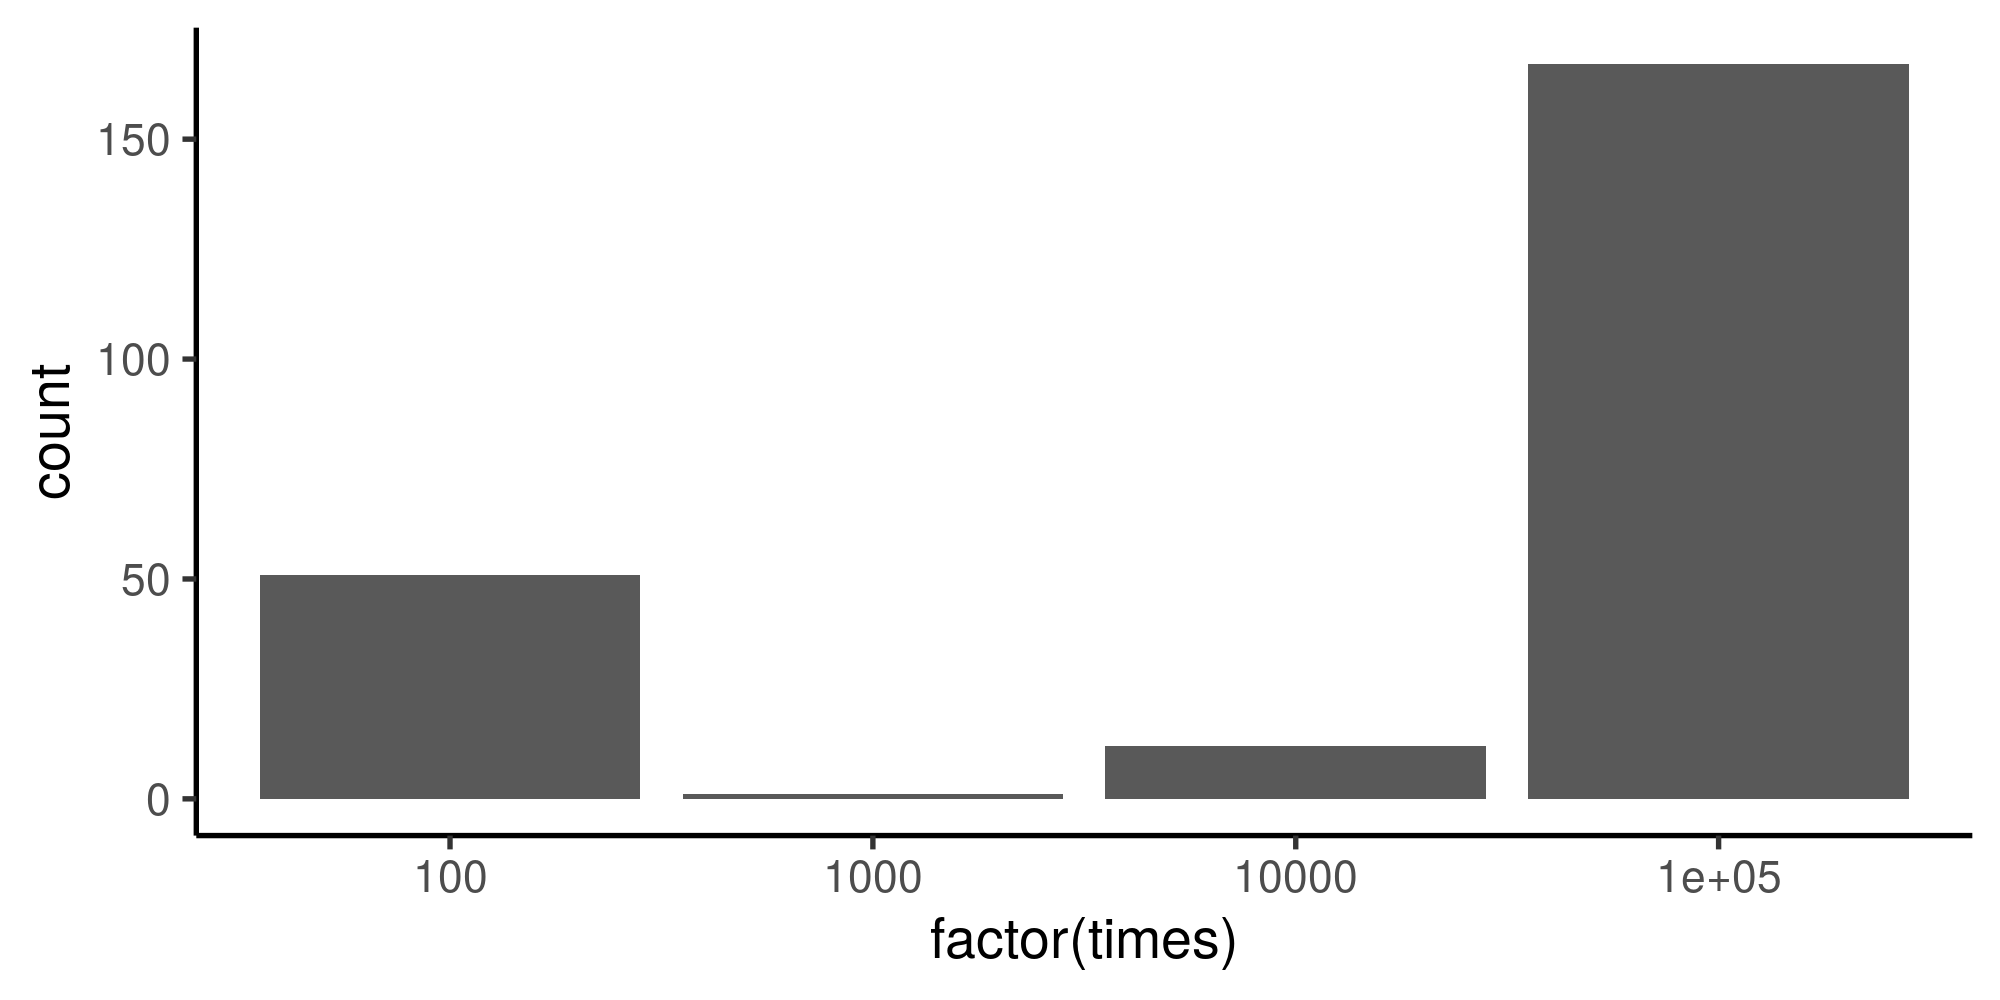

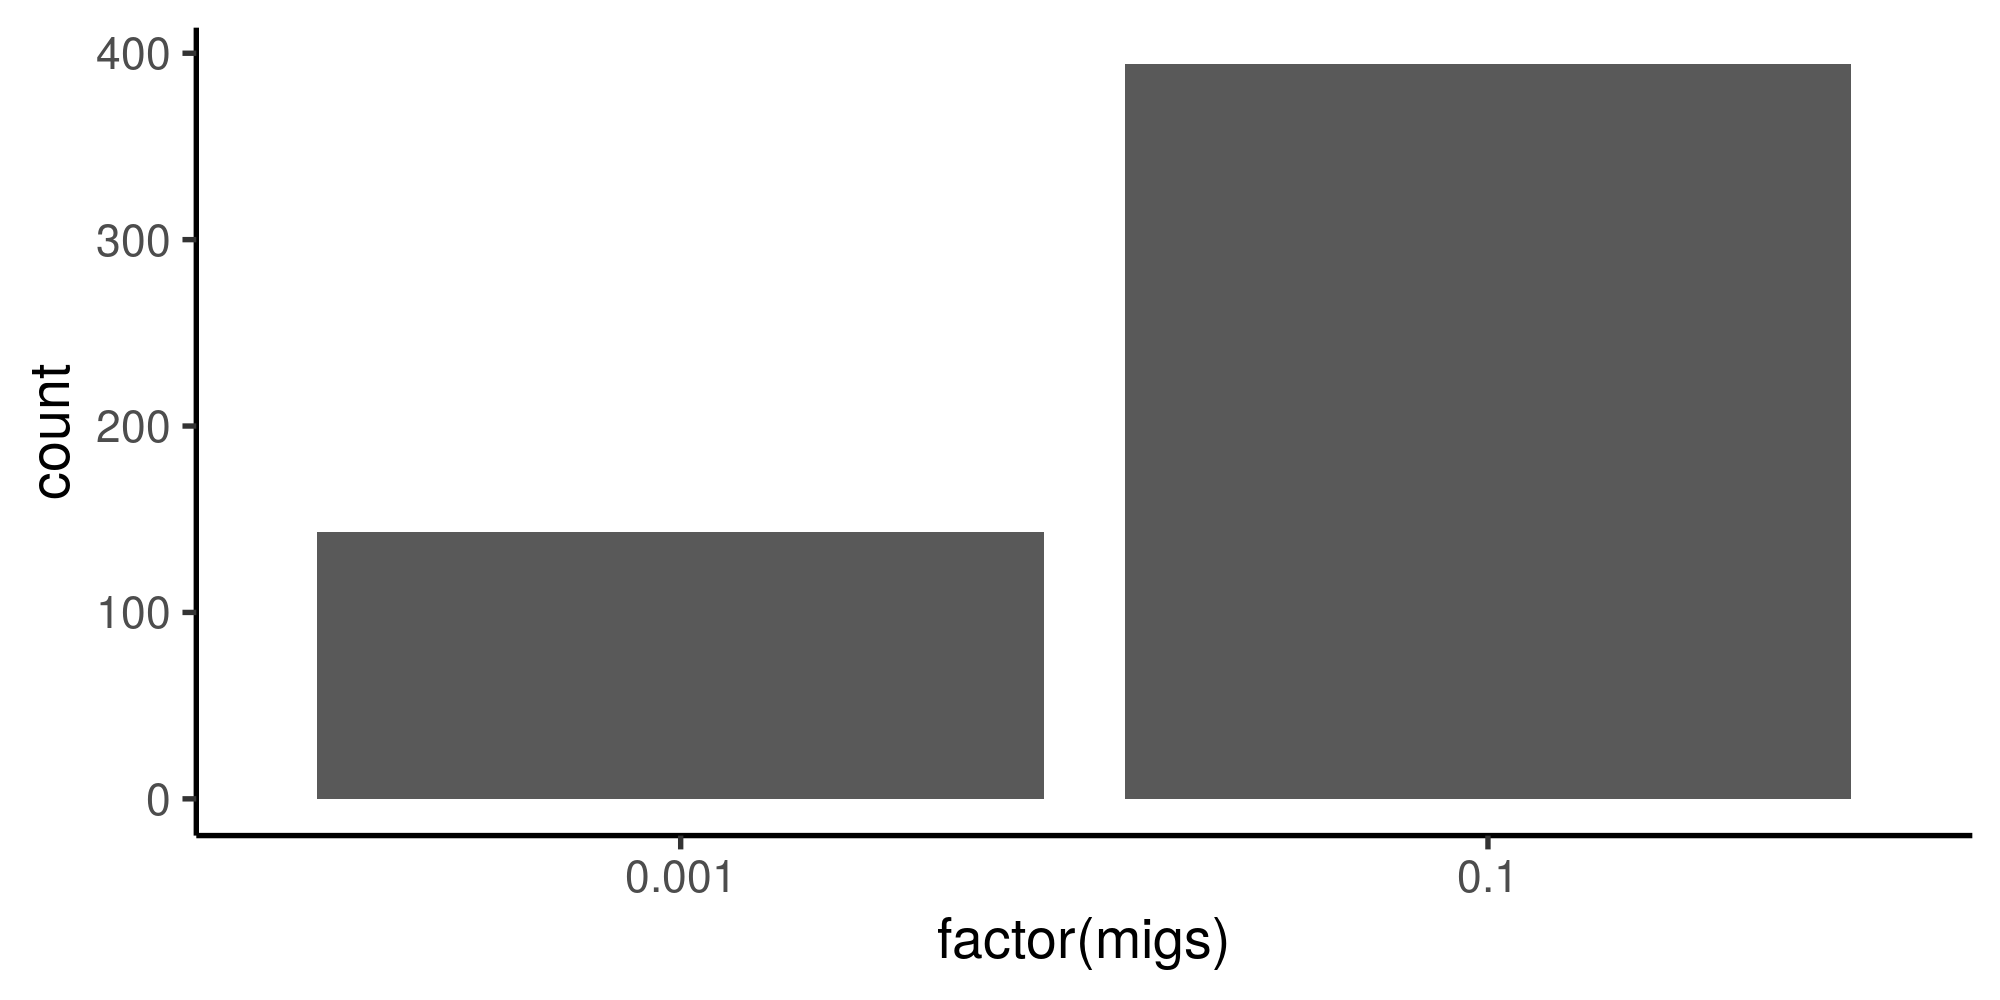

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


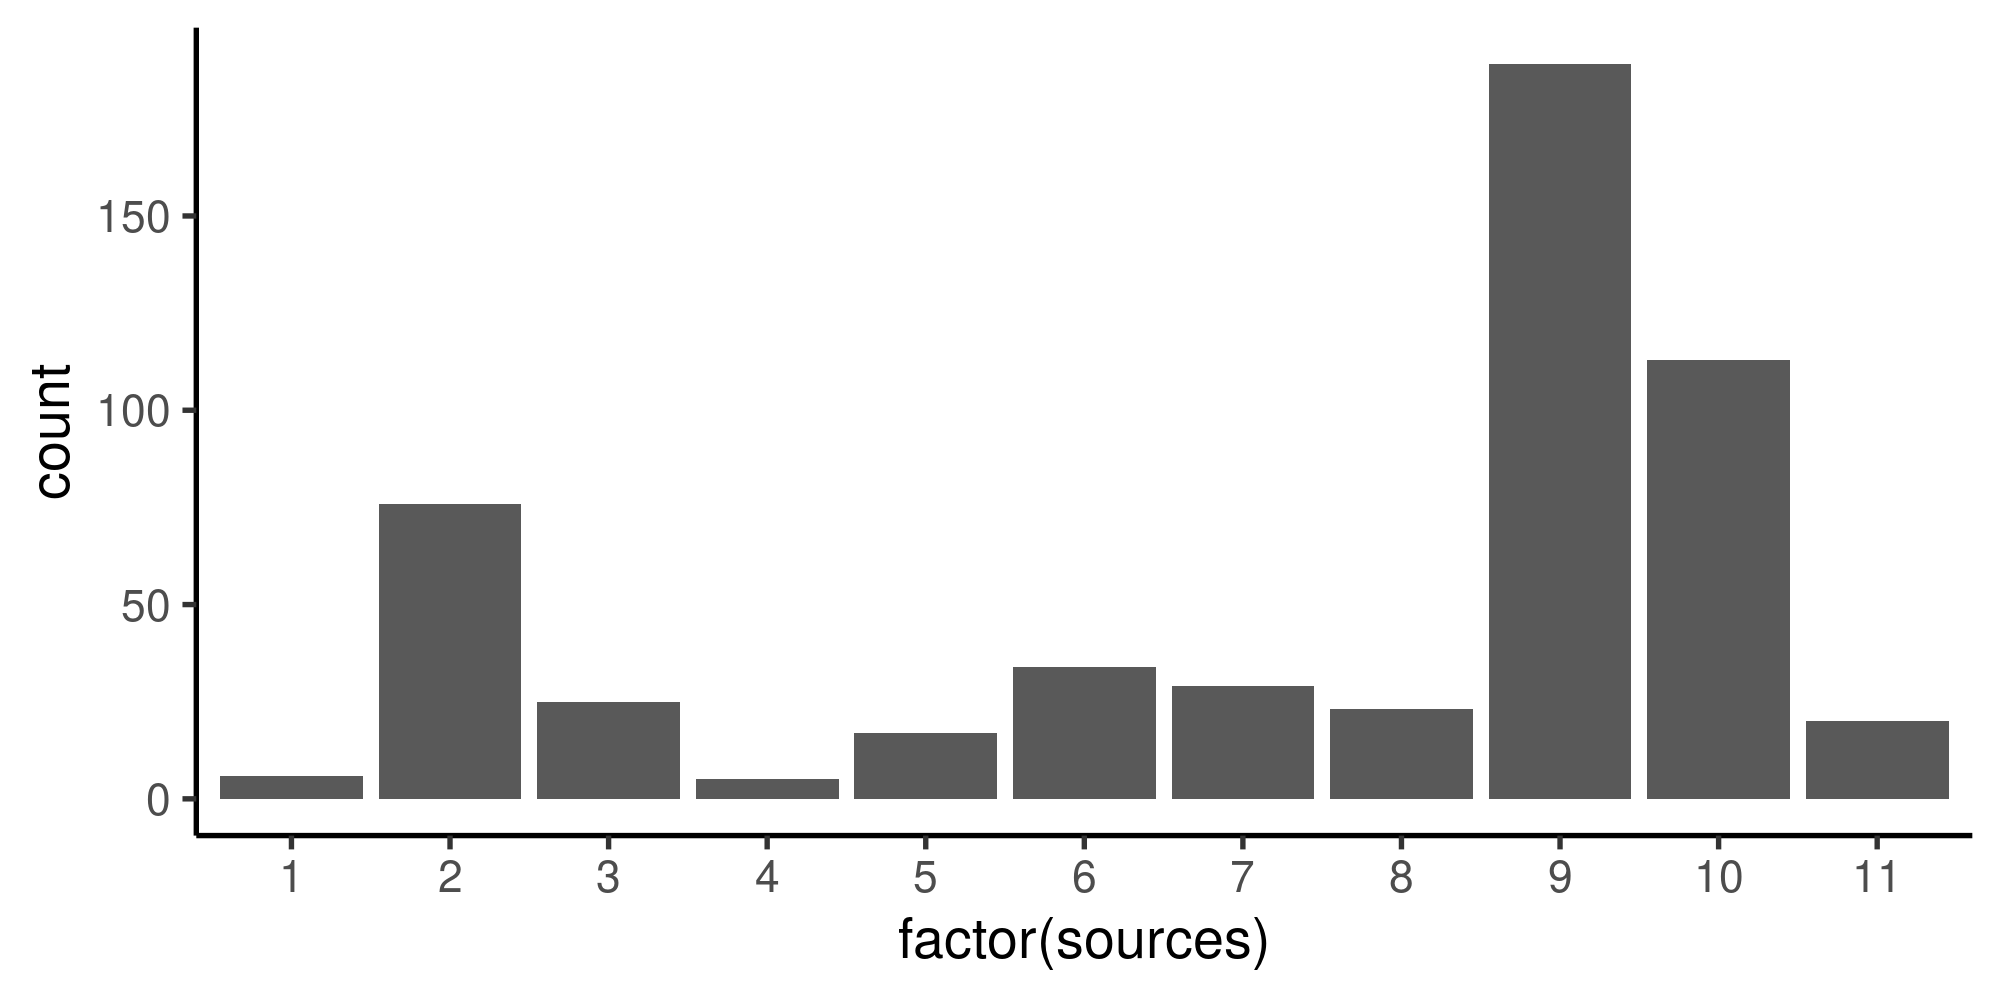

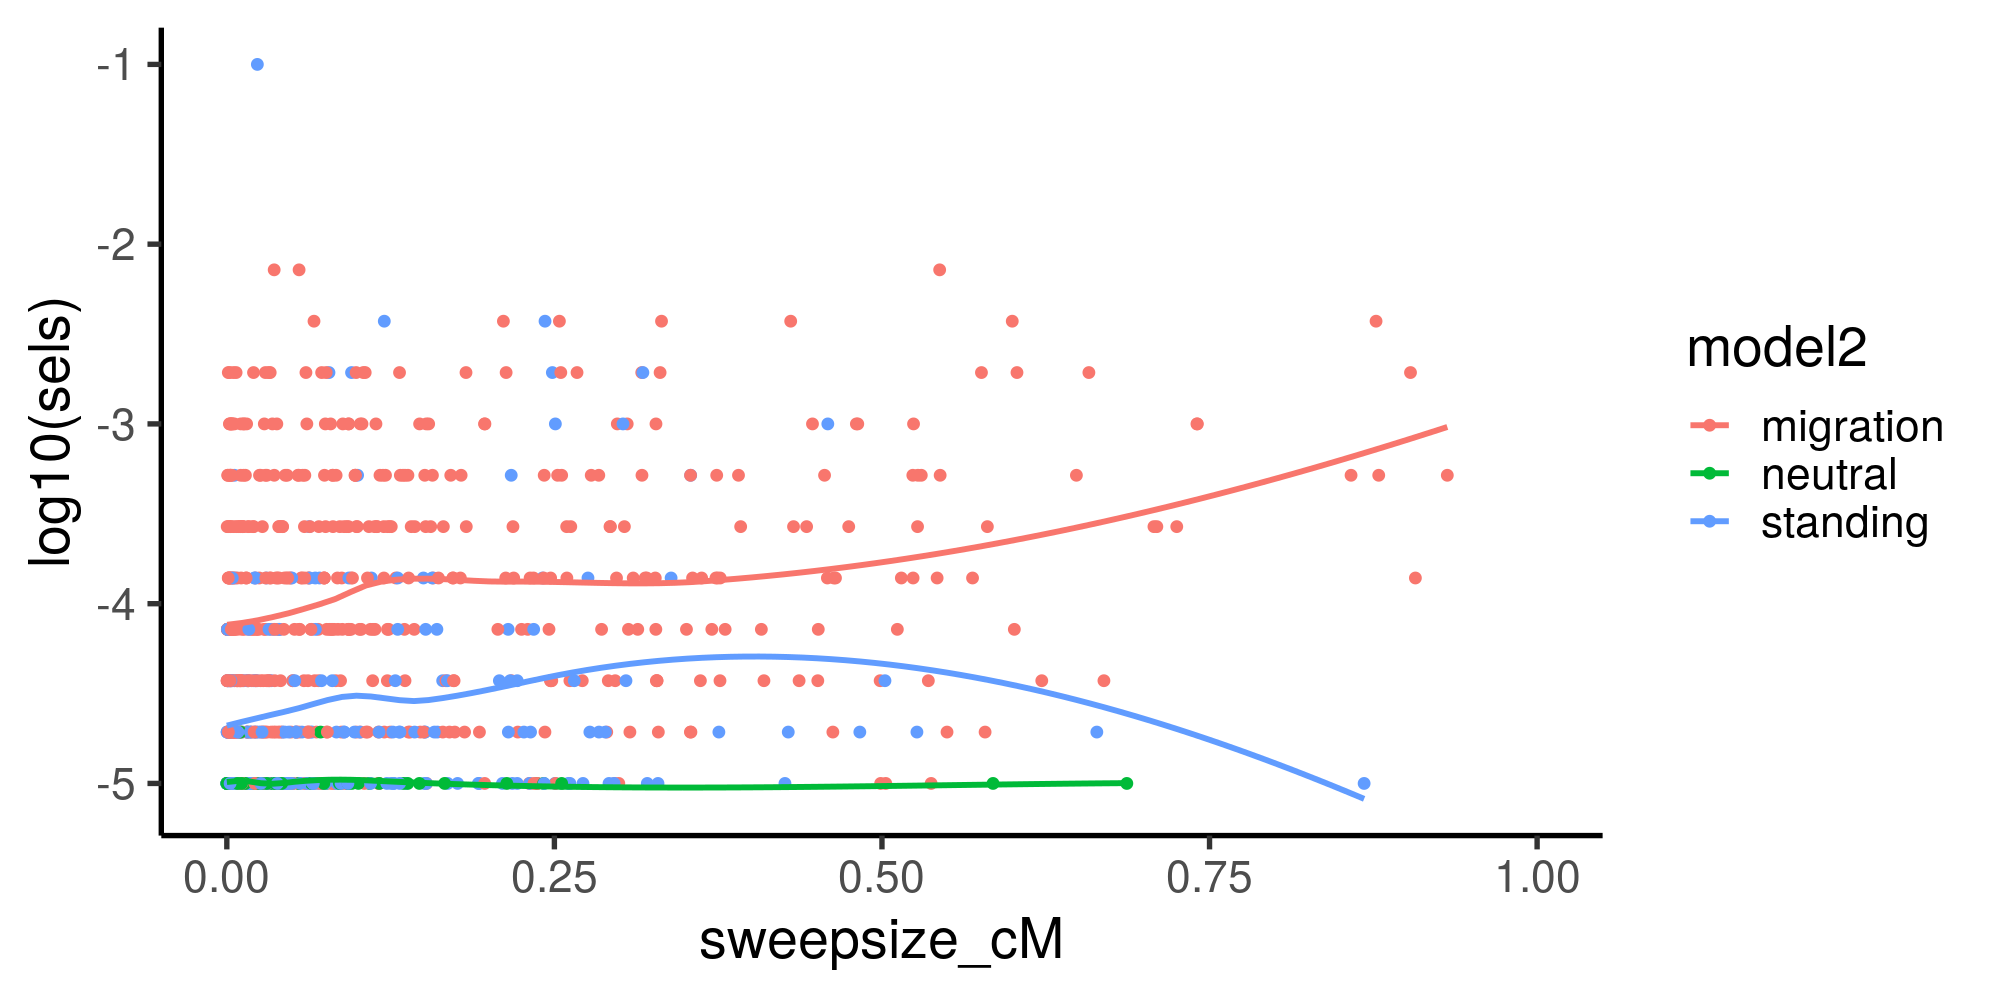

In [57]:


top_models_df %>%
    group_by(model2) %>% 
    summarise(n())

top_models_df %>% 
    ggplot(aes(model2, log10(sels))) +
    geom_jitter(width = 0.1, height = 0)

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(gs))) +
    geom_bar(stat = "count")

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(times))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(migs))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(sources))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 != "independent") %>% 
    ggplot(aes(sweepsize_cM, log10(sels), colour = model2)) +
    geom_point() +
    geom_smooth(se = F) +
    xlim(0, 1)


`geom_smooth()` using formula 'y ~ x'



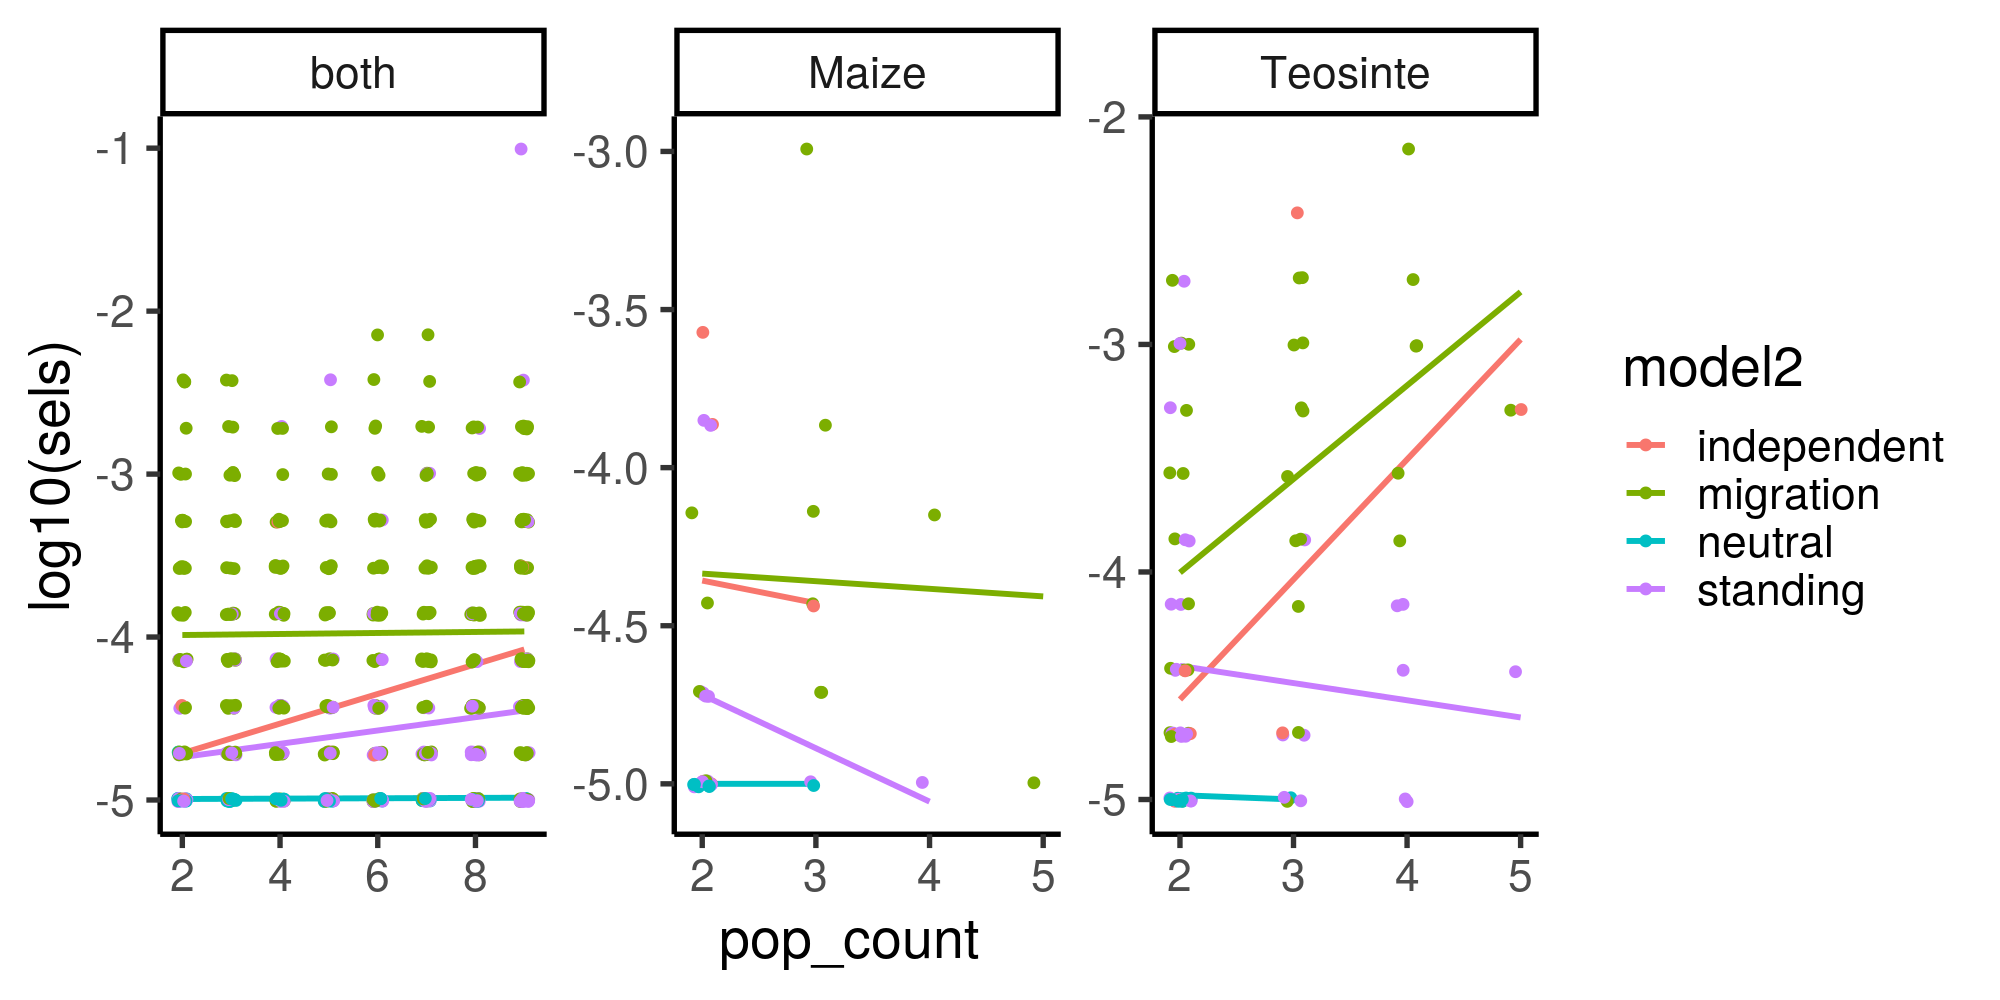

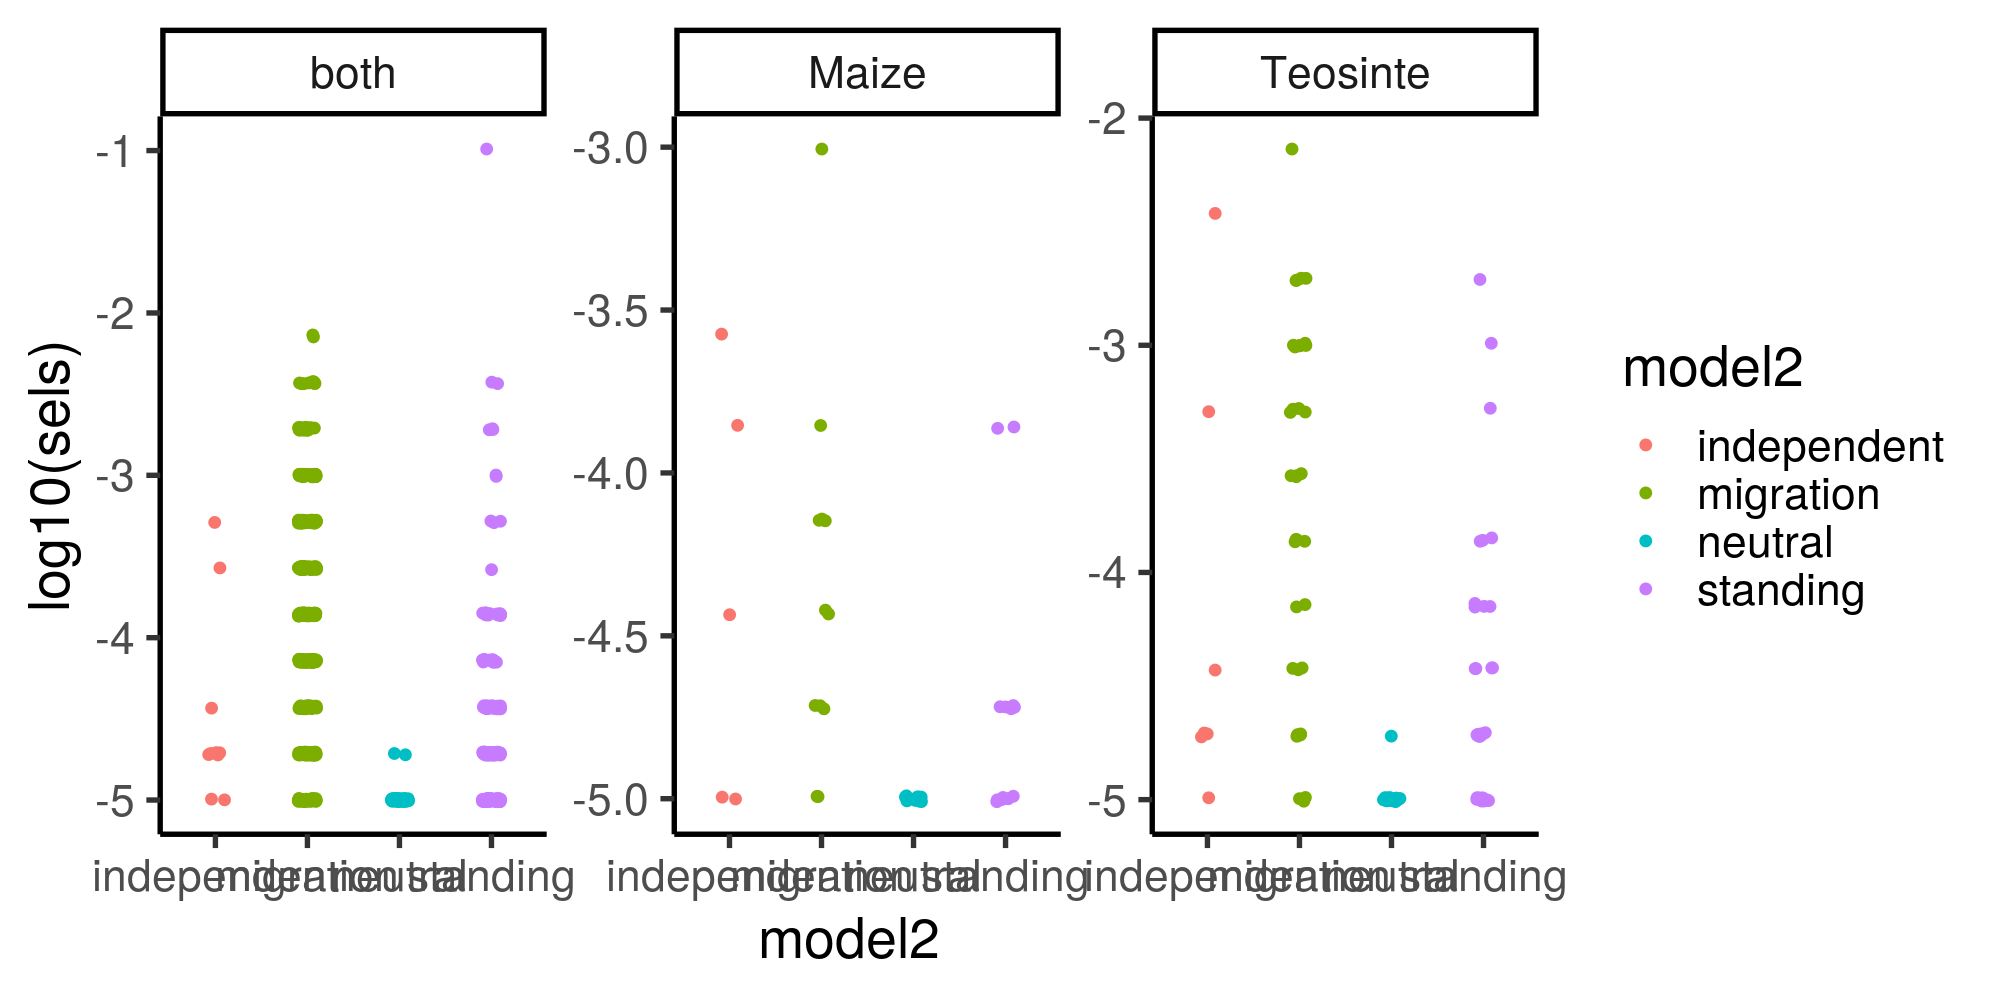

In [58]:
top_models_df %>%
    ggplot(aes(pop_count, log10(sels), colour = model2)) +
    geom_smooth(method = "lm", se = F) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")


top_models_df %>%
    ggplot(aes(model2, log10(sels), colour = model2)) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")

Warning message in cor.test.default(top_models_df$sweepsize_cM, top_models_df$n_snps, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  top_models_df$sweepsize_cM and top_models_df$n_snps
S = 29025643, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7435711 


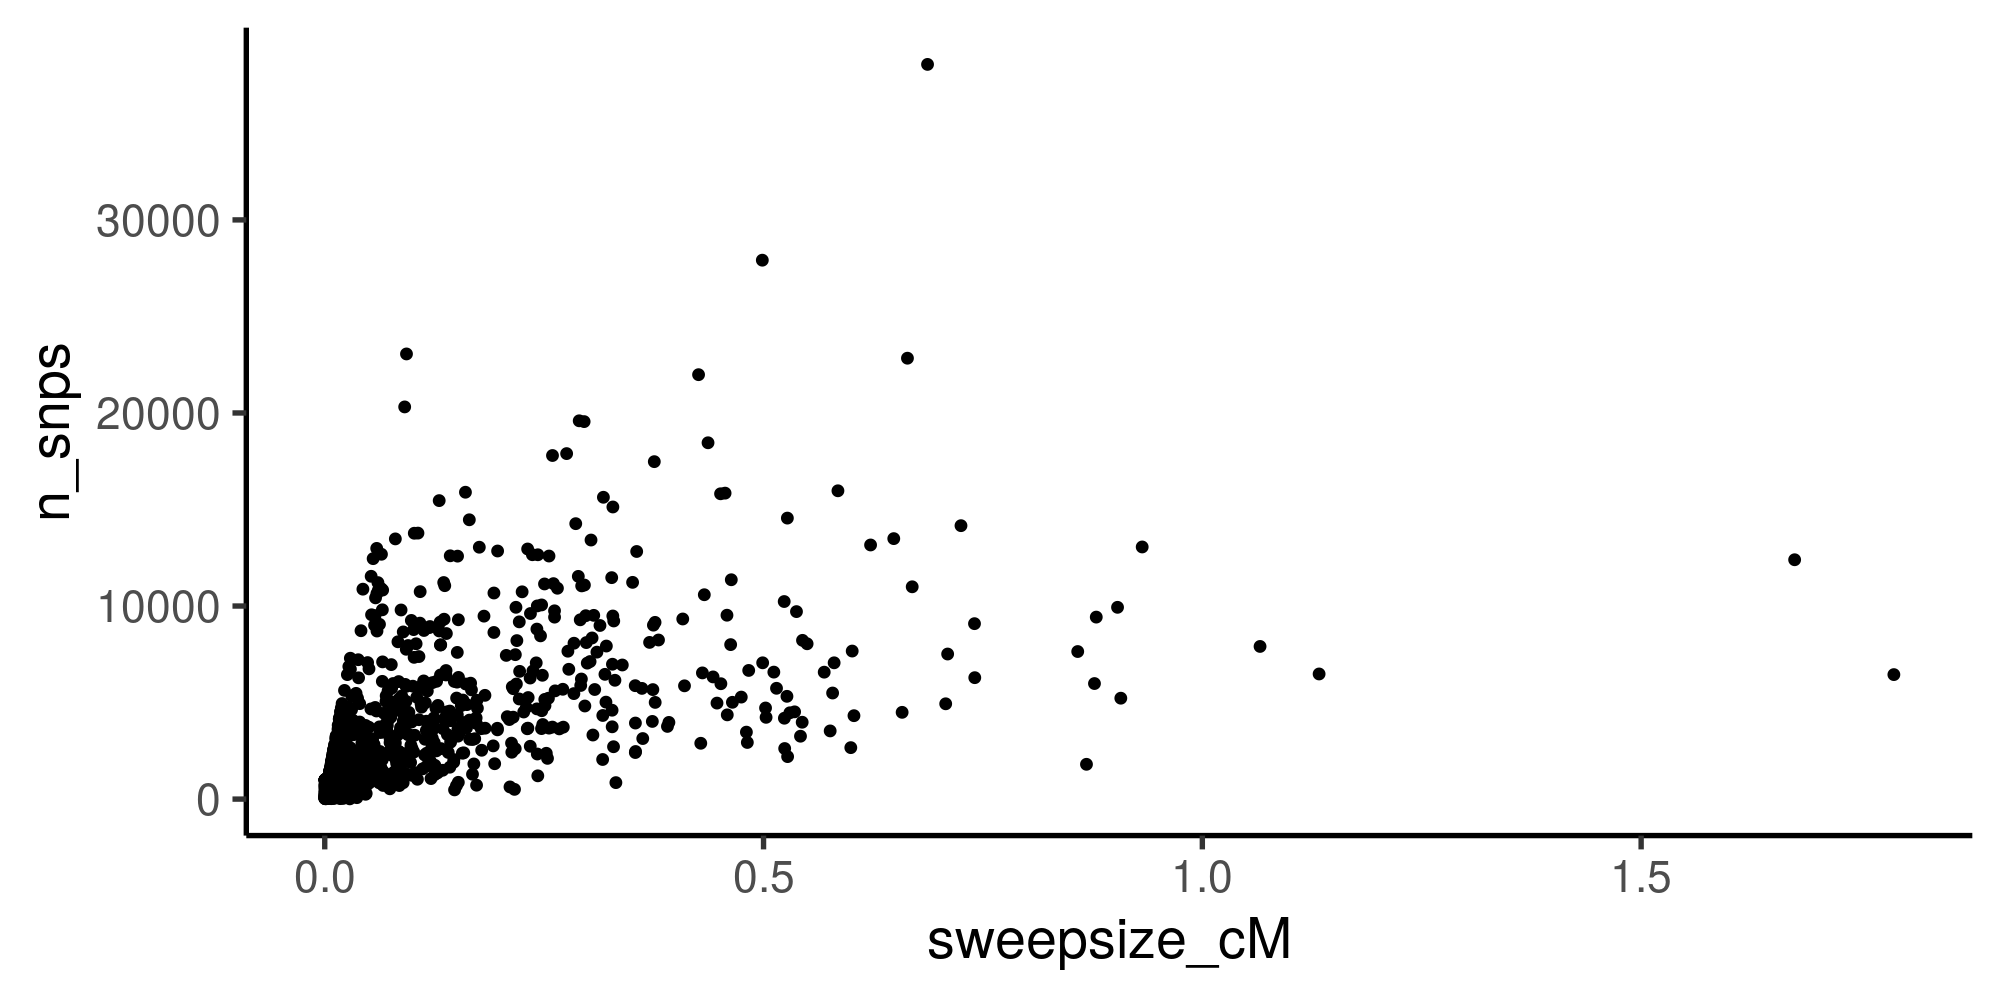

In [59]:
top_models_df %>% 
    ggplot(aes(sweepsize_cM, n_snps)) +
    geom_point()
    #geom_hline(yintercept = c(1e3, 1e4))

cor.test(top_models_df$sweepsize_cM, top_models_df$n_snps, method = "spear")

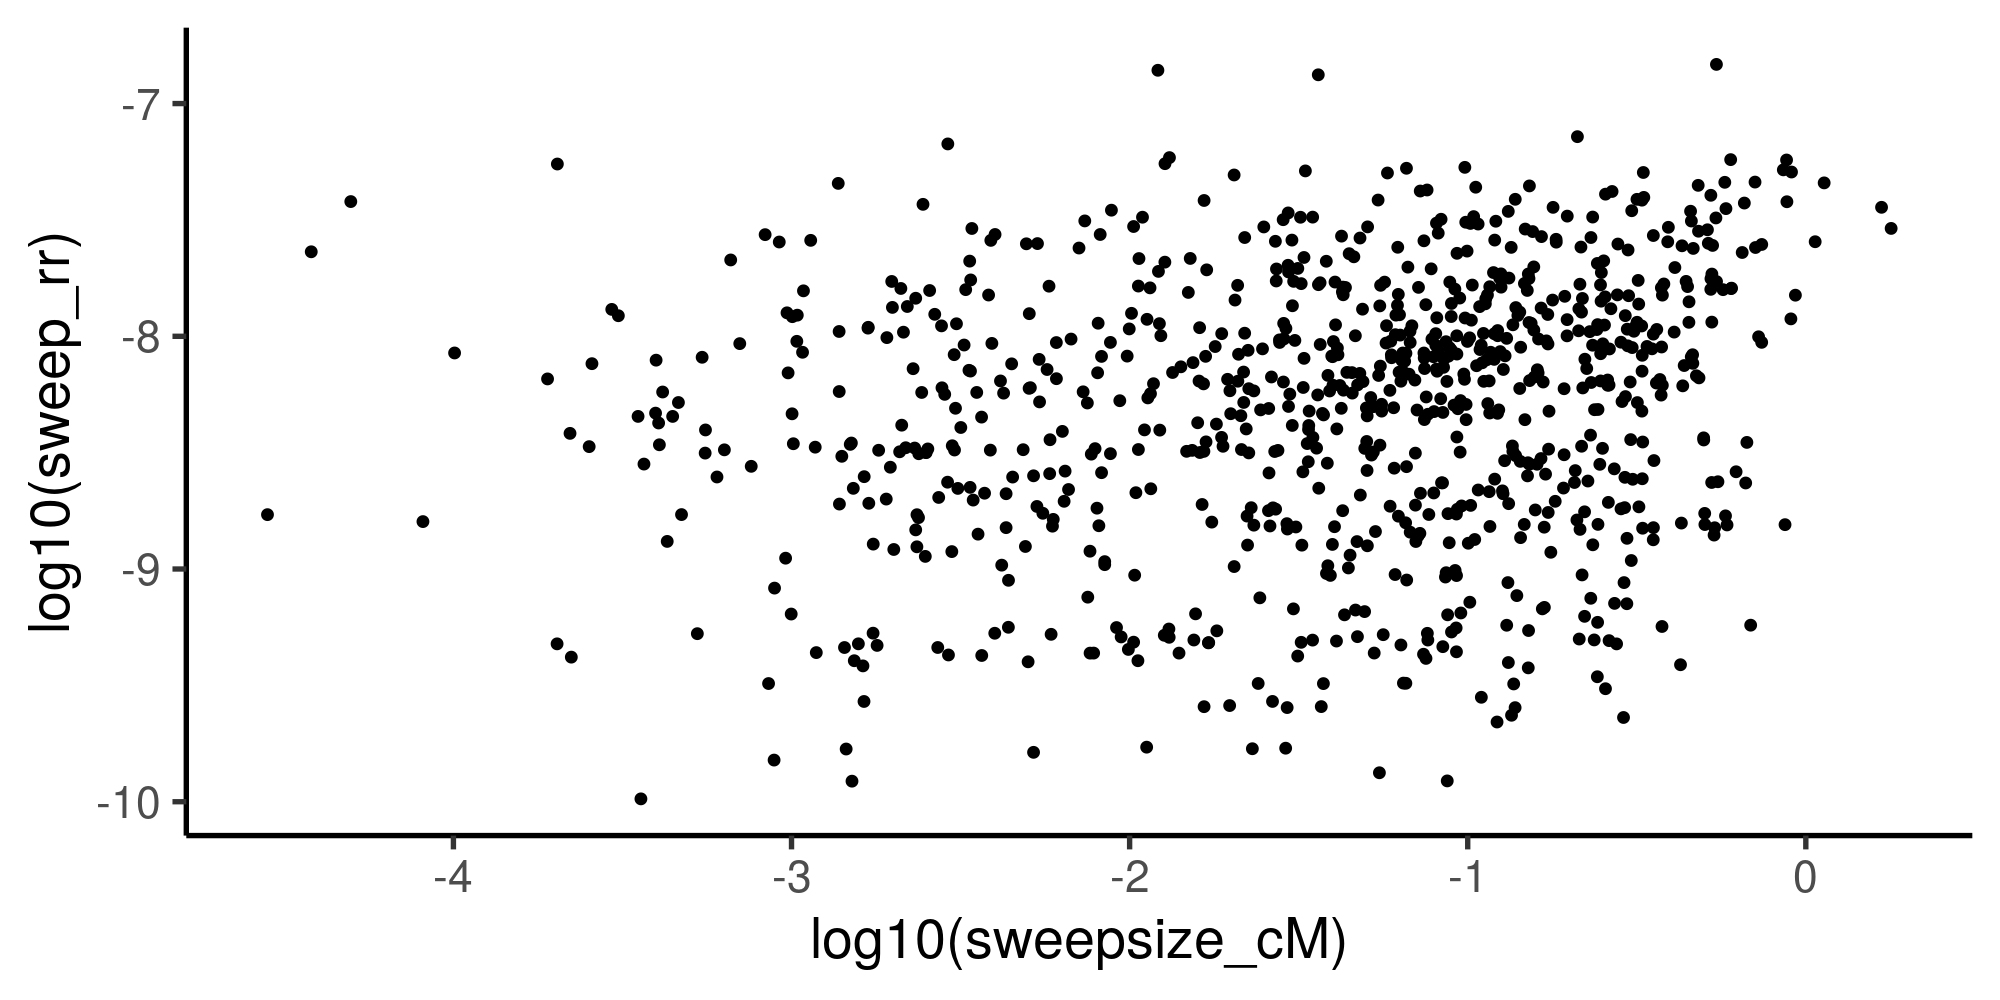

In [60]:
top_models_df %>% 
    ggplot(aes(log10(sweepsize_cM), log10(sweep_rr))) +
    geom_point()

[1] 9

[1] "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start72486304_end72896084_pops1-2-3-4-5-6-7-8-9.txt"   
[2] "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start83278927_end83836729_pops1-2-3-4-5-6-7-8-9.txt"   
[3] "../data/rdmc/fitted/v5--sweep_chr10--0--152435371_start73315446_end73842938_pops1-2-3-4-5-6-8-9-11.txt" 
[4] "../data/rdmc/fitted/v5--sweep_chr2--0--243675191_start203036051_end203259102_pops2-4-6-7-9-10-11.txt"   
[5] "../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start164816173_end165390221_pops5-6-7-9-10-11.txt"     
[6] "../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start160773266_end161464756_pops1-2-3-4-5-7-8-9-11.txt"
[7] "../data/rdmc/fitted/v5--sweep_chr6--0--181357234_start172282471_end172581475_pops3-6-7.txt"             
[8] "../data/rdmc/fitted/v5--sweep_chr6--0--181357234_start67886932_end68319413_pops1-2-3-4-5-7-8-9.txt"     
[9] "../data/rdmc/fitted/v5--sweep_chr8--0--182411202_start72379970_end72548540_pops1-7-9-11.txt"

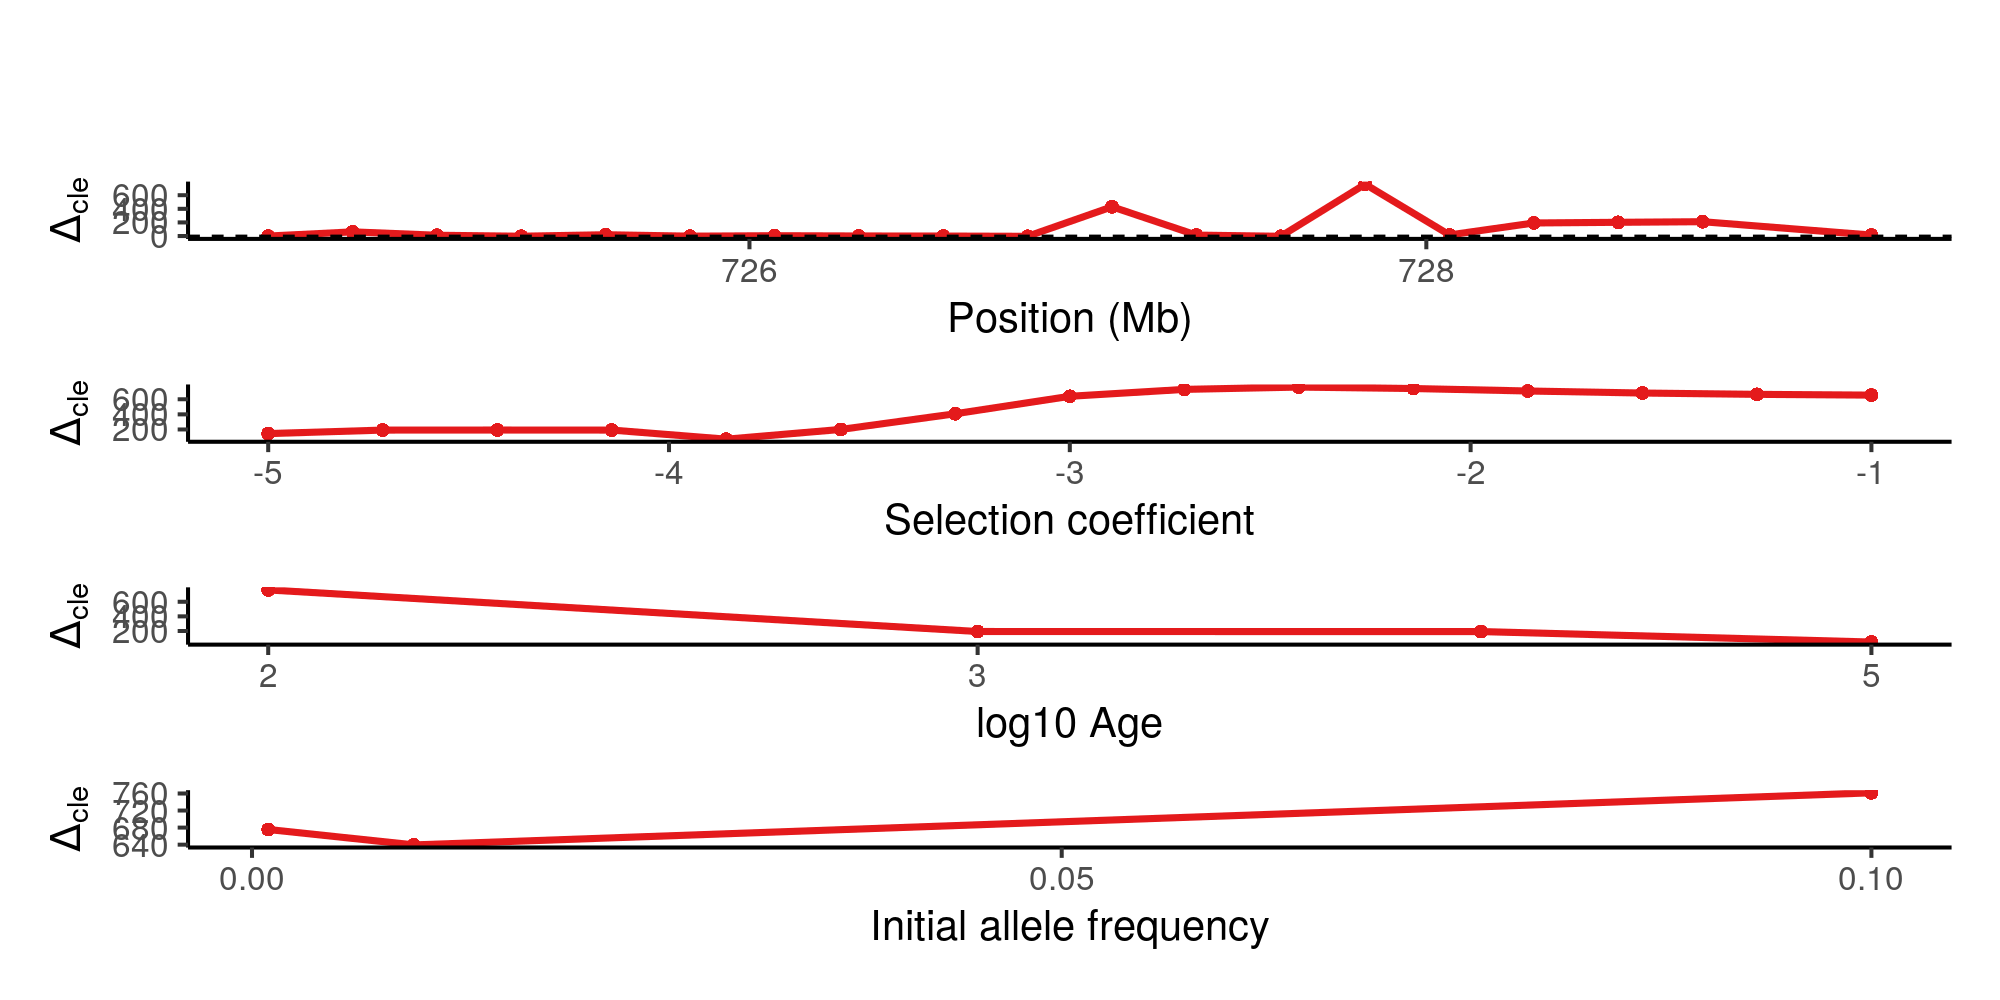

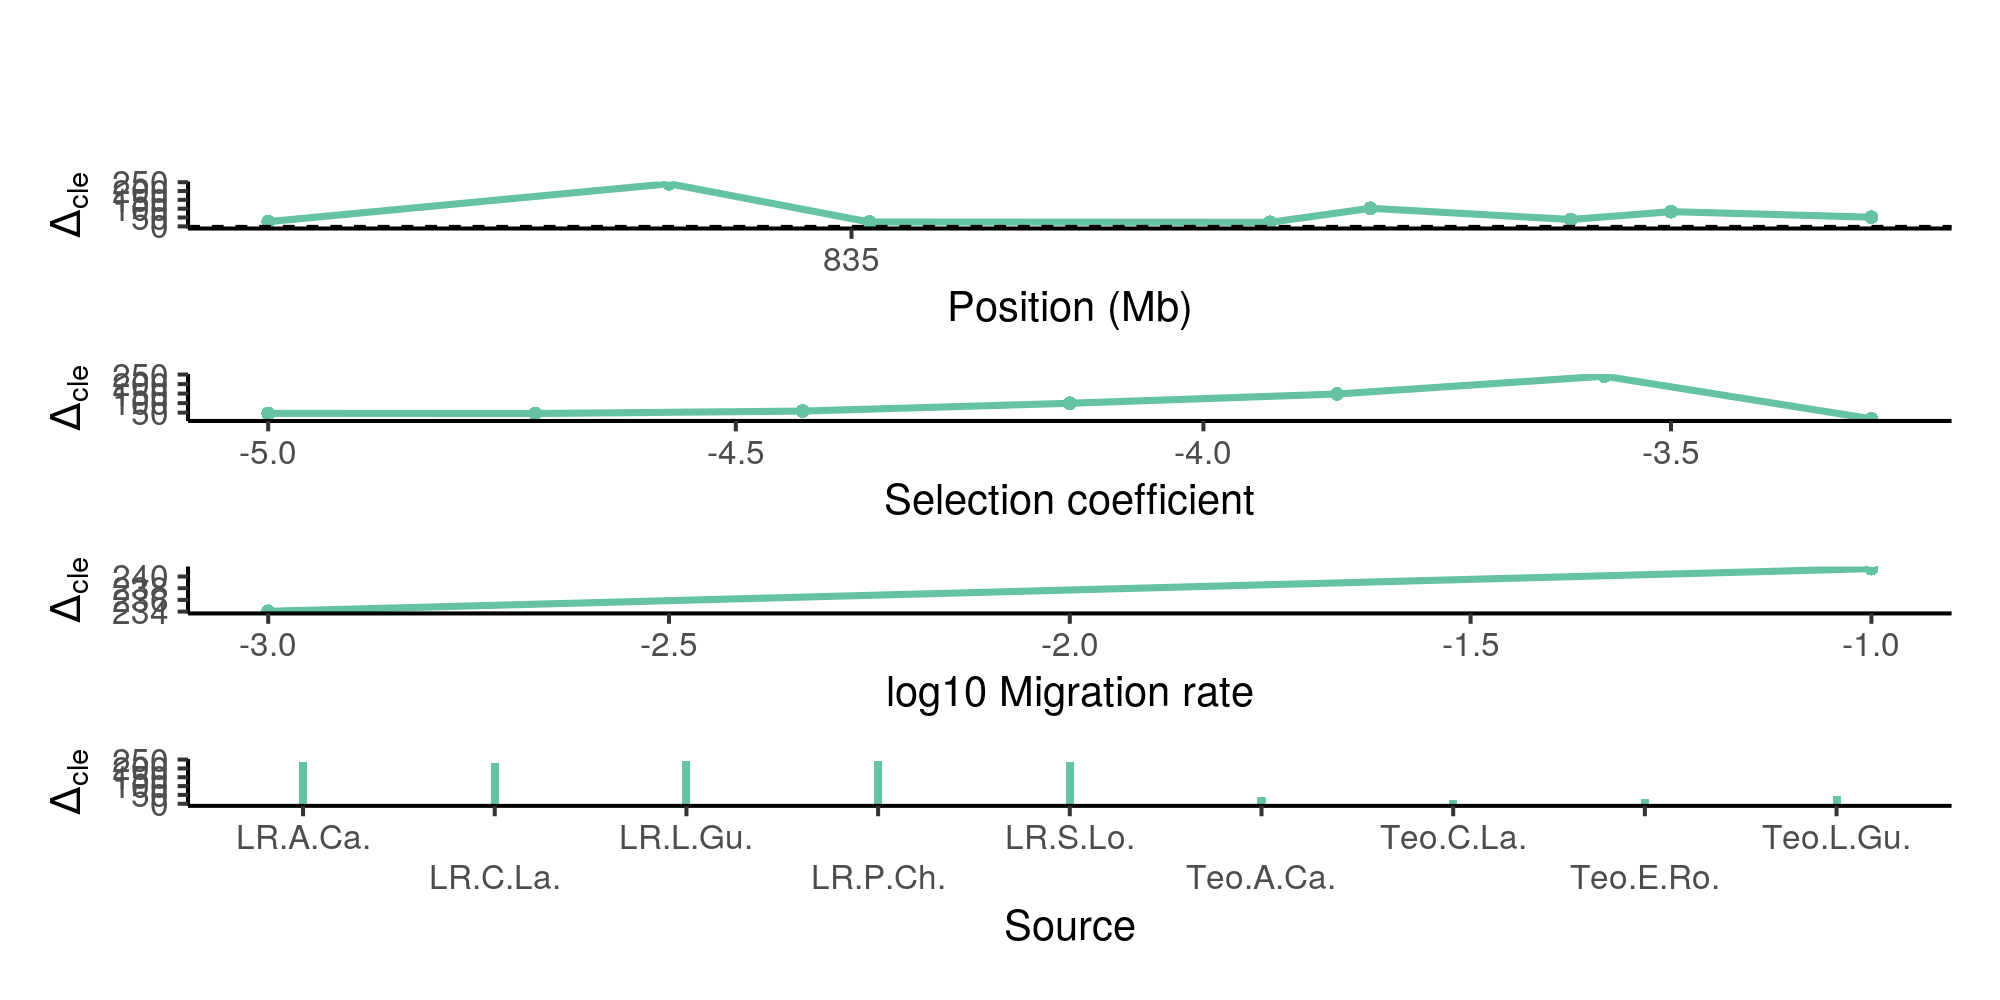

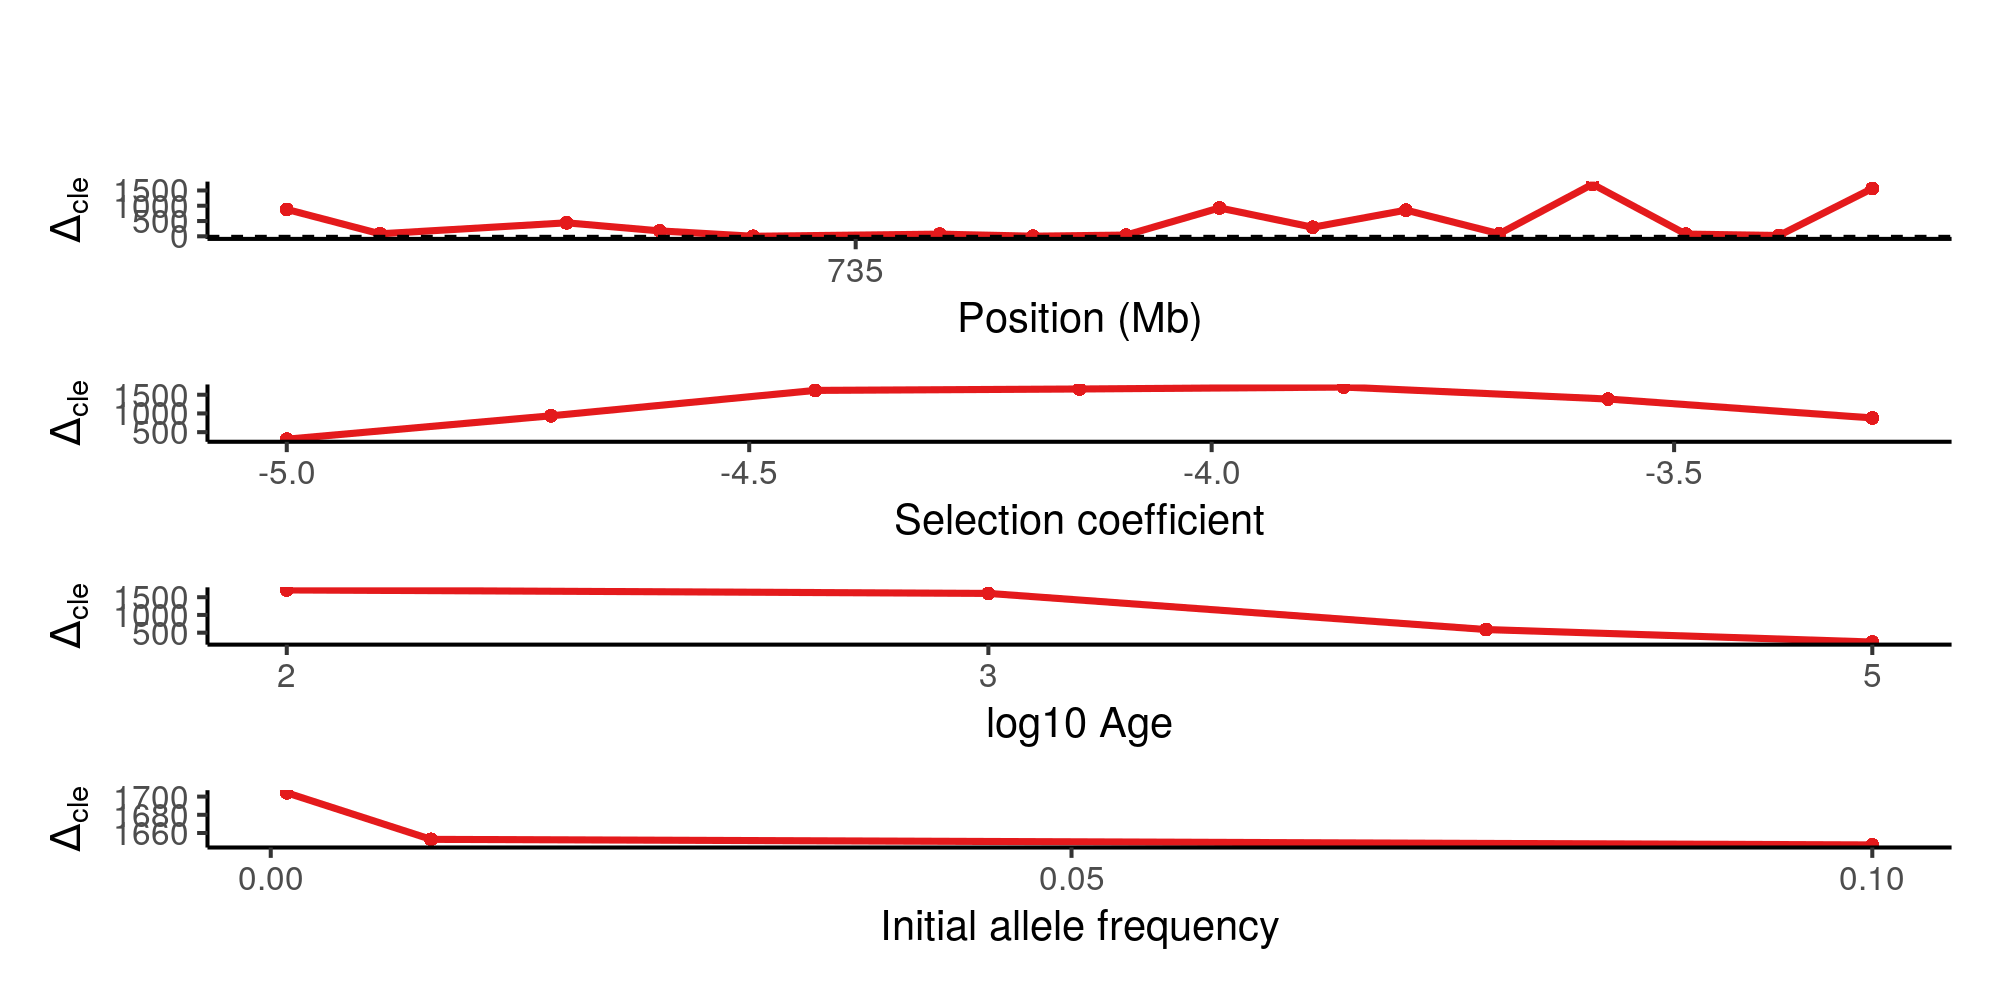

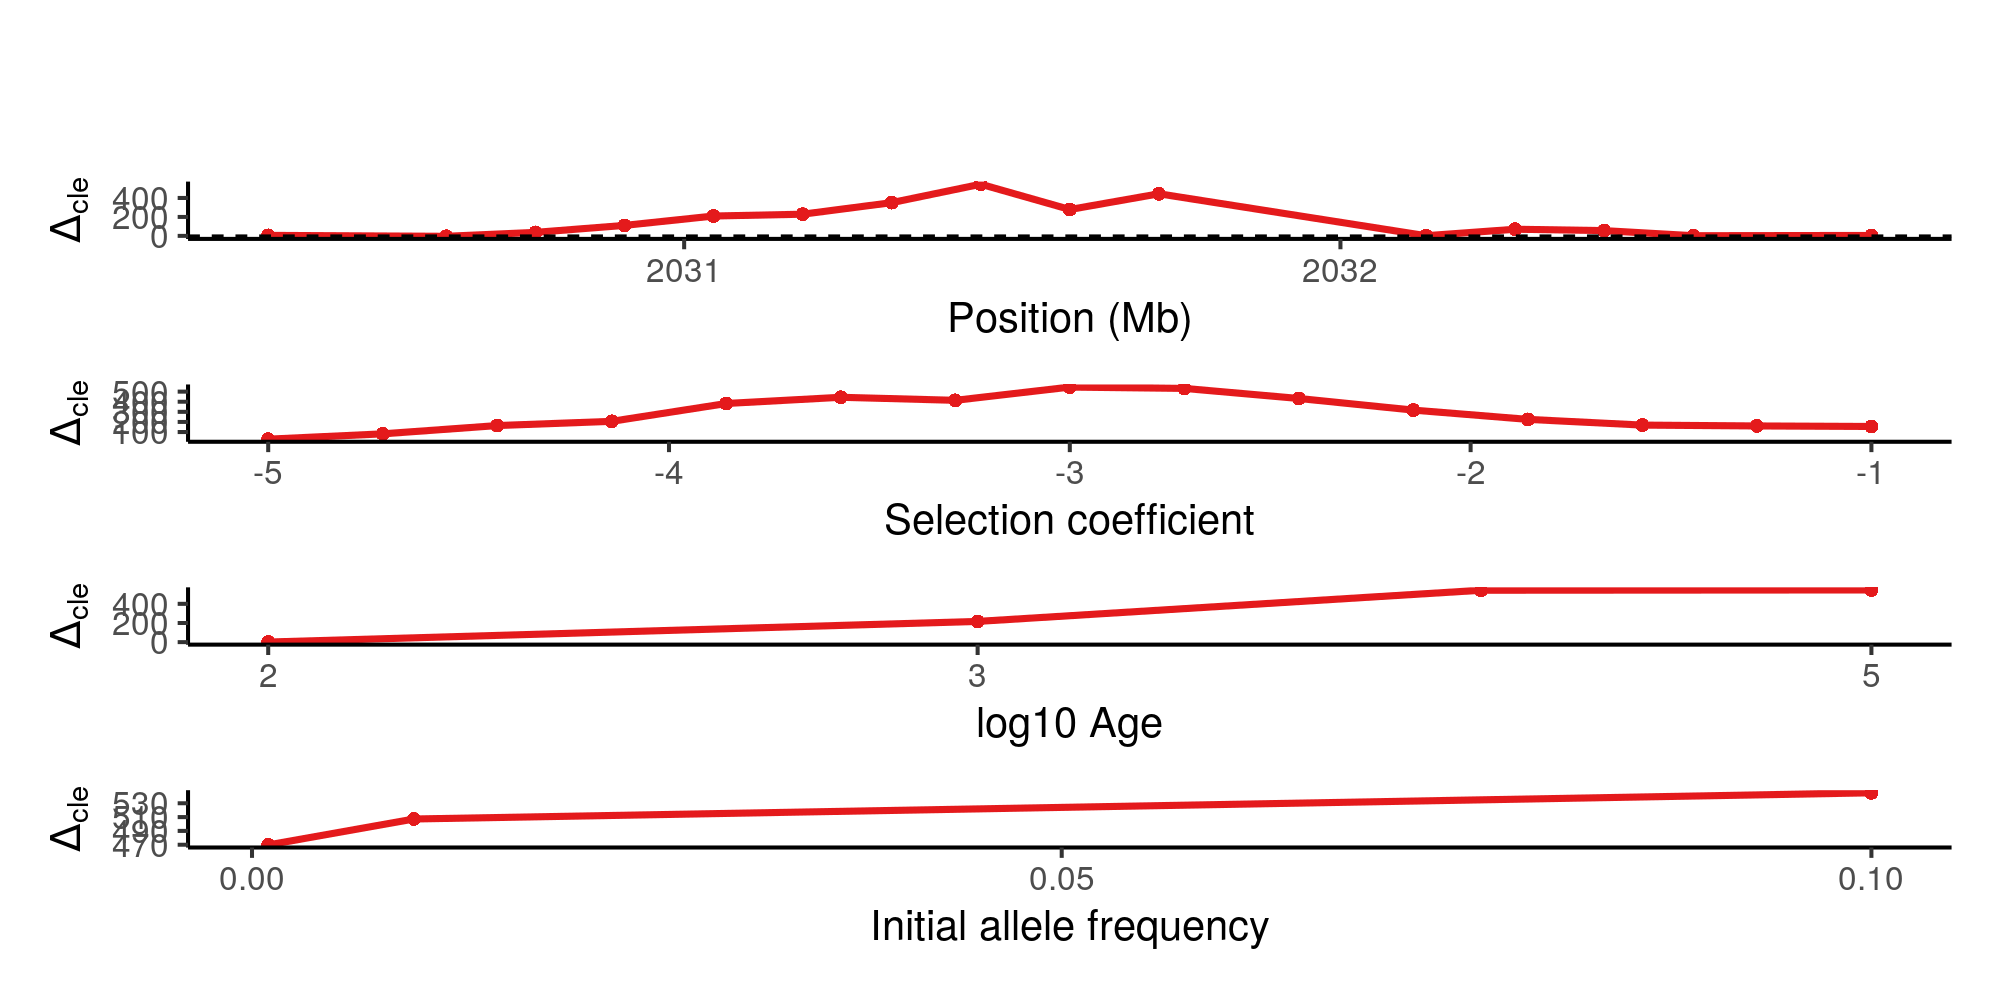

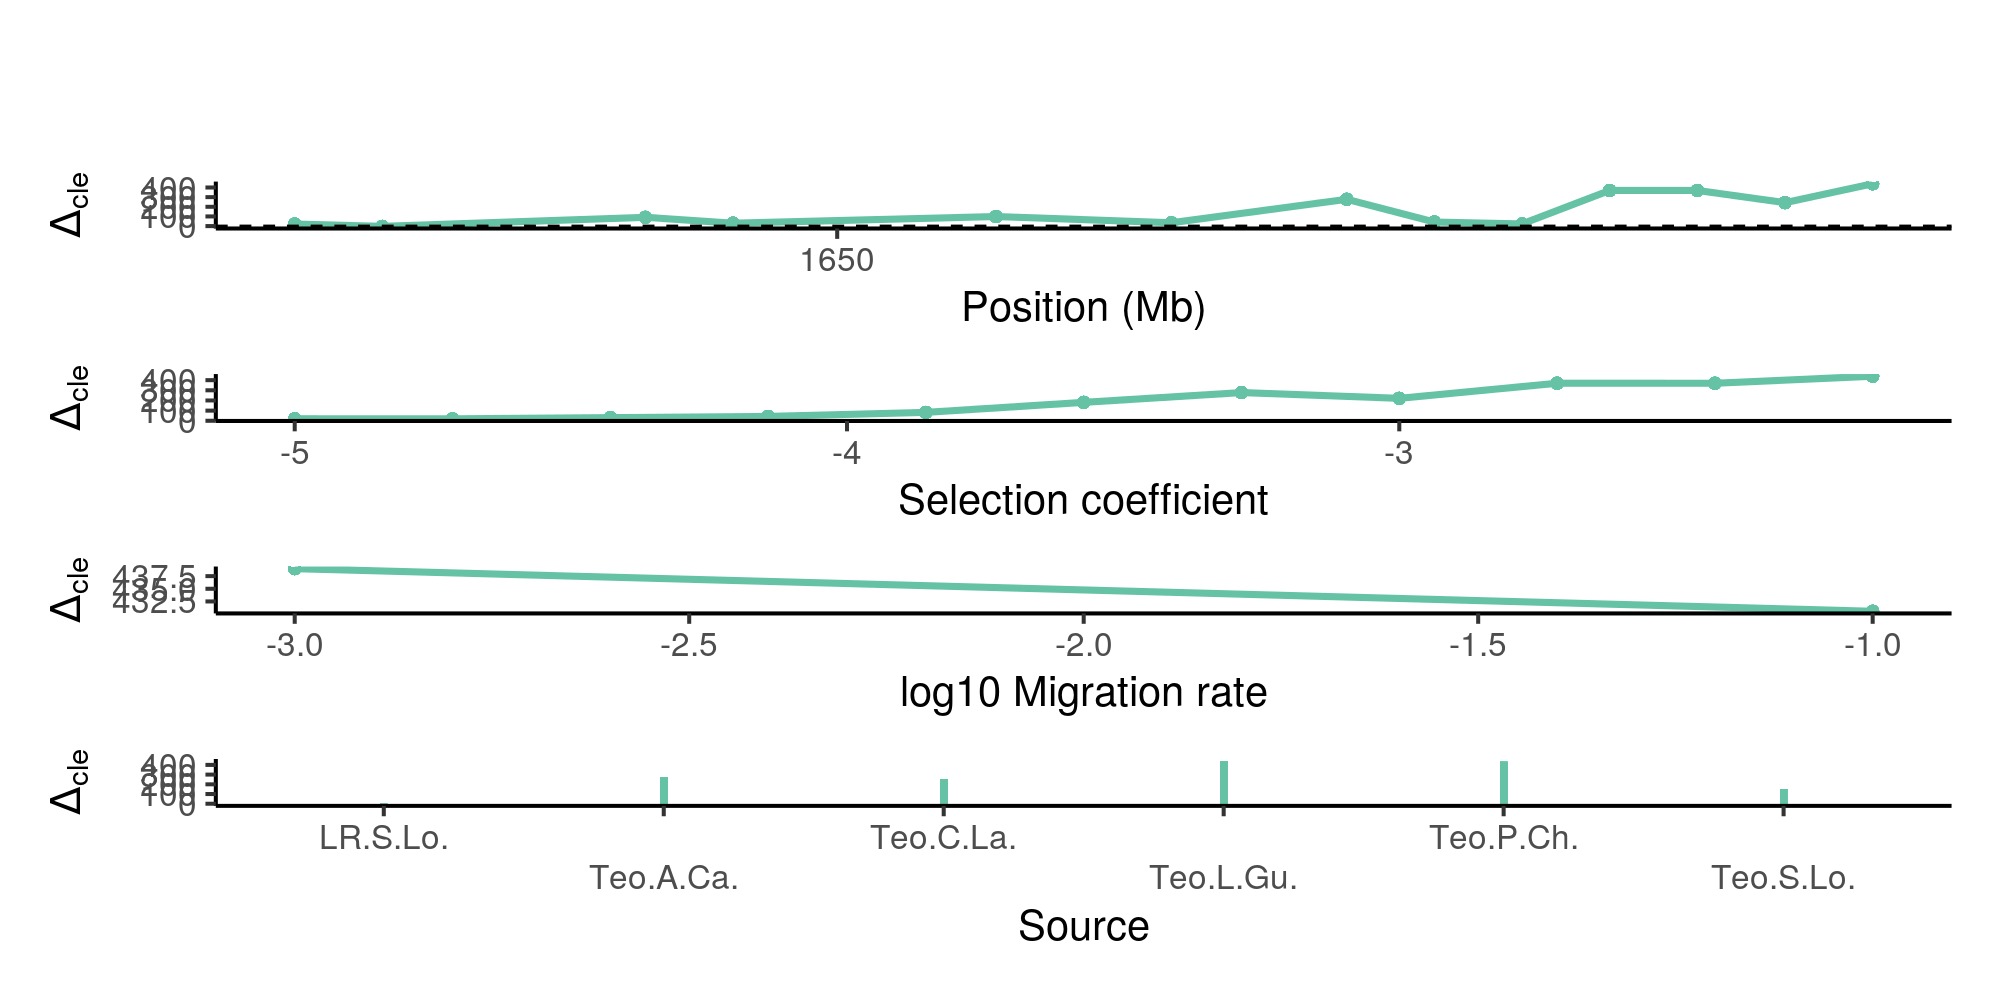

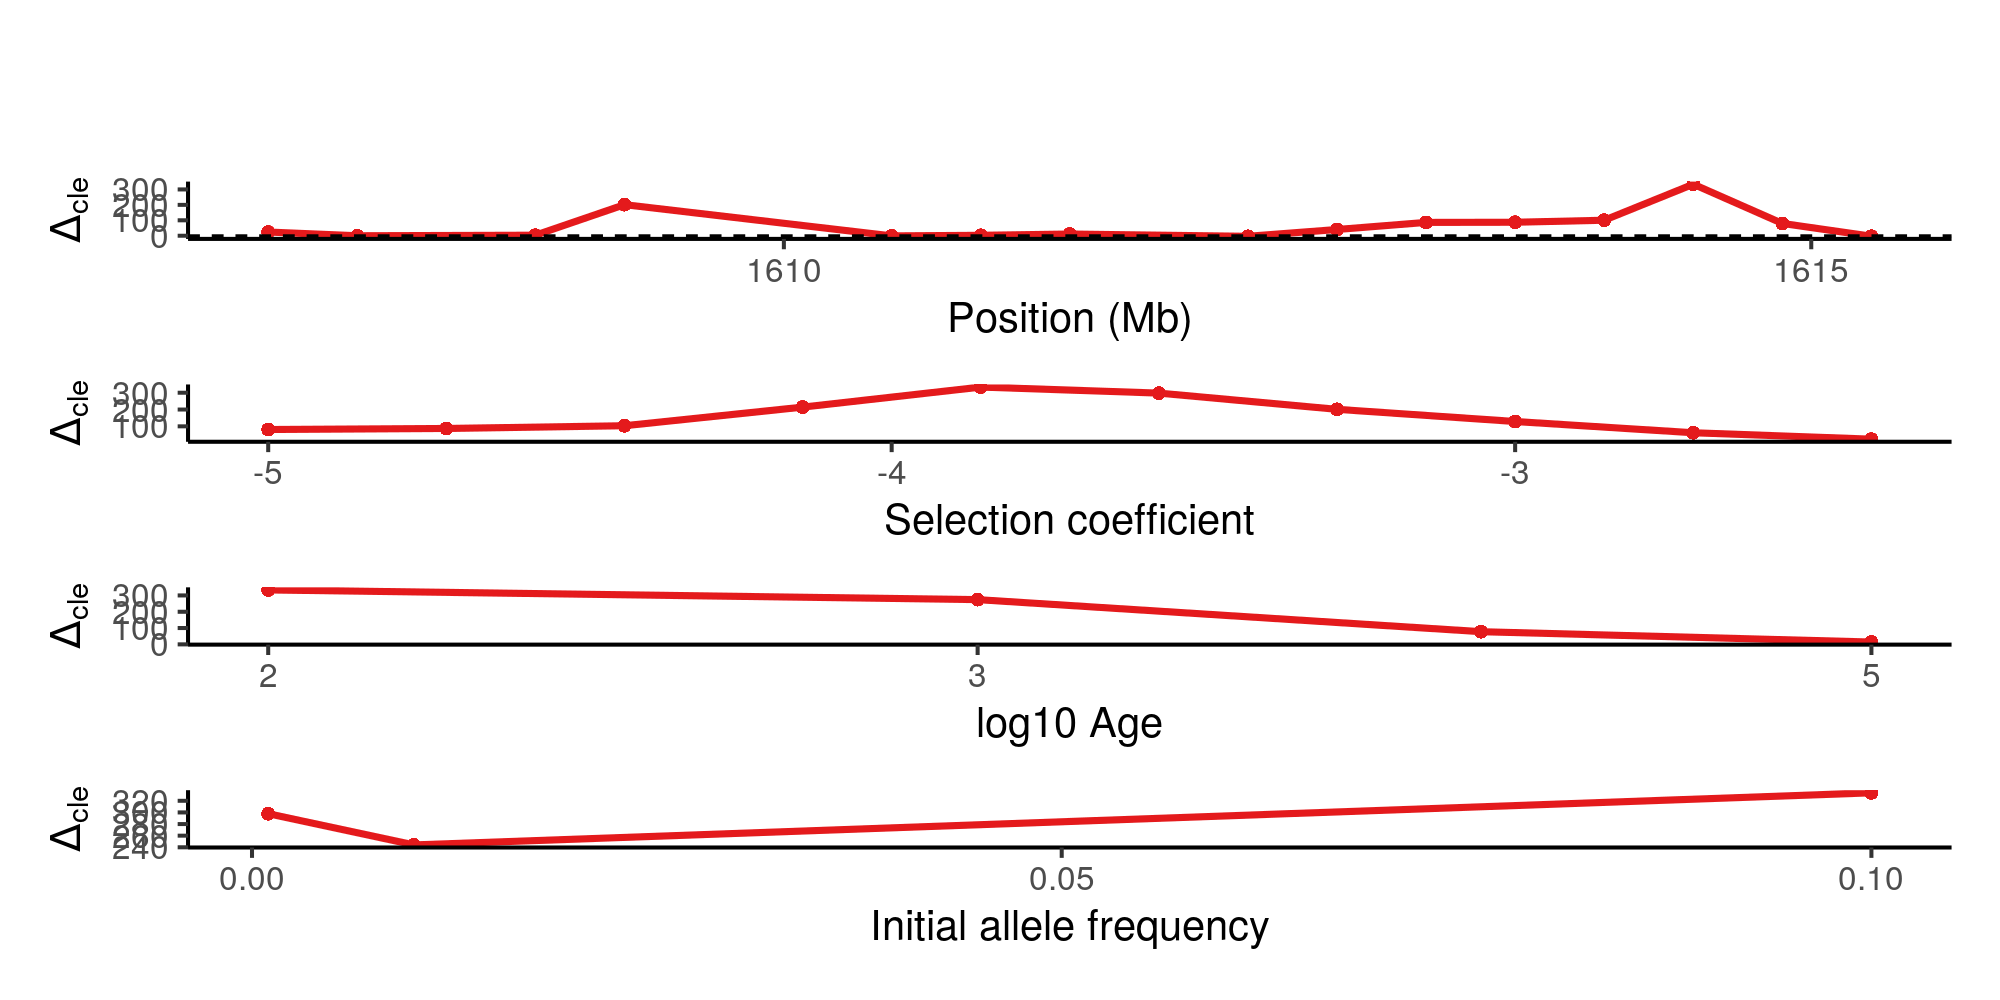

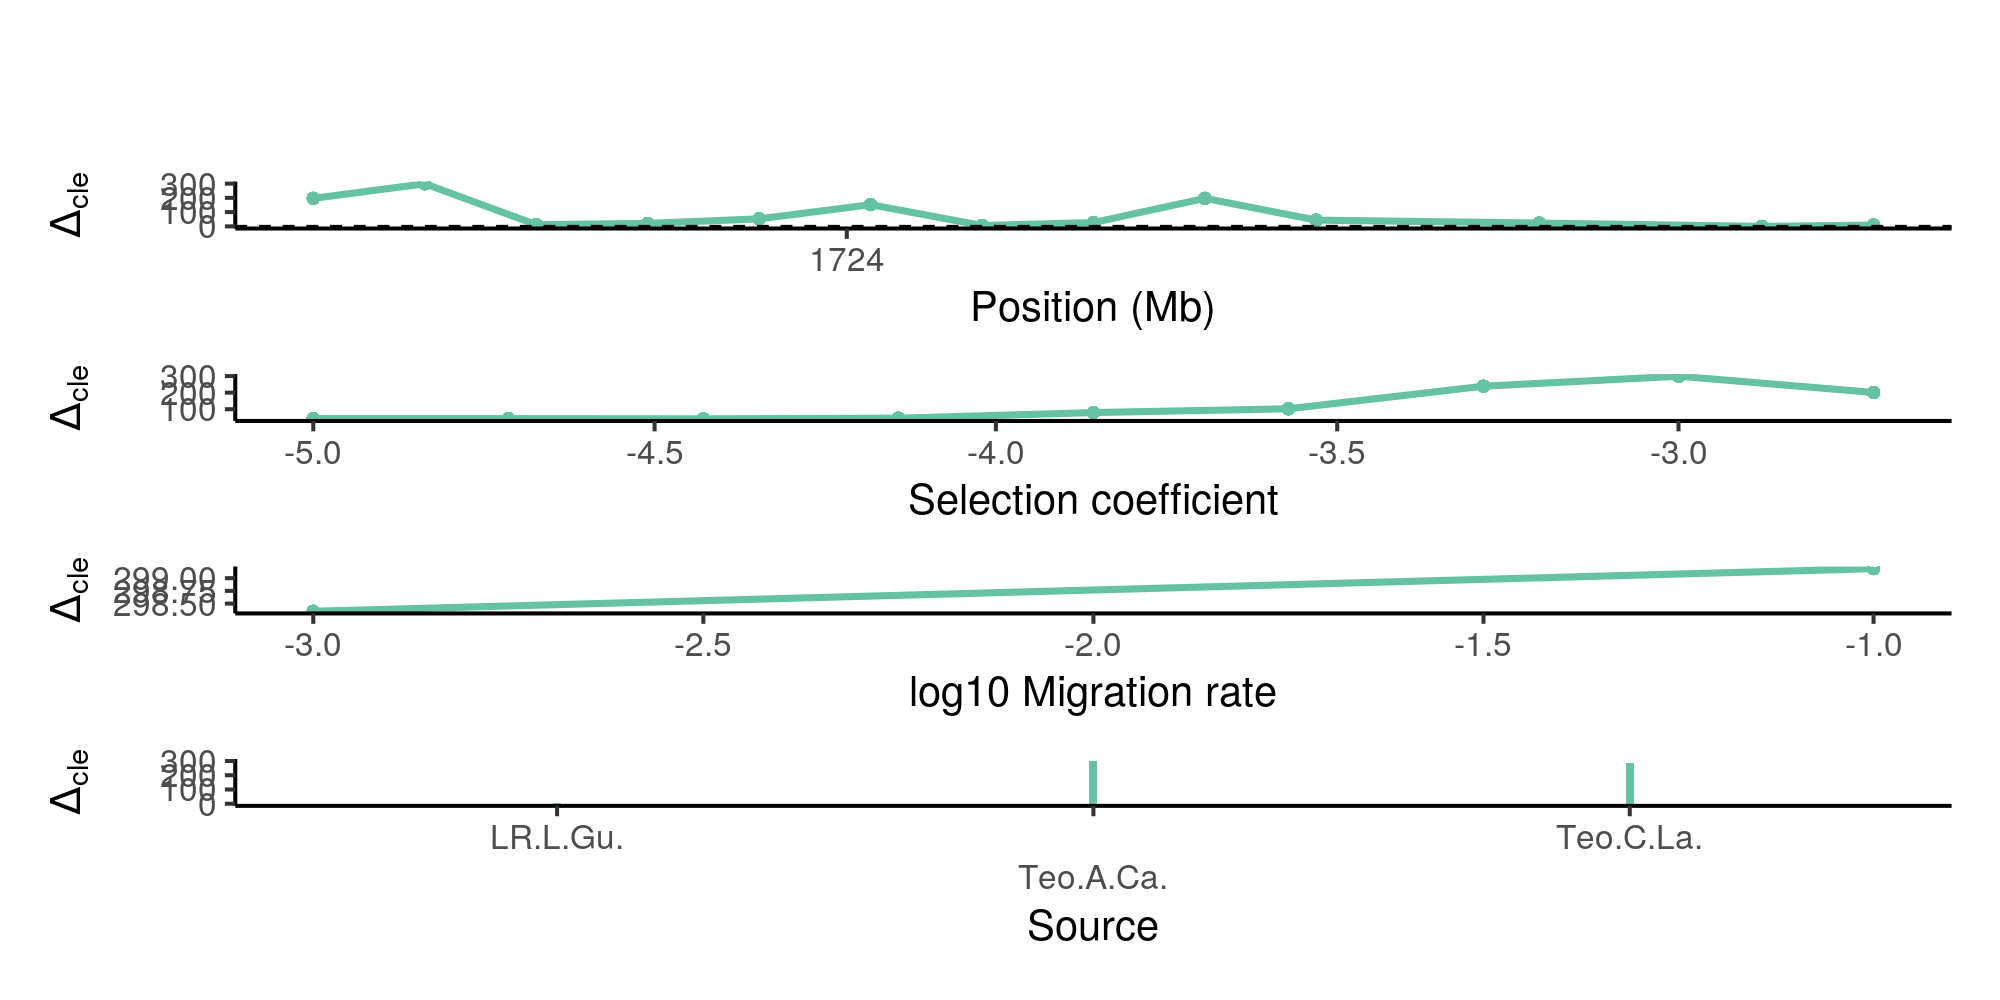

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]


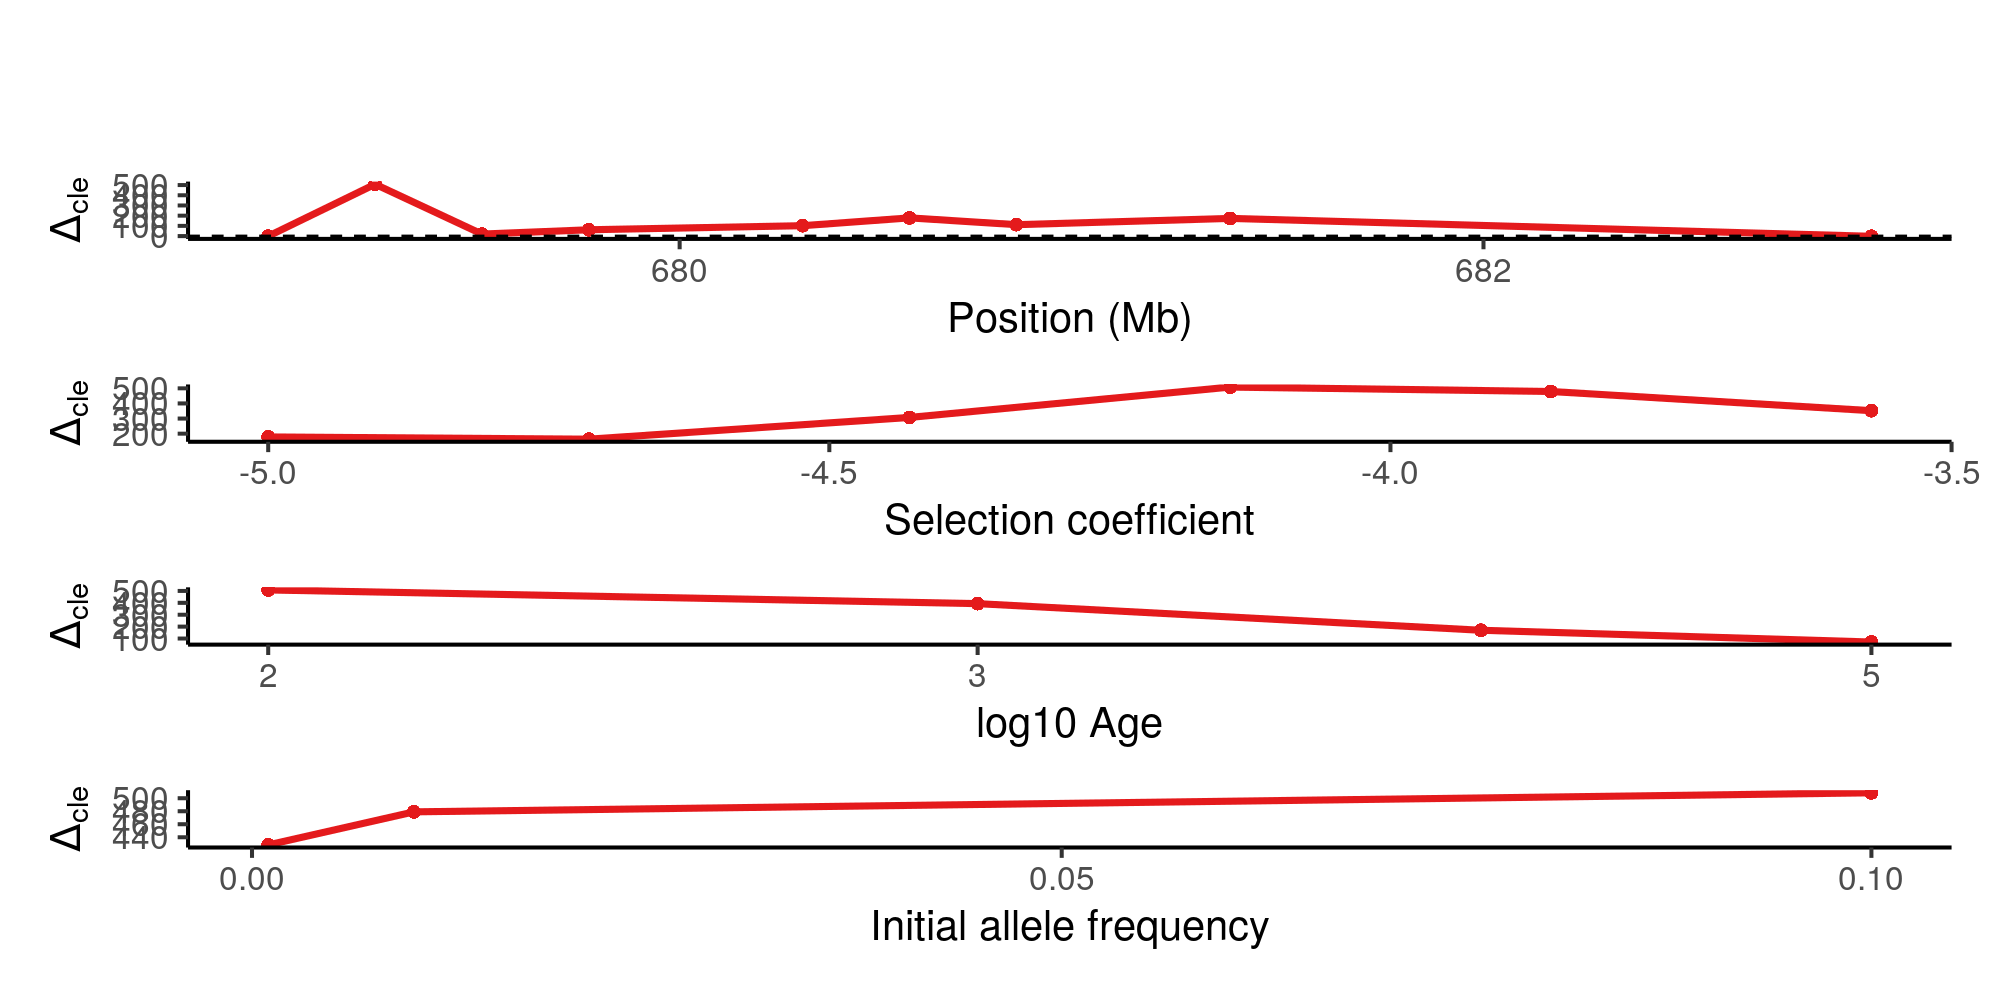

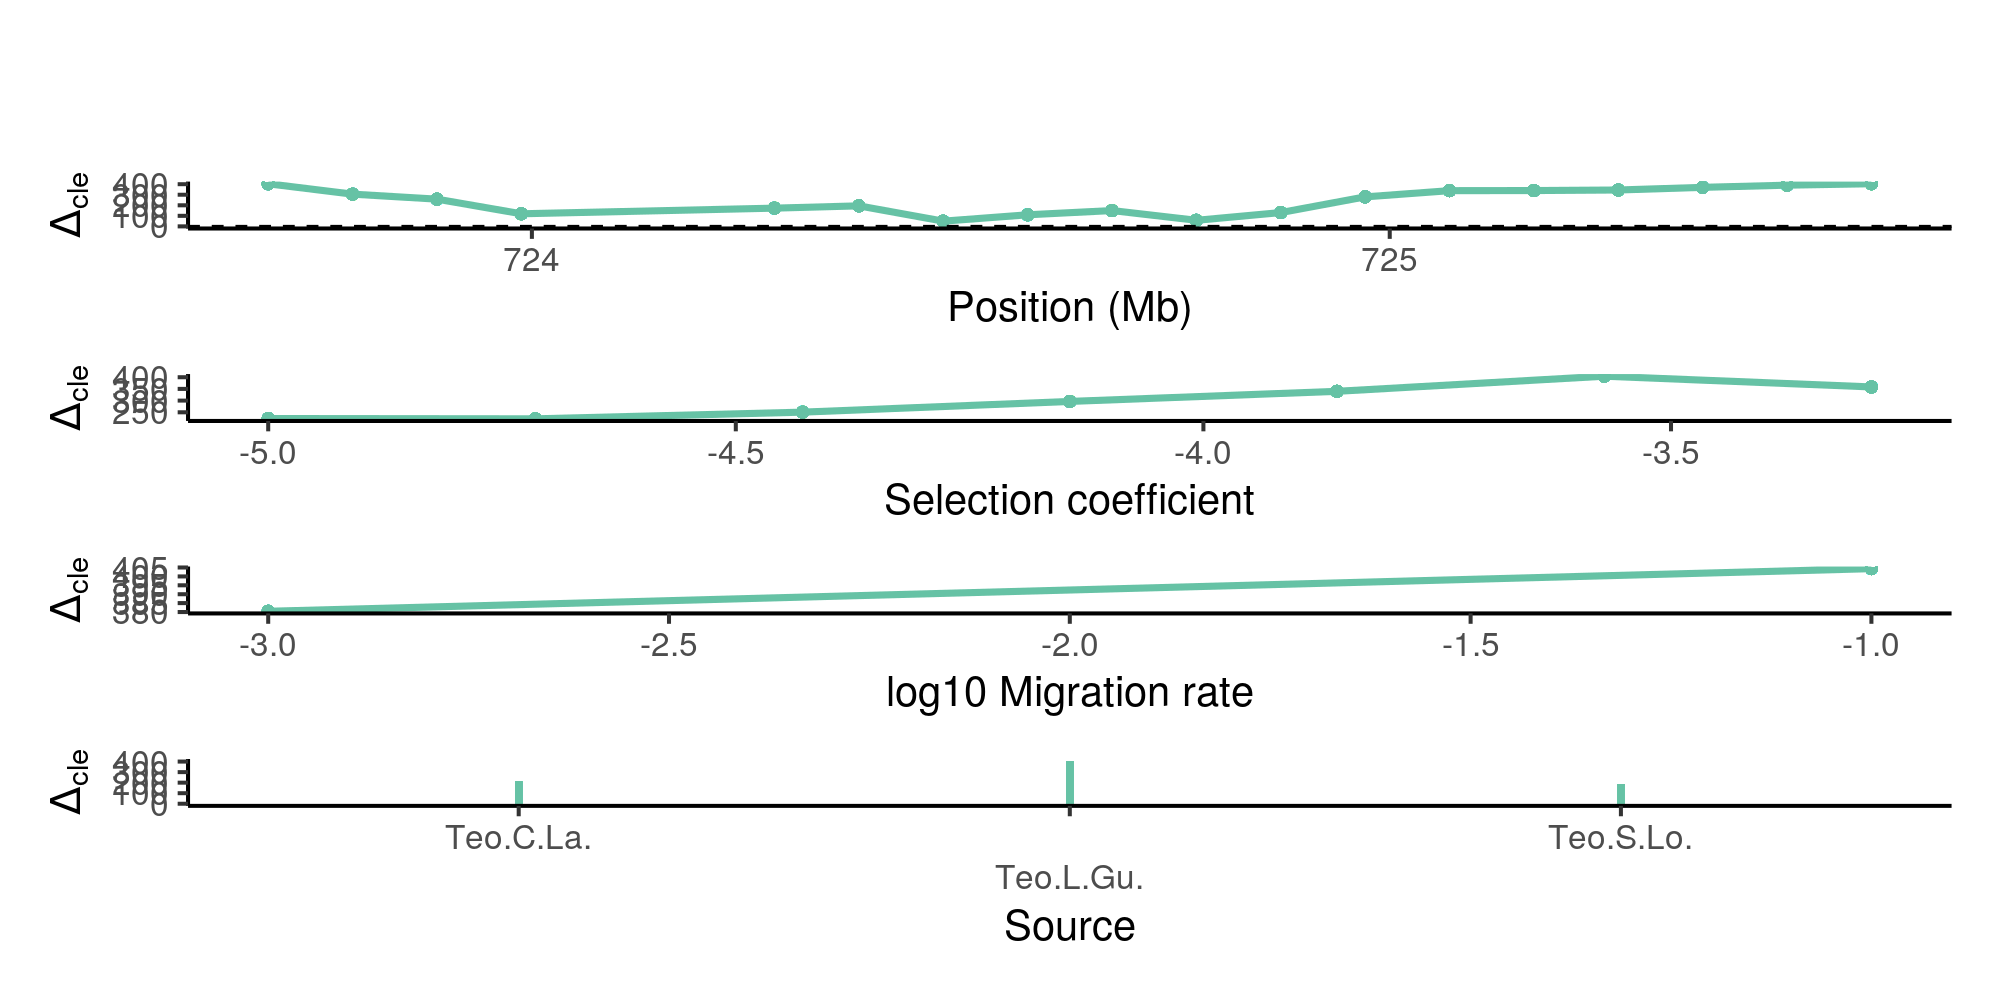

In [61]:

lr_files <- top_models_df %>% filter(model2 != "neutral", sel_pops == "1-2-3-4-5", mcle > 10) %>% pull(file_name)

q_high <- quantile(top_models_df$mcle, 0.99)
top_files <- top_models_df %>% filter(model2 != "neutral", mcle > q_high) %>% pull(file_name)
length(top_files)
top_files
suppressMessages(map(top_files, ~ plot_rdmc(.x, cle_low = -5)))

`summarise()` has grouped output by 'pop_count', 'times'. You can override using the `.groups` argument.



selected_sites sels         cle       
1 102655142      1.000000e-05 73885.8141
2 104040975      3.727594e-05 72758.8410
3 104452776      7.196857e-05 71629.4157
4 109886033      3.727594e-05   457.4074
5 110448808      3.727594e-05 70688.4675
6 111230965      1.930698e-05   198.7317
  locus                                                                                                     
1 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start102515159_end102694364_pops2-7-8-9.txt            
2 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start103881882_end104125258_pops2-3-4-5-7.txt          
3 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start104183258_end104482872_pops1-3-4-5-7-8-9-10-11.txt
4 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start109871502_end109886890_pops6-8-9-10.txt           
5 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start110154827_end110481304_pops1-2-4-6-7-8-9-10.txt   
6 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start111221714_end111235985_pops9-11.txt               
  gs    times migs  sources sel_pops            model       ⋯ mcle      
1    NA    NA 0.001  9      2-7-8-9             migration   ⋯  58.247609
2 0.010 1e+05    NA NA      2-3-4-5-7           standing    ⋯  14.840120
3 0.001 1e+02    NA NA      1-3-4-5-7-8-9-10-11 standing    ⋯   5.072725
4 0.010 1e+05    NA NA      6-8-9-10            standing    ⋯   9.946702
5 0.001 1e+05    NA NA      1-2-4-6-7-8-9-10    standing    ⋯  59.720074
6    NA    NA    NA NA      9-11                independent ⋯ -13.208138
  mcle_delta mcle_nextbest_diff
1 0          57.139606         
2 0          36.493508         
3 0          50.042707         
4 0          10.262084         
5 0          75.616080         
6 0           6.729698         
  file_name                                                                                               
1 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start102515159_end102694364_pops2-7-8-9.txt            
2 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start103881882_end104125258_pops2-3-4-5-7.txt          
3 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start104183258_end104482872_pops1-3-4-5-7-8-9-10-11.txt
4 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start109871502_end109886890_pops6-8-9-10.txt           
5 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start110154827_end110481304_pops1-2-4-6-7-8-9-10.txt   
6 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start111221714_end111235985_pops9-11.txt               
  populations                                                                                                                                                                                                             
1 v5--LR--Crucero_Lagunitas; v5--Teo--Crucero_Lagunitas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes                                                                                                                           
2 v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas                                                                                            
3 v5--LR--Amatlan_de_Canas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico; v5--Teo--San_Lorenzo
4 v5--Teo--Amatlan_de_Canas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico                                                                                                                        
5 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--Teo--Amatlan_de_Canas; v5--Teo--Crucero_Lagunitas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico         
6 v5--Teo--Los_Guajes; v5--Teo--San_Lorenzo                                                                                                               

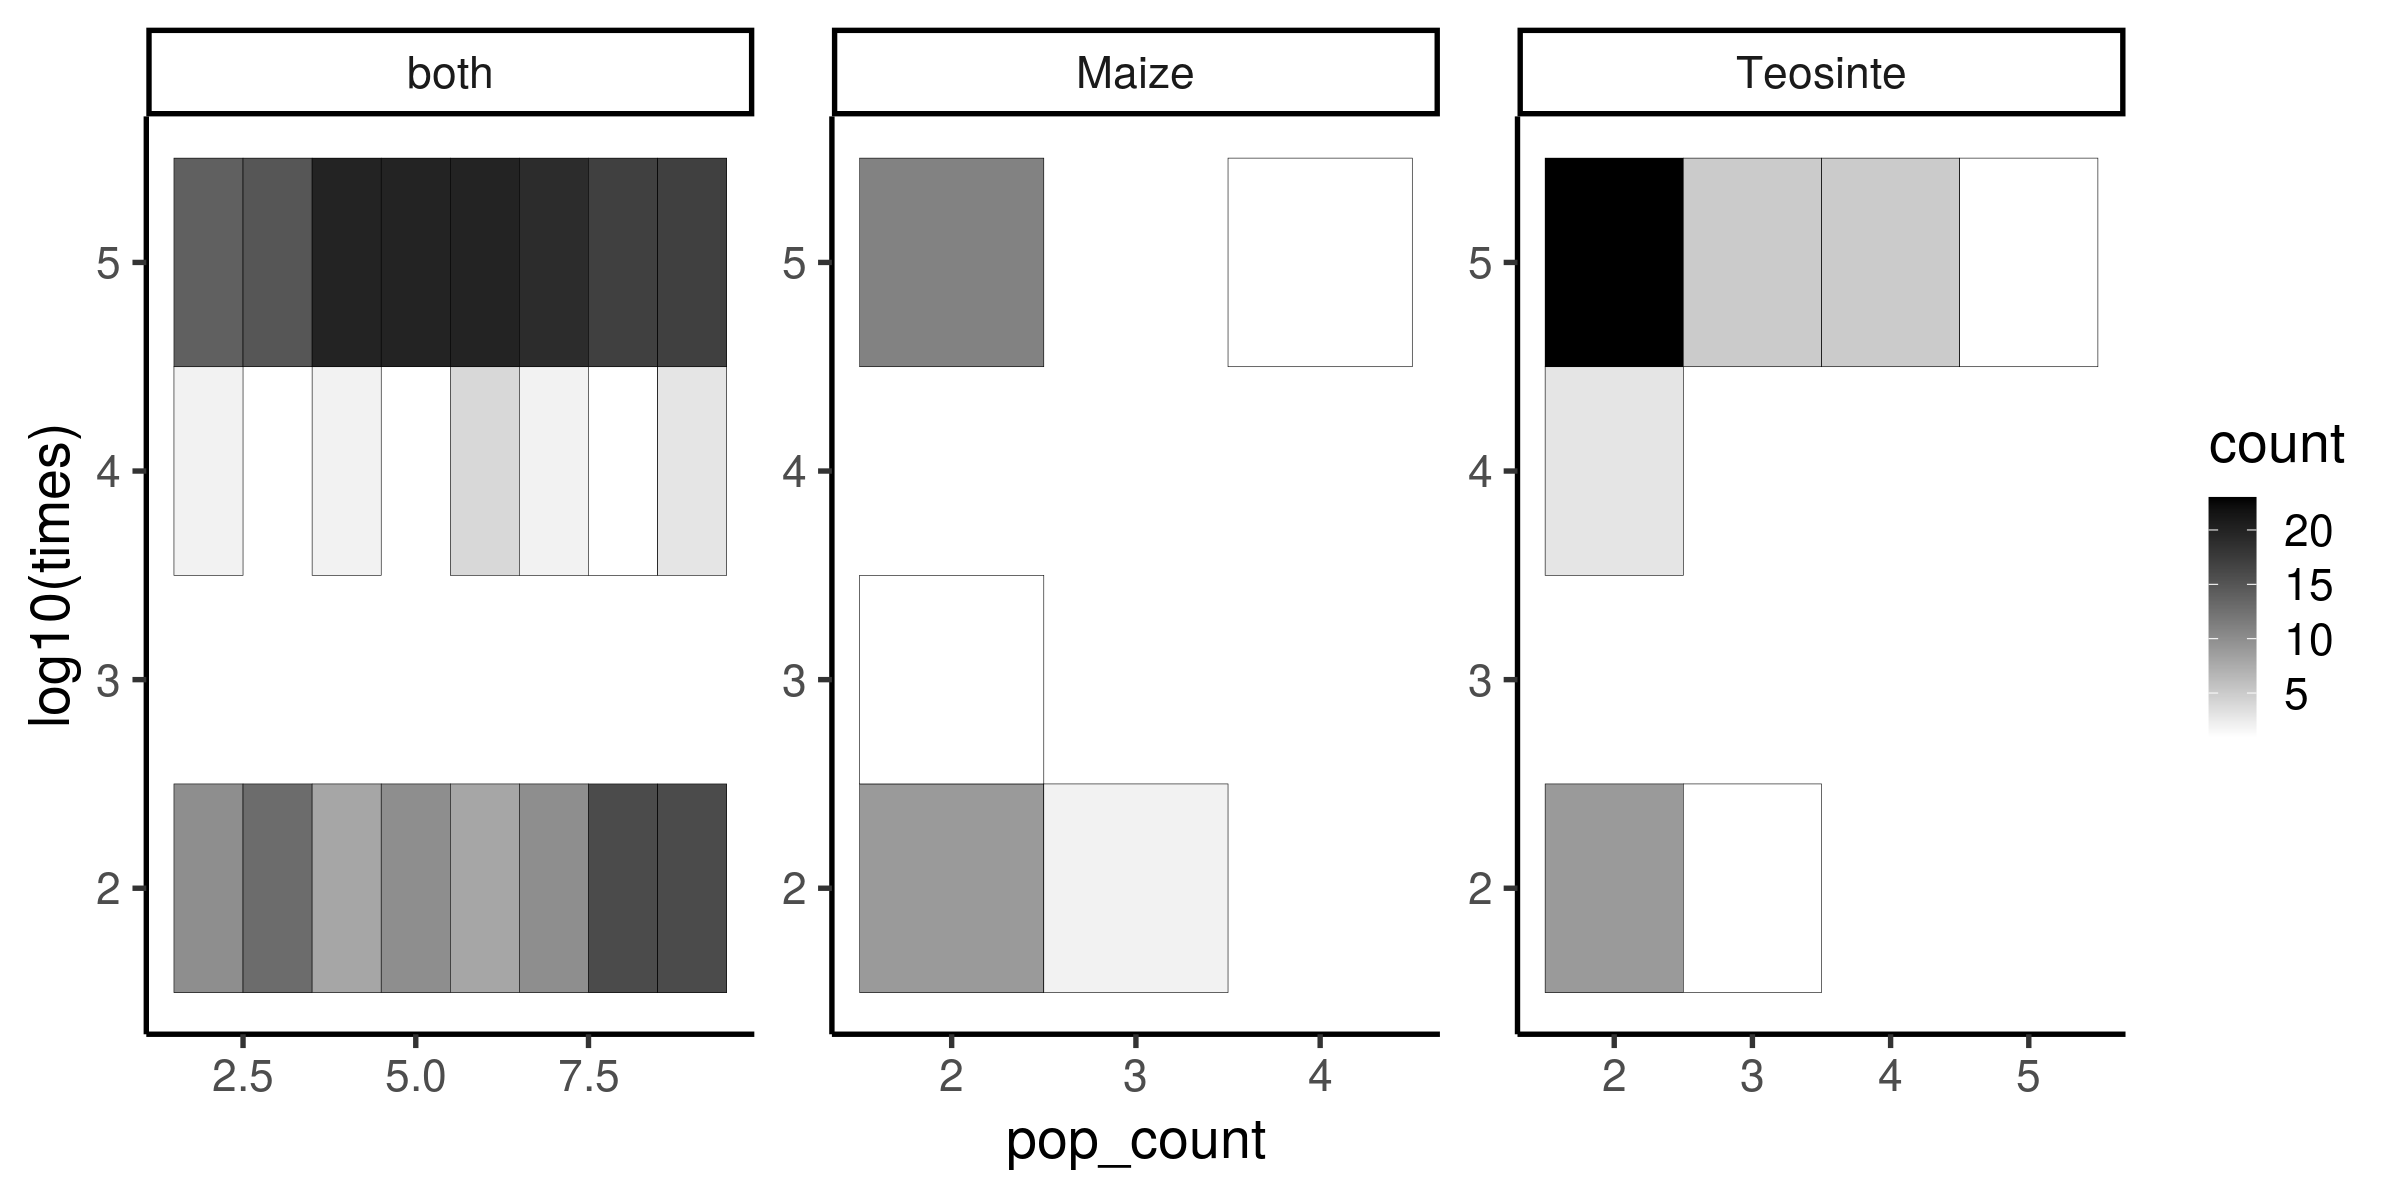

In [62]:
options(repr.plot.width = 12, repr.plot.height = 6 , repr.plot.res = 200)

top_models_df %>% 
    select(pop_count, times, type) %>% 
    drop_na() %>% 
    group_by(pop_count, times, type) %>% 
    summarise(count = n()) %>% 
    ggplot(aes(pop_count, log10(times), fill = count)) +
    geom_tile(color = "black") +
    facet_wrap(~type, scales = "free") +
    scale_fill_gradient(low = "white", high = "black")

head(top_models_df)

# FIGURE 5

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



type     model2      n()
1  both     independent  10
2  both     migration   488
3  both     neutral      64
4  both     standing    184
5  Maize    independent   5
6  Maize    migration    12
7  Maize    neutral       9
8  Maize    standing     15
9  Teosinte independent   7
10 Teosinte migration    37
11 Teosinte neutral      16
12 Teosinte standing     32

model2      n()
1 independent  22
2 migration   537
3 neutral      89
4 standing    231

[1] 879

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



[1] "HERE!"


selected_sites sels         cle       
1 102655142      1.000000e-05 73885.8141
2 104040975      3.727594e-05 72758.8410
3 104452776      7.196857e-05 71629.4157
4 109886033      3.727594e-05   457.4074
5 110448808      3.727594e-05 70688.4675
6 111230965      1.930698e-05   198.7317
  locus                                                                                                     
1 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start102515159_end102694364_pops2-7-8-9.txt            
2 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start103881882_end104125258_pops2-3-4-5-7.txt          
3 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start104183258_end104482872_pops1-3-4-5-7-8-9-10-11.txt
4 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start109871502_end109886890_pops6-8-9-10.txt           
5 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start110154827_end110481304_pops1-2-4-6-7-8-9-10.txt   
6 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start111221714_end111235985_pops9-11.txt               
  gs    times migs  sources sel_pops            model       ⋯ mcle      
1    NA    NA 0.001  9      2-7-8-9             migration   ⋯  58.247609
2 0.010 1e+05    NA NA      2-3-4-5-7           standing    ⋯  14.840120
3 0.001 1e+02    NA NA      1-3-4-5-7-8-9-10-11 standing    ⋯   5.072725
4 0.010 1e+05    NA NA      6-8-9-10            standing    ⋯   9.946702
5 0.001 1e+05    NA NA      1-2-4-6-7-8-9-10    standing    ⋯  59.720074
6    NA    NA    NA NA      9-11                independent ⋯ -13.208138
  mcle_delta mcle_nextbest_diff
1 0          57.139606         
2 0          36.493508         
3 0          50.042707         
4 0          10.262084         
5 0          75.616080         
6 0           6.729698         
  file_name                                                                                               
1 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start102515159_end102694364_pops2-7-8-9.txt            
2 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start103881882_end104125258_pops2-3-4-5-7.txt          
3 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start104183258_end104482872_pops1-3-4-5-7-8-9-10-11.txt
4 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start109871502_end109886890_pops6-8-9-10.txt           
5 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start110154827_end110481304_pops1-2-4-6-7-8-9-10.txt   
6 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start111221714_end111235985_pops9-11.txt               
  populations                                                                                                                                                                                                             
1 v5--LR--Crucero_Lagunitas; v5--Teo--Crucero_Lagunitas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes                                                                                                                           
2 v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas                                                                                            
3 v5--LR--Amatlan_de_Canas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico; v5--Teo--San_Lorenzo
4 v5--Teo--Amatlan_de_Canas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico                                                                                                                        
5 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--Teo--Amatlan_de_Canas; v5--Teo--Crucero_Lagunitas; v5--Teo--El_Rodeo; v5--Teo--Los_Guajes; v5--Teo--RANDOM1_Palmar_Chico         
6 v5--Teo--Los_Guajes; v5--Teo--San_Lorenzo                                                                                                               

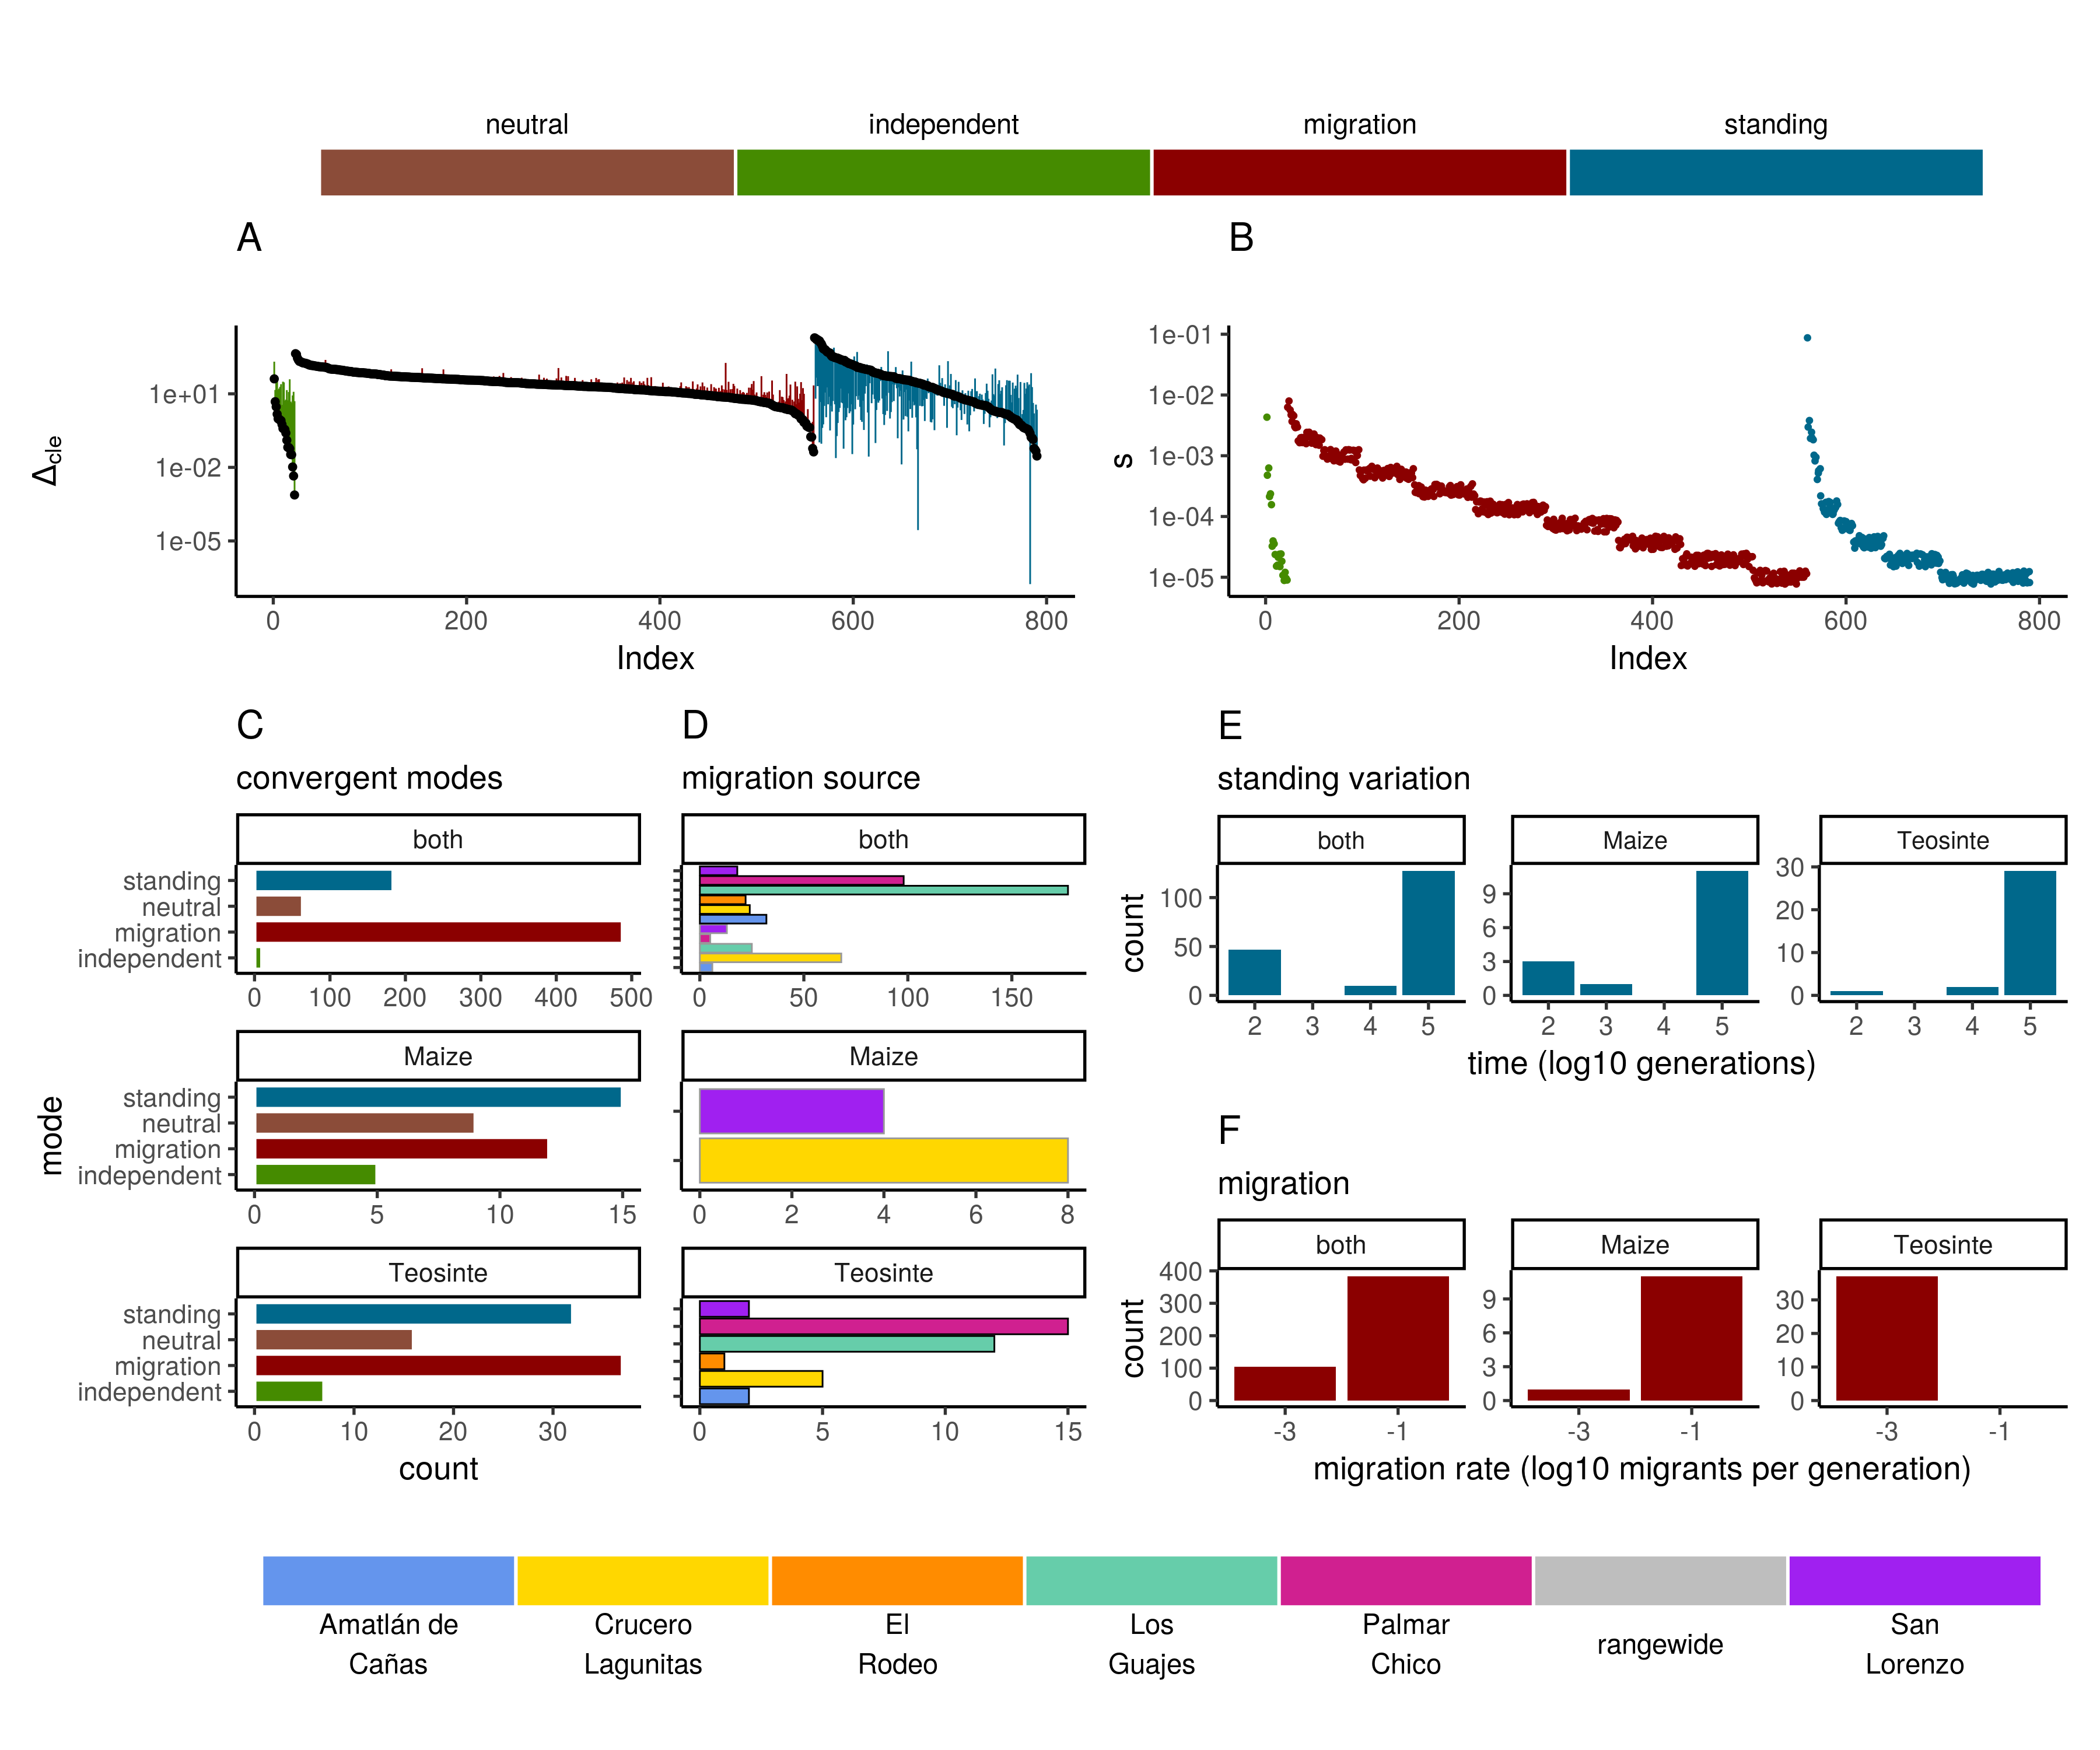

In [63]:

#color_format_df <- color_df %>% 
#    mutate(pop = str_replace_all(pop, "LR_", "Landrace ")) %>% 
#    mutate(pop = str_replace_all(pop, "Teo_", "Teosinte ")) %>% 
#    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
#    mutate(pop = str_remove_all(pop, "random([12])"))


color_format_df <- color_df %>% 
    mutate(pop = str_replace_all(pop, "LR_", "")) %>% 
    mutate(pop = str_replace_all(pop, "Teo_", "")) %>% 
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    mutate(pop = str_remove_all(pop, "random([12])"))


FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

id_df <- tibble(sources = 1:length(FREQ_POPS), pop_id = FREQ_POPS) 

top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(n())

top_models_df %>% 
    group_by(model2) %>% 
    summarise(n())

nrow(top_models_df)

mode_plot <- top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(counts = n()) %>% 
    ggplot(aes(model2, counts, fill = model2)) + 
    geom_bar(stat = "identity", lwd = 1.1, colour = "white") +
    facet_wrap(~type, scale = "free", ncol = 1) +
    coord_flip() +
    ylab("count") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small)) +
    xlab("mode")


print("HERE!")
head(top_models_df)

src_df  <-  
top_models_df %>%
    filter(model2 == "migration") %>% 
    full_join(., id_df, by = "sources")  %>% 
    mutate(ssp_id = ifelse(grepl("Landrace", pop_id), "Landrace", "Teosinte")) %>% 
    mutate(pop_id2 = pop_id) %>% 
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop"))

source_plot <- 
src_df  %>%
    ggplot(aes(pop_id2, fill = color, colour = ssp_id)) +
    geom_bar(stat = "count", position = position_dodge(preserve = "single"), lwd = 0.5) +
    xlab("Population") +
    ylab("count") +
    facet_wrap(~type, scale = "free", ncol = 1, drop = FALSE) +
    scale_x_discrete(drop=FALSE) +
    coord_flip() +
    scale_fill_identity() +
    scale_color_manual(values = c("Teosinte" = "black", "Landrace" = "grey60")) +
    theme( 
        strip.text.x = element_text(size = tts_small),
        legend.position = "n",
        axis.title = element_blank(),
        axis.text.y = element_blank()
    )


time_plot <- top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(log10(times), fill = model2)) +
    geom_bar(stat = "count") +
    ylab("count") +
    xlab("time (log10 generations)") +
    facet_wrap(~type, scale = "free_y") +
    scale_fill_manual(values = sel_cols) +
    theme(strip.text.x = element_text(size = tts_small-1)) +
    theme(legend.position = "n")


mig_plot <- top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(log10(migs)), fill = model)) +
    geom_bar(stat = "count") +
    ylab("count") +
    xlab("migration rate (log10 migrants per generation)") +
    facet_wrap(~type, scale = "free_y") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small))


options(repr.plot.width = 18, repr.plot.height = 15, repr.plot.res = 200)

mode_leg(size = 6, nud = 1) /
(((mode_mcle + ggtitle(label = "A", subtitle = "")) +
 (mode_sels + ggtitle(label = "B", subtitle = "")))) / 
((mode_plot + ggtitle("C", subtitle = "convergent modes") + source_plot + ggtitle("D", subtitle = "migration source")) | 
( (time_plot + ggtitle("E", subtitle = "standing variation")) / (mig_plot + ggtitle("F", subtitle = "migration")))) /
 make_legplot(text_size = 6) +
plot_layout(nrow = 4, heights = c(7,10,20,7))
ggsave("../figures/Figure5.pdf", width = 15, height = 15)


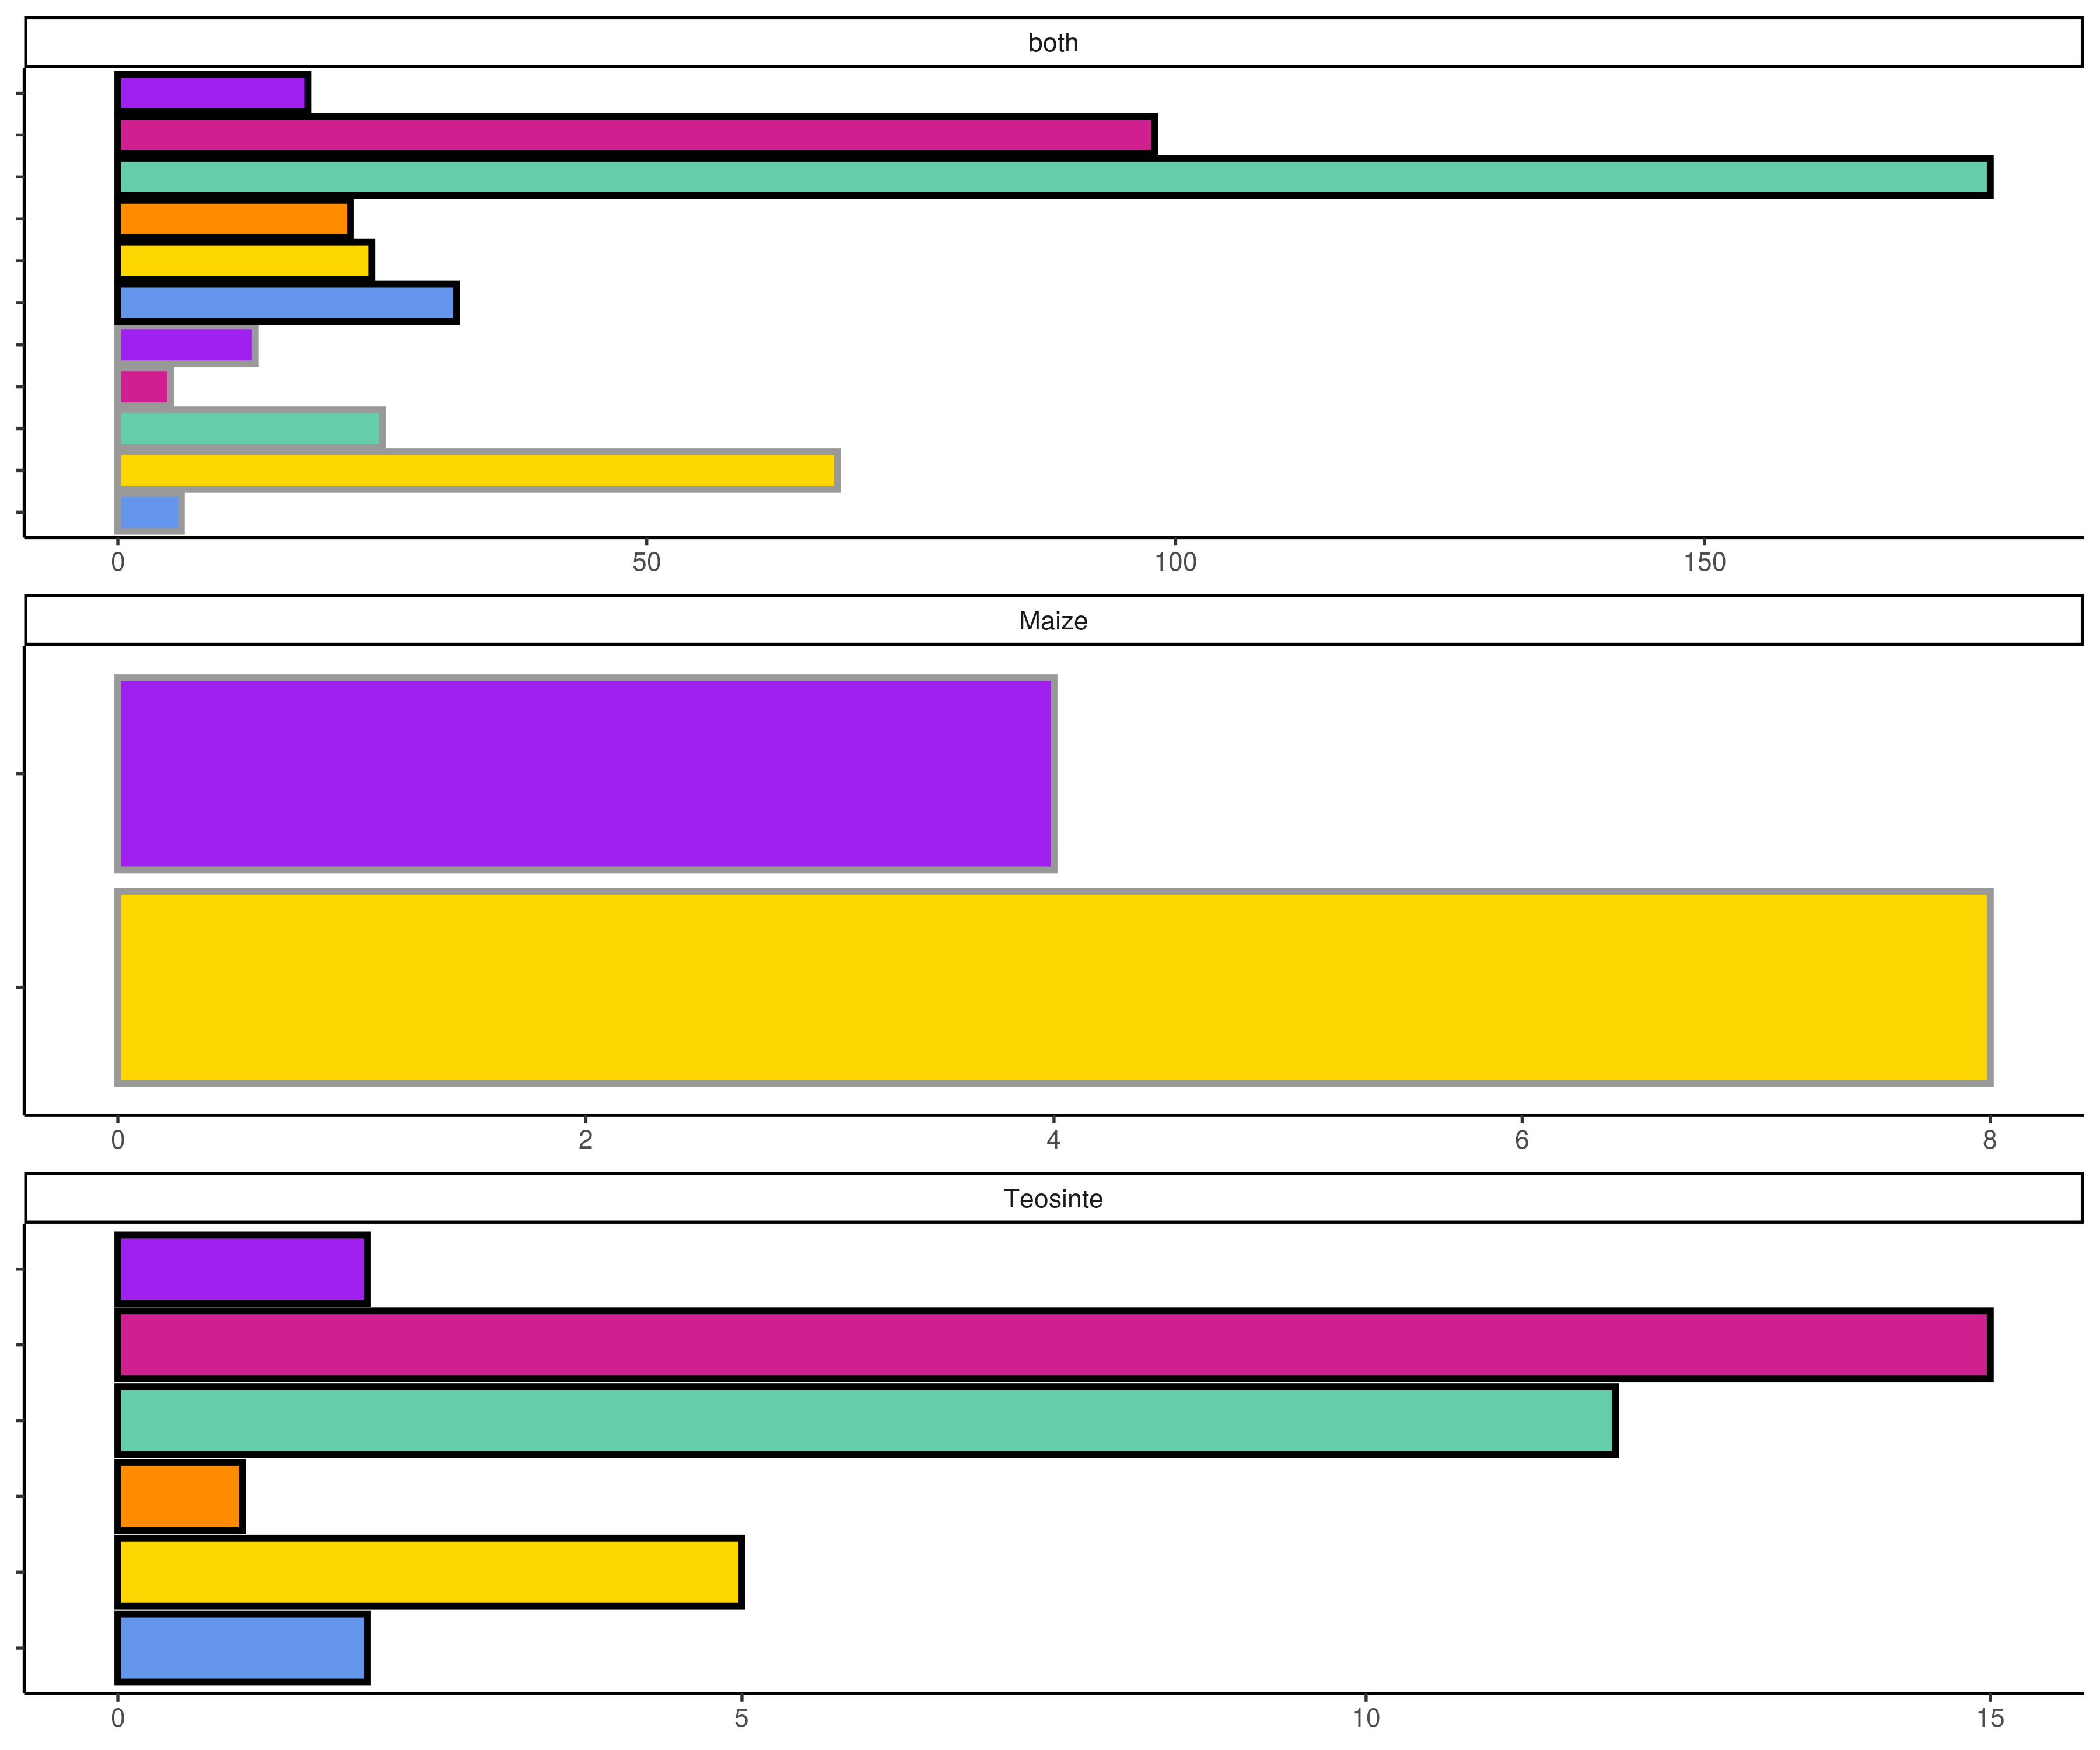

In [64]:
src_df  <-  
top_models_df %>%
    filter(model2 == "migration") %>% 
    full_join(., id_df, by = "sources")  %>% 
    mutate(ssp_id = ifelse(grepl("Landrace", pop_id), "Landrace", "Teosinte")) %>% 
    mutate(pop_id2 = pop_id) %>% 
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop"))

src_df  %>%
    ggplot(aes(pop_id2, fill = color, colour = ssp_id)) +
    geom_bar(stat = "count", position = position_dodge(preserve = "single"), lwd = 2) +
    xlab("Population") +
    ylab("count") +
    facet_wrap(~type, scale = "free", ncol = 1, drop = FALSE) +
    scale_x_discrete(drop=FALSE) +
    coord_flip() +
    scale_fill_identity() +
    scale_color_manual(values = c("Teosinte" = "black", "Landrace" = "grey60")) +
    theme( 
        strip.text.x = element_text(size = tts_small),
        legend.position = "n",
        axis.title = element_blank(),
        axis.text.y = element_blank()
    )


count pop with_alt
1  76   Teo without 
2 682   Teo with    
3  32   LR  without 
4 682   LR  with

model2      sum(Landraces_count) sum(Teosinte_count) n()
1 independent   25                   20                 10
2 migration   1417                 1540                488
3 neutral      141                  145                 64
4 standing     544                  583                184

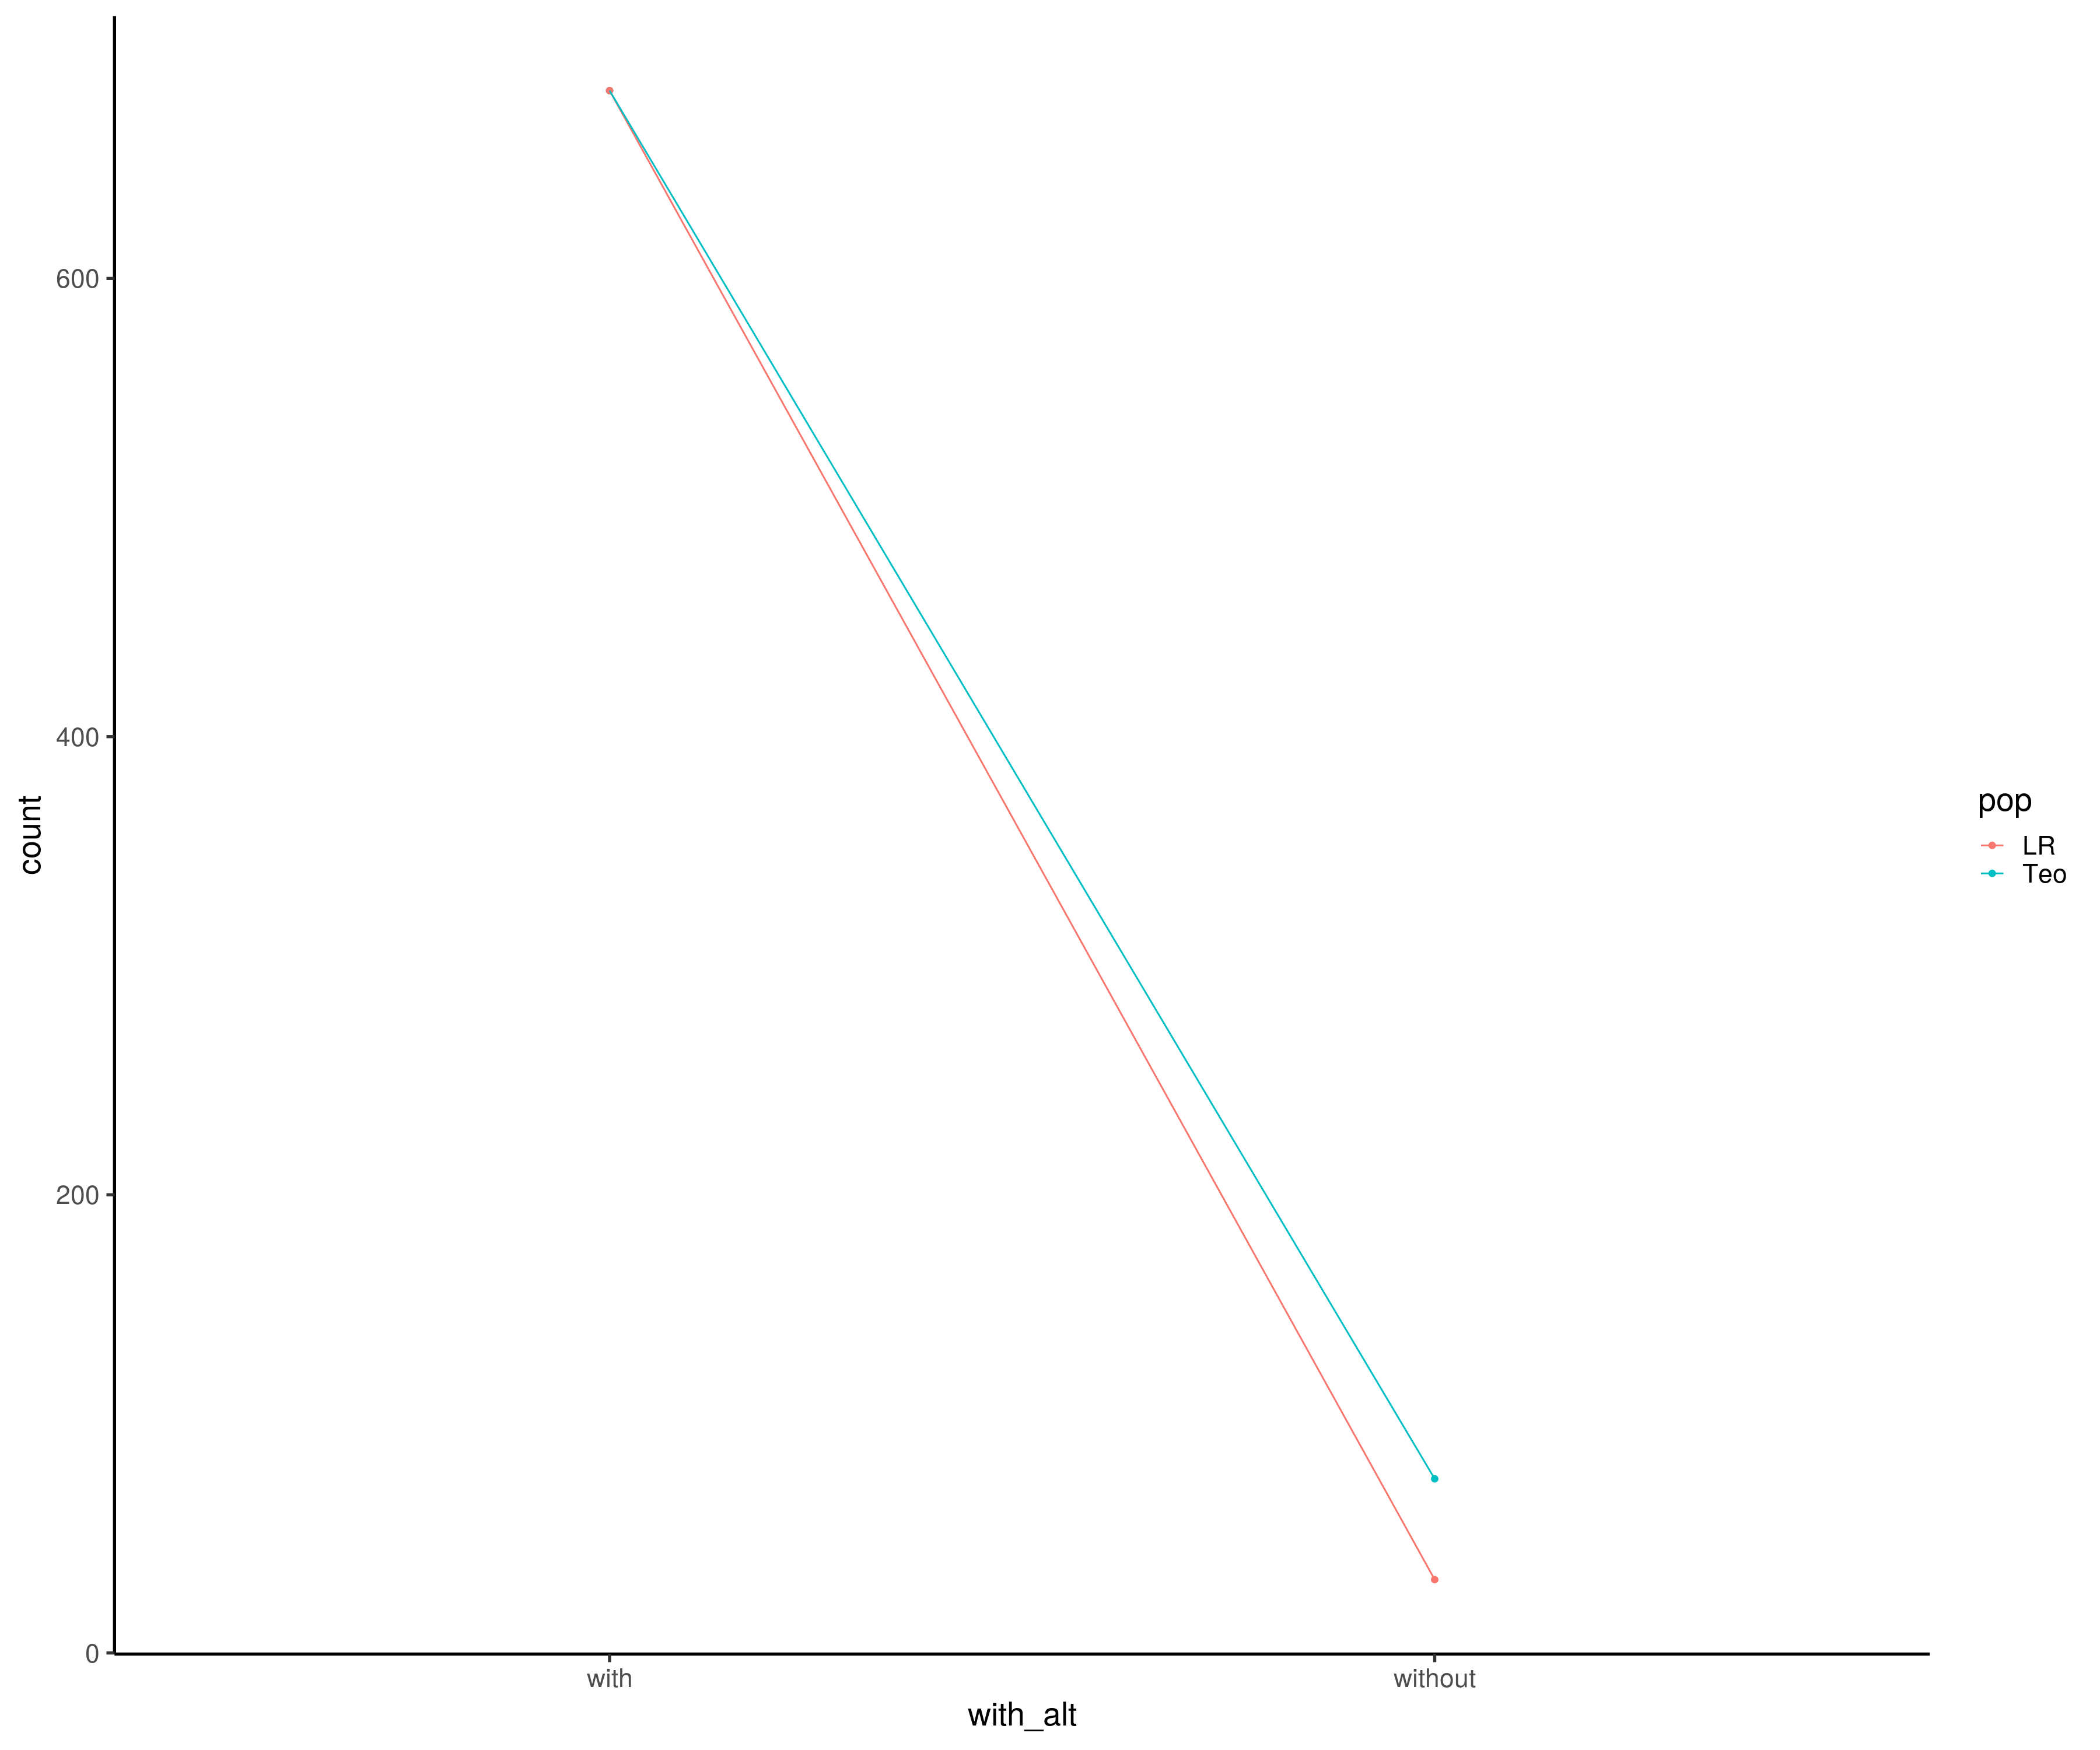

In [65]:
nonneut <- top_models_df %>% filter(model2 != "neutral")

MN <- 1
TEO_noLR <- nonneut %>% filter(Landraces_count == 0, Teosinte_count >= MN)  %>% nrow()
TEO_LR <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count >= MN) %>% nrow()
LR_noTeo <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count == 0)  %>% nrow()
LR_TEO <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count >= MN) %>% nrow()

cross_df <- tibble(
    count = c(TEO_noLR, TEO_LR, LR_noTeo, LR_TEO),
    pop = c("Teo", "Teo", "LR", "LR"),
    with_alt = c("without", "with", "without", "with")
) 

cross_df

cross_df %>% 
group_by(pop) %>% 
mutate(count2 = count/max(count)) %>% 
ggplot(aes(with_alt, count, group = pop, colour = pop)) +
geom_point() +
geom_line()



top_models_df %>% 
  filter(type == "both") %>% 
  group_by(model2) %>% 
  summarise(
      sum(Landraces_count),
      sum(Teosinte_count),
      n()
  )


`summarise()` has grouped output by 'ssp'. You can override using the `.groups` argument.



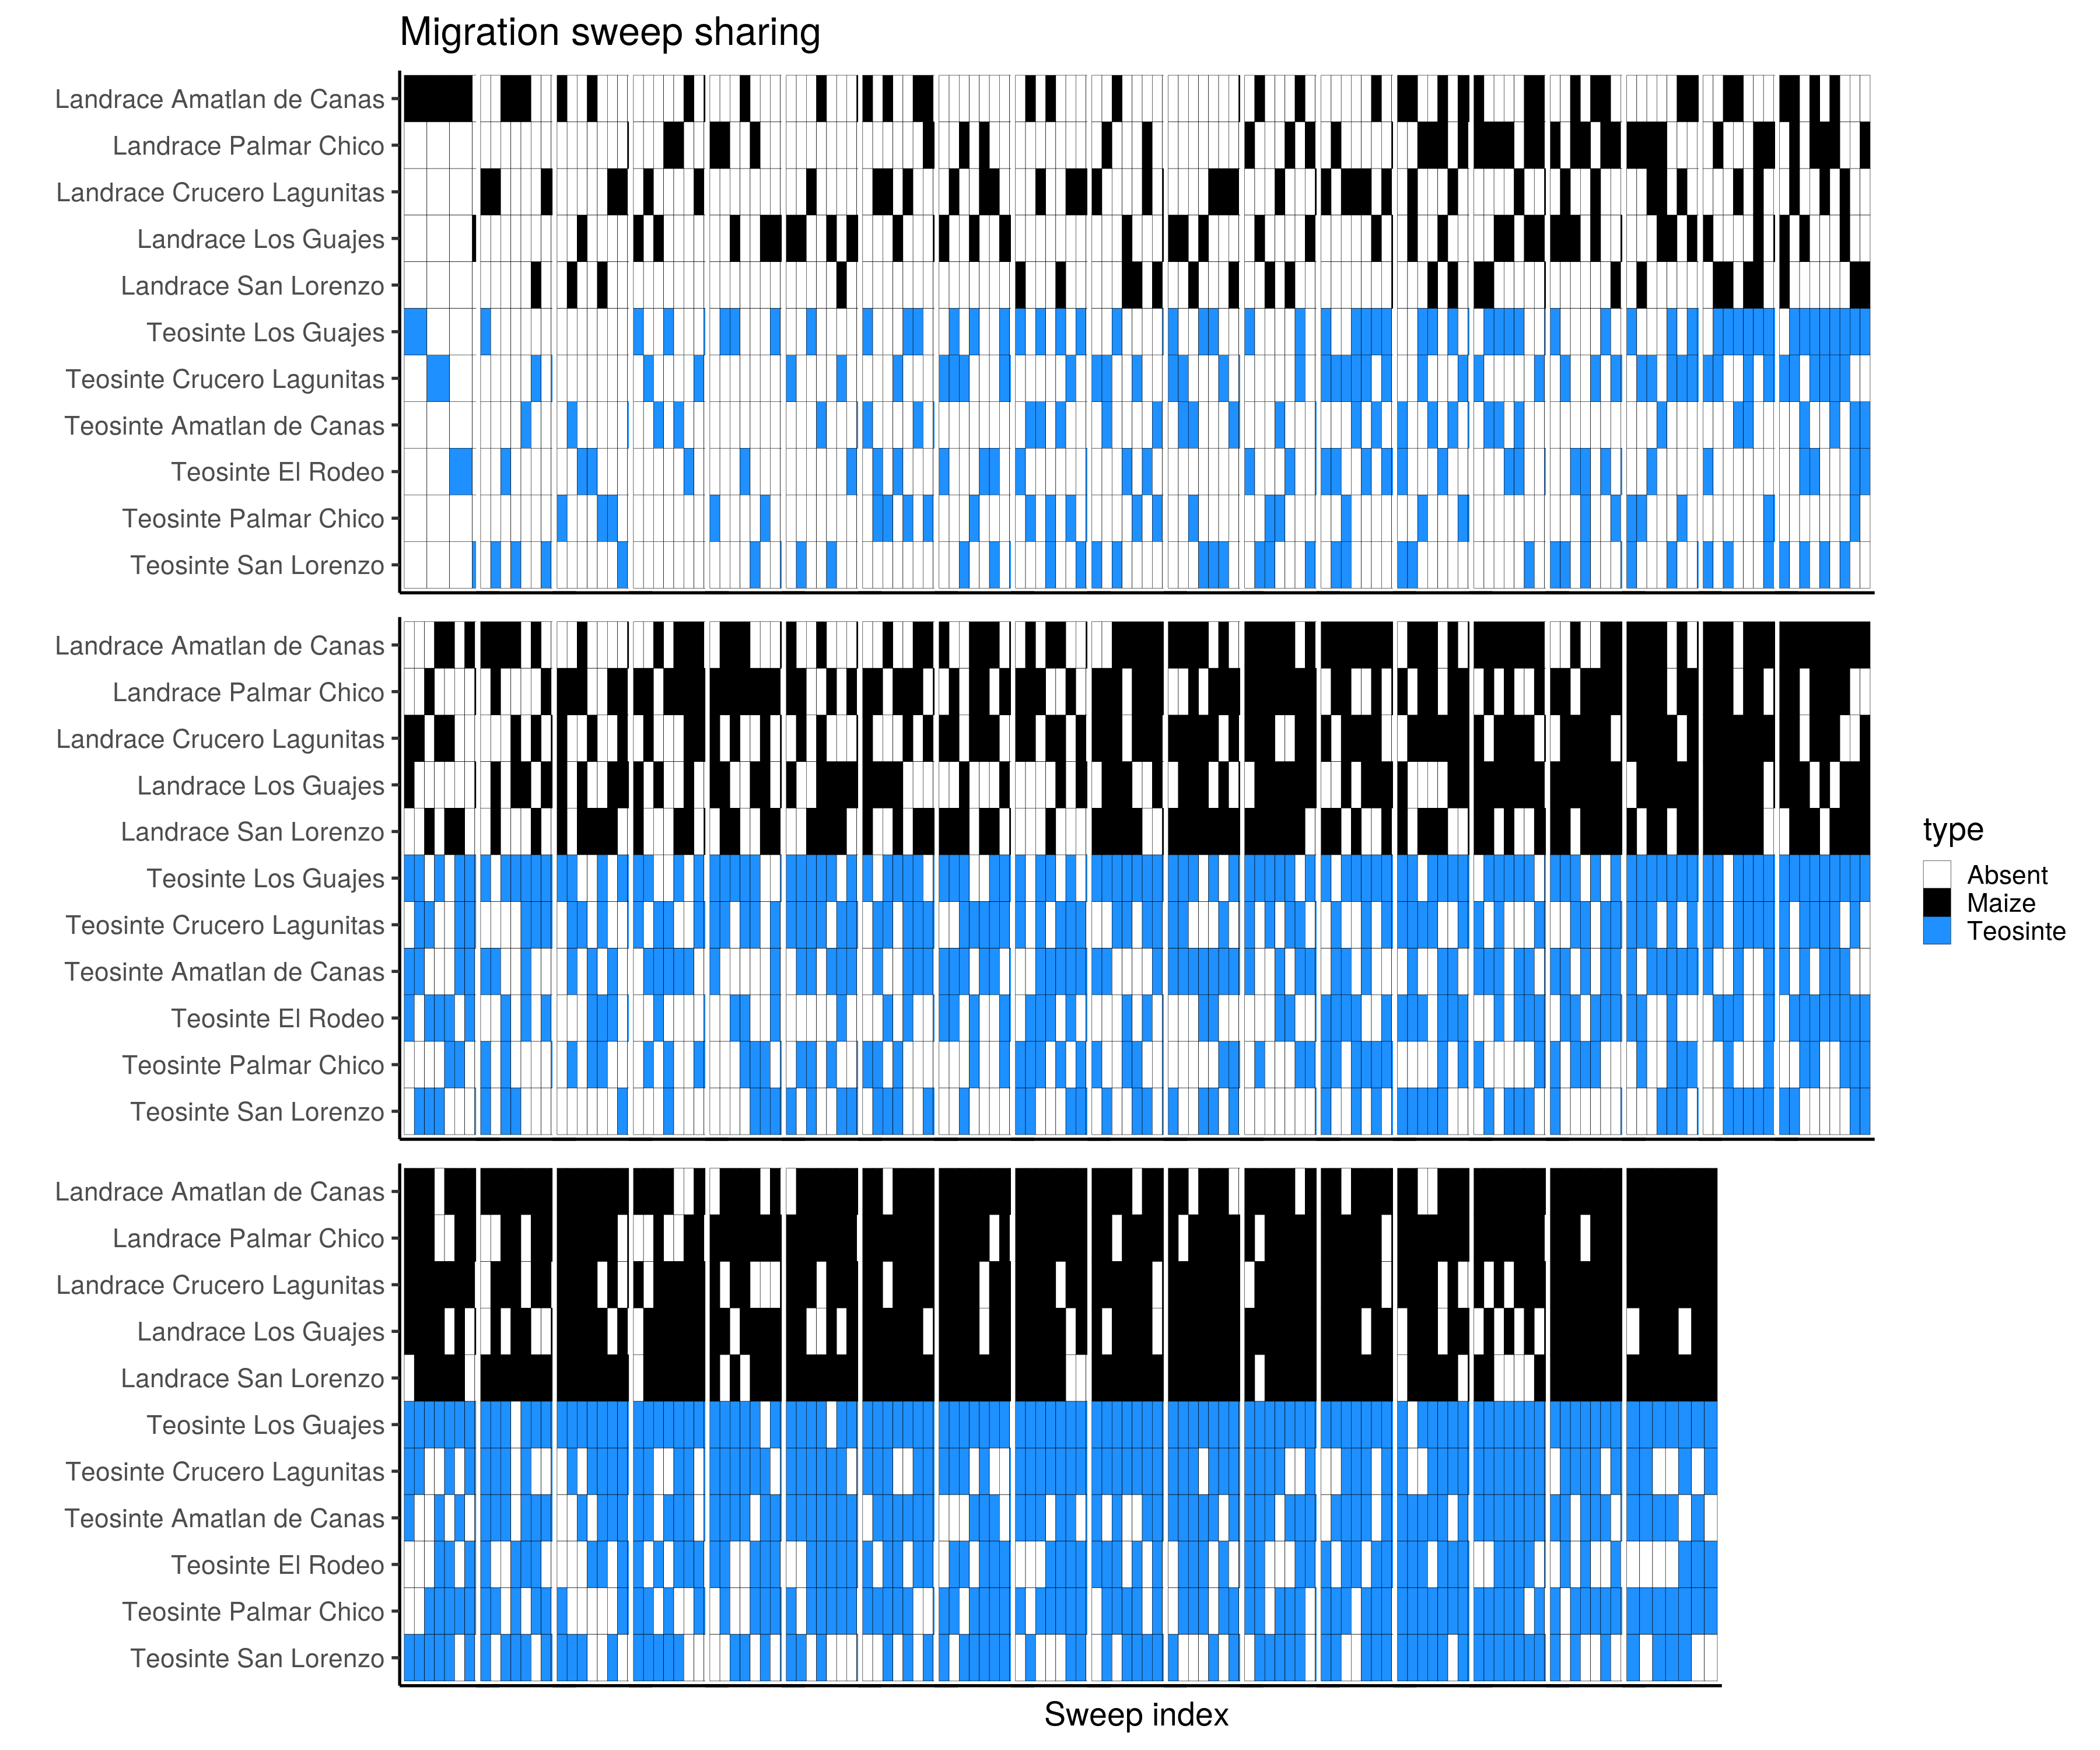

In [66]:

msweep_df <- 
top_models_df %>%  
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    arrange(pop_count) %>% 
    pull(populations) %>%
    str_replace_all("_|--", " ") %>% 
    str_replace_all("LR", "Landrace") %>% 
    str_replace_all("Teo", "Teosinte") %>%
    str_remove_all("RANDOM1 ") %>% 
    map_dfr(~{
        count_vec <- str_count(.x, FREQ_POPS)
        names(count_vec) <- FREQ_POPS
        count_vec
    }) %>% 
    mutate(
        sweep_id = 1:n(), 
        sweep_group = round(sweep_id / 9, 0)) %>%
    pivot_longer(-c(sweep_id, sweep_group), names_to = "pop", values_to = "sweep")

pop_order <- 
msweep_df %>%
    mutate(ssp = ifelse(grepl("Teosinte", pop), "Teo", "LR")) %>%
    group_by(ssp, pop) %>% 
    summarise(summ = sum(sweep)) %>% 
    arrange(summ) %>% 
    arrange(desc(ssp), summ) %>% 
    pull(pop)


plt <- 
msweep_df %>% 
    mutate(pop = factor(pop, levels = pop_order)) %>% 
    mutate(
        type = case_when( 
            grepl("Teosinte", pop) & sweep == 1 ~ "Teosinte",
            grepl("Teosinte", pop) & sweep == 0 ~ "Absent",
            grepl("Landrace", pop) & sweep == 1 ~ "Landrace",
            grepl("Landrace", pop) & sweep == 0 ~ "Absent"
        ) 
    ) %>% 
    #ggplot(aes(sweep_id, pop, fill = factor(sweep))) +
    ggplot(aes(sweep_id, pop, fill = type)) +
    geom_tile(color = "black") +
    facet_wrap(~sweep_group, scales = "free_x", nrow = 3) +
    xlab("Sweep index") +
    ylab("") +
    theme(
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.spacing.x = unit(-1, "lines"),  
    ) +
    scale_fill_manual(labels = c("Absent", "Maize", "Teosinte"), values = c("white", "black", "dodgerblue")) +
    ggtitle("Migration sweep sharing")

plt + ggsave("../figures/supplement_sweeps.pdf", width = 18, height = 15)


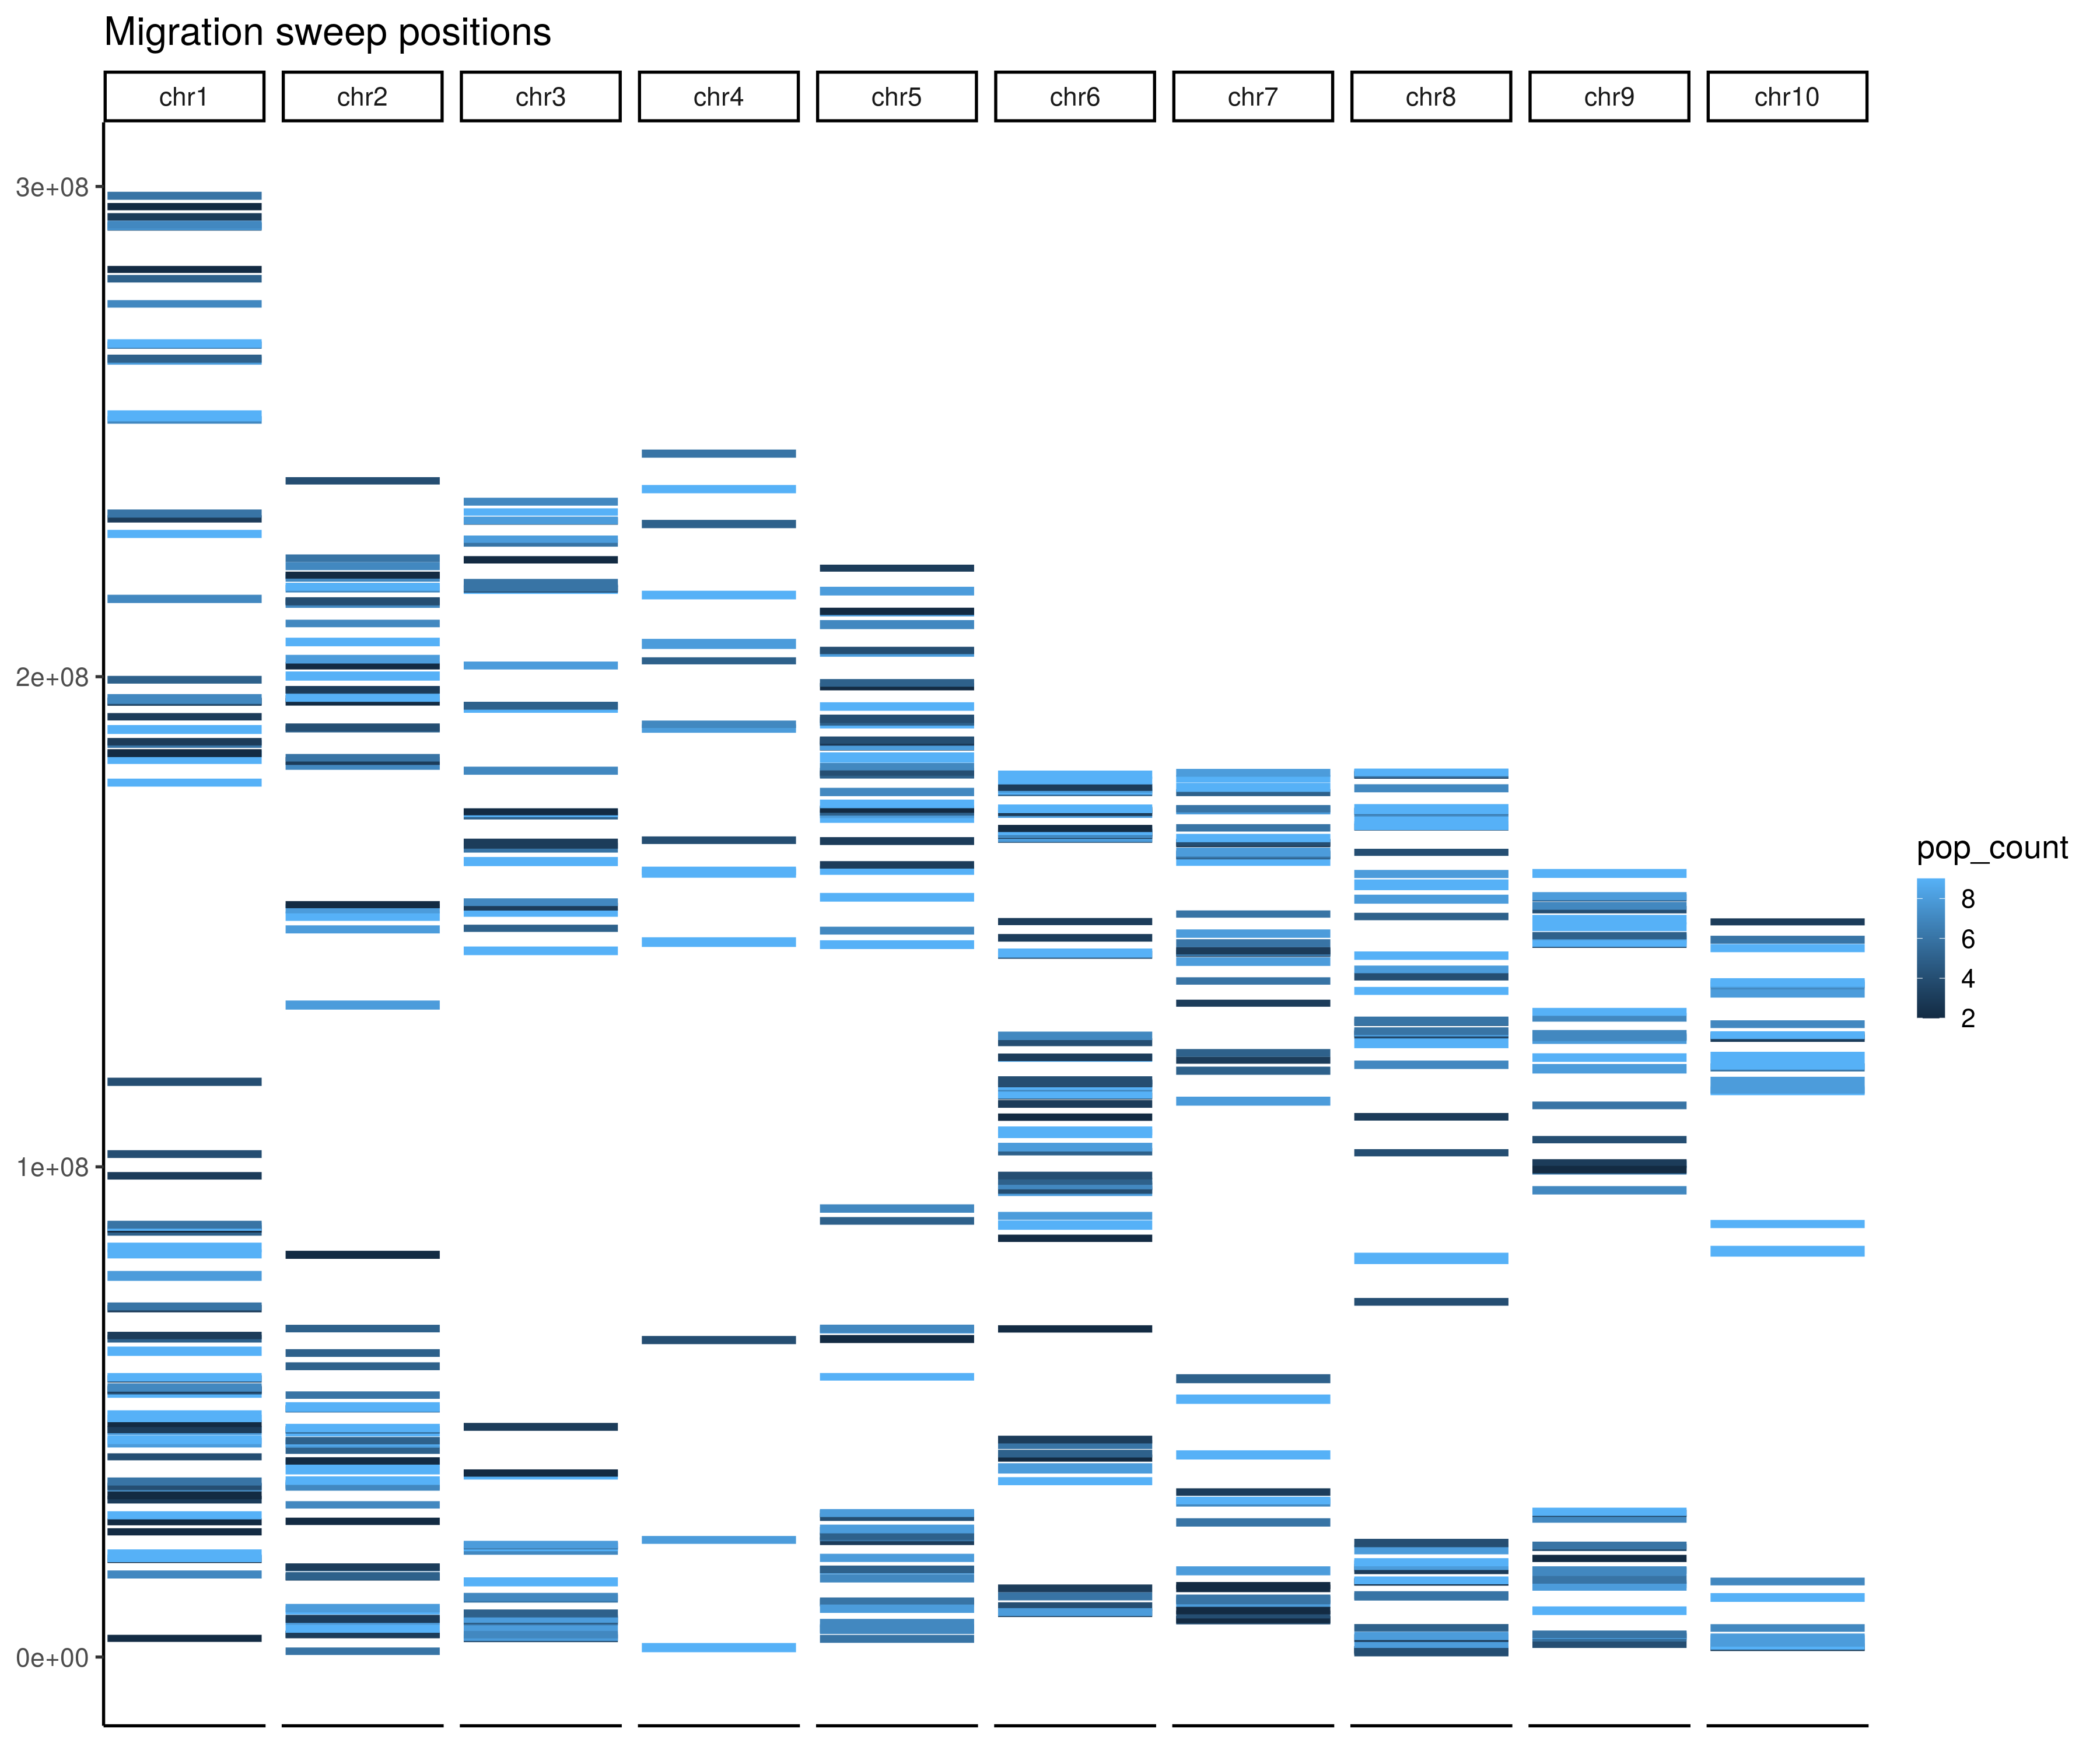

In [67]:
top_models_df %>%
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    mutate(chrom = str_extract(locus, "chr[0-9][0-9]*")) %>%
    mutate(chrom = factor(chrom, levels = paste0("chr", 1:10))) %>% 
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    ggplot() +
    geom_rect(aes(xmin = 0, xmax = 1, ymin = sweep_start_bp, ymax = sweep_end_bp, color = pop_count, fill = pop_count), lwd = 2) +
    facet_grid(~chrom) +
    theme(axis.text.x = element_blank(),
         axis.ticks.x = element_blank()) +
    ggtitle("Migration sweep positions") +
    ggsave("../figures/supplement_sweeps_locs.pdf", width = 14, height = 15)


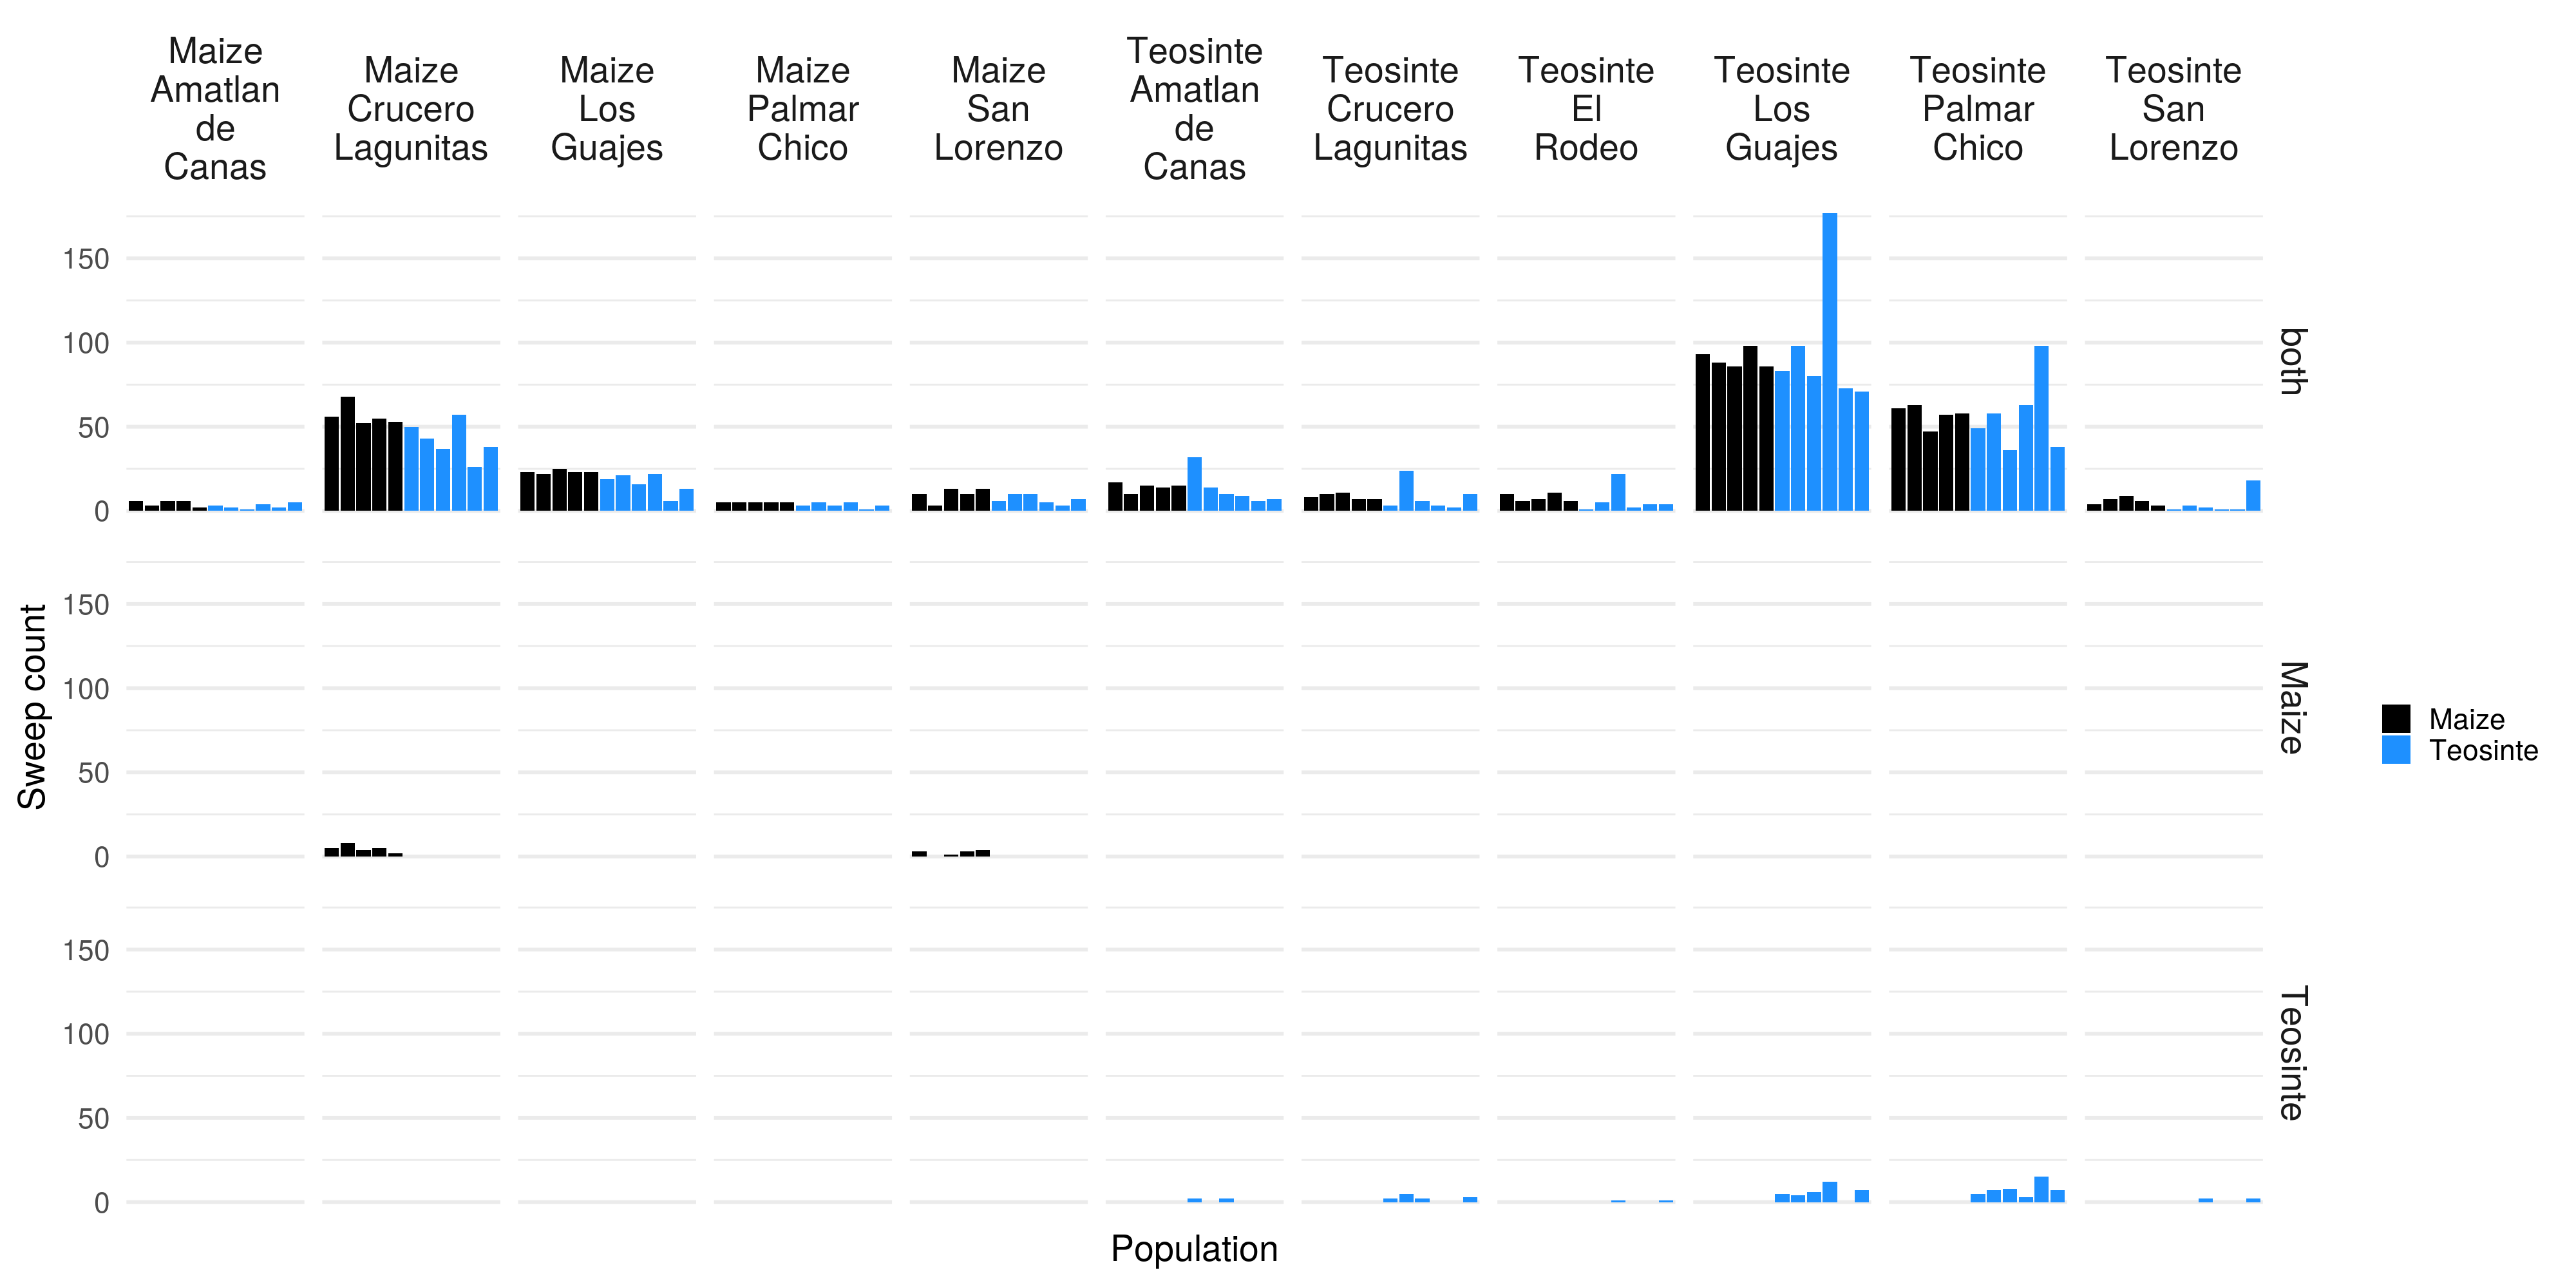

In [68]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 200)

FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

latlong_df <- 
    tibble(
    population = c("Crucero Lagunitas", "Amatlan de Canas", "El Rodeo", "Los Guajes", "San Lorenzo", "Palmar Chico"),
    color = c("gold", "cornflowerblue", "darkorange", "mediumaquamarine", "purple", "violetred"),
    Latitude = c(16.98, 20.82, 16.35, 19.23, 19.94, 18.64),
    Longitude = c(-99.28, -104.41, -97.02, -100.49, -103.99, -100.35),
    altitude = c(590, 880, 982, 985, 982, 1008)
    )

id_vec <- 
str_split(top_models_df$populations, pattern = ";", simplify = T) %>% 
as.matrix(ncol = 1) %>% 
as.vector() %>% 
str_remove_all(" ") %>%
unique()

pops_vec <- 
id_vec %>% 
str_remove_all("v5--") %>%
str_replace_all("--", " ") %>% 
str_replace_all("_", " ")

sourcepop_df <- 
c("both", "Maize", "Teosinte") %>% 
map_df(function(TYPE){
    map_df(FREQ_POPS, function(source_pop){
        expand_grid(pop1 = id_vec) %>%
        filter(str_length(pop1) > 0) %>% 
        pmap_df(function(pop1){
            count <- 
            top_models_df %>% 
            filter(model2 == "migration", type == TYPE,
                   sources == which(FREQ_POPS == source_pop),
                   grepl(pop1, populations)
                  ) %>% 
            nrow()
            tibble(source_pop, pop1, count, type = TYPE)
        })
    })
}) %>% 
    mutate(
        pop1 = str_remove_all(pop1, "v5--"),
        pop1 = str_remove_all(pop1, "RANDOM1"),
        pop1 = str_replace_all(pop1, "--", " "),
        pop1 = str_replace_all(pop1, "_", " "),
        pop1 = str_replace_all(pop1, "  ", " "),
        pop1 = str_replace_all(pop1, "LR", "Maize"),
        pop1 = str_replace_all(pop1, "Teo", "Teosinte")
    ) %>% 
    mutate(ssp = ifelse(grepl("Maize", pop1), "Maize", "Teosinte"),
           source_ssp = ifelse(grepl("Maize", source_pop), "Maize", "Teosinte")) #%>% 
    #filter(source_pop != pop1)

sourcepop_df %>%
    mutate(source_pop = str_replace_all(source_pop, " ", "\n"),
           source_pop = str_replace_all(source_pop, "Landrace", "Maize")
           ) %>% 
    ggplot(aes(pop1, count, fill = ssp)) +
    geom_bar(stat = "identity") +
    facet_grid(type ~ source_pop) +
    theme_minimal(20) +
    theme(axis.text.x = element_blank(), 
         strip.text = element_text(size = 20),
         panel.grid.major.x = element_blank(),
         panel.grid.minor = element_line(size = 0.5), 
         panel.grid.major = element_line(size = 1)
        ) +
    xlab("Population") +
    ylab("Sweep count") +
    scale_fill_manual(values = c("Maize" = "black", "Teosinte" = "dodgerblue")) +
    guides(fill=guide_legend(title="")) +
    ggsave("../figures/supplement_sources.pdf", width = 20, height = 10)



# Just exploratory analyses from here down

In [69]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

#geography and sharing

pop_ids <- c(
'v5--LR--Amatlan_de_Canas',
'v5--LR--Crucero_Lagunitas',
'v5--LR--Los_Guajes',
'v5--LR--RANDOM1_Palmar_Chico',
'v5--LR--San_Lorenzo',
'v5--Teo--Amatlan_de_Canas',
'v5--Teo--Crucero_Lagunitas',
'v5--Teo--El_Rodeo',
'v5--Teo--Los_Guajes',
'v5--Teo--RANDOM1_Palmar_Chico',
'v5--Teo--San_Lorenzo'
)

FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

latlong_df <- 
    tibble(
    population = c("Landrace Crucero Lagunitas", "Landrace Amatlan de Canas", "Landrace El Rodeo", "Landrace Los Guajes", "Landrace San Lorenzo", "Landrace Palmar Chico", 
                  "Teosinte Crucero Lagunitas", "Teosinte Amatlan de Canas", "Teosinte El Rodeo", "Teosinte Los Guajes", "Teosinte San Lorenzo", "Teosinte Palmar Chico"),
    color = c("gold", "cornflowerblue", "darkorange", "mediumaquamarine", "purple", "violetred", "gold", "cornflowerblue", "darkorange", "mediumaquamarine", "purple", "violetred"),
    Latitude = c(16.98, 20.82, 16.35, 19.23, 19.94, 18.64, 16.98, 20.82, 16.35, 19.23, 19.94, 18.64),
    Longitude = c(-99.28, -104.41, -97.02, -100.49, -103.99, -100.35, -99.28, -104.41, -97.02, -100.49, -103.99, -100.35),
    altitude = c(590, 880, 982, 985, 982, 1008, 590, 880, 982, 985, 982, 1008)
    ) %>% 
filter(population != "Landrace El Rodeo") %>% 
    arrange(population)

#matrix of geo distances between pops
geo_mat <- geodist::geodist(cbind(latlong_df$Longitude, latlong_df$Latitude), measure = "geodesic")
rownames(geo_mat) <- latlong_df$population
    
#nested maps, count pops together, bind columns

makesweepmat <- function(df, pop_ids){
    share_aln <- 
    map_dfc(1:nrow(df), function(c){
    tibble(as.numeric(map_lgl(pop_ids, ~grepl(.x, top_models_df$populations[c])))) %>% 
    set_colnames(paste0("s", c))
}) %>% 
    as.matrix()
    #rownames(share_aln) <- FREQ_POPS
    as.matrix(dist(share_aln))
}

#distance matrix of sweep sharing by population
sweep_mat <- makesweepmat(filter(top_models_df, model2 == "migration", type == "Maize"), pop_ids)
#geographic distance versus sweep sharing distance
diag(geo_mat) <- diag(sweep_mat) <- NA
plot(geo_mat, sweep_mat)
geo_mat; sweep_mat
mantel.test(geo_mat, sweep_mat)

#again for neutral sweeps
sweep_mat <- makesweepmat(filter(top_models_df, model2 == "neutral", type == "both"), pop_ids)
rownames(geo_mat) <- latlong_df$population
diag(geo_mat) <- diag(sweep_mat) <- NA
#geographic distance versus sweep sharing distance
geo_mat; sweep_mat
mantel.test(geo_mat, sweep_mat)


ERROR: Error in loadNamespace(name): there is no package called ‘geodist’


In [ ]:
#matrix of geo distances between pops
latlong_subsp <- filter(latlong_df, grepl("Teosinte", population))
geomat_subsp <- geodist::geodist(cbind(latlong_subsp$Longitude, latlong_subsp$Latitude), measure = "geodesic")
rownames(geomat_subsp) <- latlong_subsp$population

subsp_mig <- makesweepmat(filter(top_models_df, type == "Teosinte", model2 == "migration"), 
             pop_ids = c('v5--Teo--Amatlan_de_Canas','v5--Teo--Crucero_Lagunitas',
                         'v5--Teo--El_Rodeo','v5--Teo--Los_Guajes',
                         'v5--Teo--RANDOM1_Palmar_Chico','v5--Teo--San_Lorenzo'))
diag(geomat_subsp) <- diag(subsp_mig) <- NA
plot(geomat_subsp, subsp_mig)
mantel.test(geomat_subsp, subsp_mig)


latlong_subsp <- filter(latlong_df, grepl("Landrace", population))
geomat_subsp <- geodist::geodist(cbind(latlong_subsp$Longitude, latlong_subsp$Latitude), measure = "geodesic")
rownames(geomat_subsp) <- latlong_subsp$population
geomat_subsp
subsp_mig <- makesweepmat(filter(top_models_df, type == "Maize", model2 == "migration"), 
             pop_ids = c('v5--LR--Amatlan_de_Canas','v5--LR--Crucero_Lagunitas',
                         'v5--LR--Los_Guajes',
                         'v5--LR--RANDOM1_Palmar_Chico','v5--LR--San_Lorenzo'))
diag(geomat_subsp) <- diag(subsp_mig) <- NA
plot(geomat_subsp, subsp_mig)
mantel.test(geomat_subsp, subsp_mig)
subsp_mig

In [ ]:
source("../color_df.R")

color_df
tree_plotter <- function(tree, dge = 110){

    tree$tip.label <- str_remove_all(tree$tip.label, "v5--")
    tree_string <- drop.tip(tree, tip = c("Teo--Palmar_Chico", "Teo--random2_Palmar_Chico", "LR--Palmar_Chico", "LR--random2_Palmar_Chico"))

    #png(filename = "../figures/raw_tree.png", res = 300, width = 5, height = 5, units = "in")
    #pdf("../figures/raw_tree.pdf", width = 5, height = 5)

    par(mar = c(0,0,2,0))
    plot.phylo(tree_string, type = "unrooted", show.tip.label = FALSE, 
               rotate.tree = dge, edge.width = 2, no.margin = TRUE)
    tip_str <- str_replace(tree_string$tip.label, "--", "_")
    tip_str <- str_replace(tip_str, "RANDOM", "random")
    
    tip_pch <- ifelse(grepl("Teo", x = tip_str), 21, 24)
    tiplabels(pch = tip_pch, bg = color_df$color[match(tip_str, color_df$pop)], cex = 3.5)
    #tiplabels(text = tip_str)
    #box()
    
    #text(0.08,0.0, "Maize", cex = 1.5)
    #text(0.08,0.1, "Teosinte", cex = 1.5)

    par(new=TRUE)
    plot.phylo(tree_string, type = "unrooted", show.tip.label = FALSE, 
               rotate.tree = dge, edge.width = 2.5, no.margin = TRUE)

    legend_df <- color_df %>% 
        mutate(pop = str_replace(pop, pattern = "(LR|Teo)_(.)", "\\2") %>% str_replace("random(1|2)_", "")) %>% 
        distinct() %>% 
        filter(pop != "random")
    #legend('right', cex = 1, legend_df$pop, pch = 21, pt.bg = legend_df$color, ncol = 1)
    #dev.off()

    #treeplot <- image_ggplot(image_read("../figures/raw_tree.pdf"), interpolate = TRUE) + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

}


In [ ]:
options(repr.plot.width = 7, repr.plot.height = 6 , repr.plot.res = 200)

shareplot <- top_models_df %>%
    filter(model2 != "neutral") %>% 
    mutate(
        pop_count = str_count(populations, ",") + 1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        ) %>% 
    filter(Landraces_count != 0 | Teosinte_count != 0) %>%
    group_by(Landraces_count, Teosinte_count) %>% 
    summarise(type_count = n()) %>% 
    ggplot(aes(Landraces_count, Teosinte_count, fill = log10(type_count))) +
    geom_tile(color = "black") +
    scale_fill_gradient(low = "white", high = "black") +
    scale_y_continuous(breaks = 0:18) +
    scale_x_continuous(breaks = 0:18) +
    xlab("Number of Landrace populations") +
    ylab("Number of Teosinte populations") +
    labs(fill = expression(paste(log[10], " count")))
    
shareplot

In [ ]:
all_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--random1_Palmar_Chico", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--random1_Palmar_Chico", 
    "v5--Teo--San_Lorenzo"
)

pop_pairs <- 
combn(all_pops, 2) %>% 
    t() %>% 
    data.frame() %>% 
    set_colnames(c("pop1", "pop2")) %>% 
    as_tibble() %>% 
    mutate(pop1 = str_replace_all(pop1, "random1", "RANDOM1"),
           pop2 = str_replace_all(pop2, "random2", "RANDOM2"))
head(pop_pairs)



pair_df <- 

c("both", "Teosinte", "Maize") %>% 
map_df(~{
    pop_pairs %>%
        rowwise() %>% 
        pmap_df(function(pop1, pop2){

                share_count <- filter(top_models_df, grepl(pop1, populations), 
                                      grepl(pop2, populations), type == .x) %>% 
                nrow()
                if(share_count > 0){
                    tibble(pop1, pop2, share_count, type = .x)
                } else{
                    tibble()
                }
                
        })

    }) %>% 
    arrange(desc(share_count))


pop_count_df <- 
    all_pops %>% 
    map_df(~ {
        pcount <- filter(top_models_df, grepl(.x, populations)) %>% 
            nrow()
        tibble(pop = .x, count_pop1 = pcount, count_pop2 = pcount)
    })

head(pop_count_df)

pair_df %>% 
    filter(type == "Teosinte", grepl("LR", pop1), grepl("LR", pop2))


sweep_counts_df <- top_models_df %>% 
    group_by(type) %>% 
    summarise(total_sweeps = n()) %>%
    ungroup() %>% 
    mutate(total_sweeps = ifelse(type == "both", sum(.$total_sweeps), total_sweeps))
sweep_counts_df


top_models_df %>% 
    filter(pop_count > 1) %>% 
    ggplot(aes(log10(sweepsize_cM), colour = type)) +
    geom_density() +
    xlab(expression(paste(log[10], " sweep size")))


top_models_df %>% 
    filter(pop_count > 1, model2 %in% c("migration, independent", "standing")) %>% 
    ggplot(aes(log10(sweepsize_cM), pop_count, colour = type)) +
    geom_point() +
    facet_wrap(~type, ncol = 1) +
    xlab(expression(paste(log[10], " sweep size"))) +
    ylab("Number of populations")


pair_df <- 

c("both", "Teosinte", "Maize") %>% 
map_df(~{
    pop_pairs %>%
        rowwise() %>% 
        pmap_df(function(pop1, pop2){

                share_count <- filter(top_models_df, grepl(pop1, populations), 
                                      grepl(pop2, populations), type == .x) %>% 
                nrow()
                if(share_count > 0){
                    tibble(pop1, pop2, share_count, type = .x)
                } else{
                    tibble()
                }
                
        })

    }) %>% 
    arrange(desc(share_count))


pop_count_df <- 
    all_pops %>% 
    map_df(~ {
        pcount <- filter(top_models_df, grepl(.x, populations)) %>% 
            nrow()
        tibble(pop = .x, count_pop1 = pcount, count_pop2 = pcount)
    })

head(pop_count_df)

pair_df %>% 
    filter(type == "Teosinte", grepl("LR", pop1), grepl("LR", pop2))

